### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Saturday, Mar 1st at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (100 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

MEK: Import block

In [10]:
import numpy as np
import scipy
from scipy import optimize
from scipy import stats
from matplotlib import pyplot as plt
from scipy.integrate import quad
import corner.corner as corner
import emcee
import acor
import dynesty
import ultranest
from ultranest.plot import cornerplot

MEK: Read HW5 data

In [11]:
hw5data1 = np.load("./../../homeworks/hw_data/hw5_data_1.npy")
time = hw5data1[:,0]
flux = hw5data1[:,1]
uncert = hw5data1[:,2]

MEK: Plot data

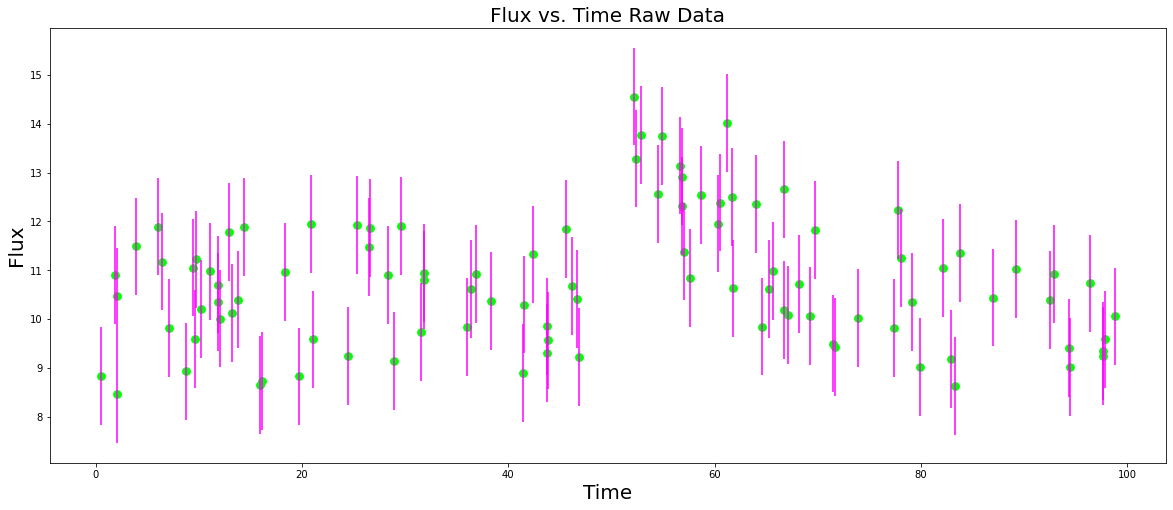

In [133]:
plt.figure(figsize=(20,8))
plt.errorbar(time, flux, yerr=uncert, color="magenta", fmt="none")
plt.scatter(time, flux, color="lime", s=60)
plt.title("Flux vs. Time Raw Data", fontsize=20)
plt.xlabel("Time", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.show()

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

MEK: Define burst model and log likelihood functions

In [13]:
def burst(t, A, b, lnalpha, t0):
    alpha = np.e**lnalpha
    y_array = np.zeros(len(t))
    y_array[np.where(t<t0)] = b
    y_array[np.where(t>=t0)] = b + (A*(np.e**(-alpha*(t[np.where(t>=t0)]-t0))))
    return y_array

# compute the data log-likelihood given a model
def logL(params, data, model=burst):
    A, b, lnalpha, t0 = params
    time = data[:,0]
    flux = data[:,1]
    uncert = data[:,2]
    y_fit = model(time, A, b, lnalpha, t0)
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(flux, y_fit, uncert))

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

MEK: Define prior and posterior functions

In [14]:
def uniform_prior(x, loc, scale):
    prior = scipy.stats.uniform(loc, scale)
    pdf = prior.pdf(x)
    return pdf

def lnposterior(params, data):
    A, b, lnalpha, t0 = params
    return logL(params, data)+np.log(uniform_prior(A, 0, 50))+np.log(uniform_prior(b, 0, 50))+np.log(uniform_prior(t0, 0, 100))+np.log(uniform_prior(lnalpha, -5, 10))

MEK: Set up and run emcee sampler with number of dimensions=4, number of walkers=15, no burn in (to save this step for Q4), and 20000 steps for each walker

In [26]:
ndim = 4  # number of parameters in the model
nwalkers = 15  # number of MCMC walkers
burn = 0  # "burn-in" period to let chains stabilize
nsteps = 20000  # number of MCMC steps to take **for each walker**

np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))

# the function call where all the work happens: 
sampler_emcee = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=[hw5data1])
sampler_emcee.run_mcmc(starting_guesses, nsteps, progress=True)

# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler_emcee.chain[:, burn:, :].reshape(-1, ndim)

/tmp/ipykernel_84070/1189751174.py:8: RuntimeWarning: divide by zero encountered in log                                                    | 0/20000 [00:00<?, ?it/s]
  return logL(params, data)+np.log(uniform_prior(A, 0, 50))+np.log(uniform_prior(b, 0, 50))+np.log(uniform_prior(t0, 0, 100))+np.log(uniform_prior(lnalpha, -5, 10))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [29:46<00:00, 11.19it/s]


4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

MEK: Plot trace to check where to burn in

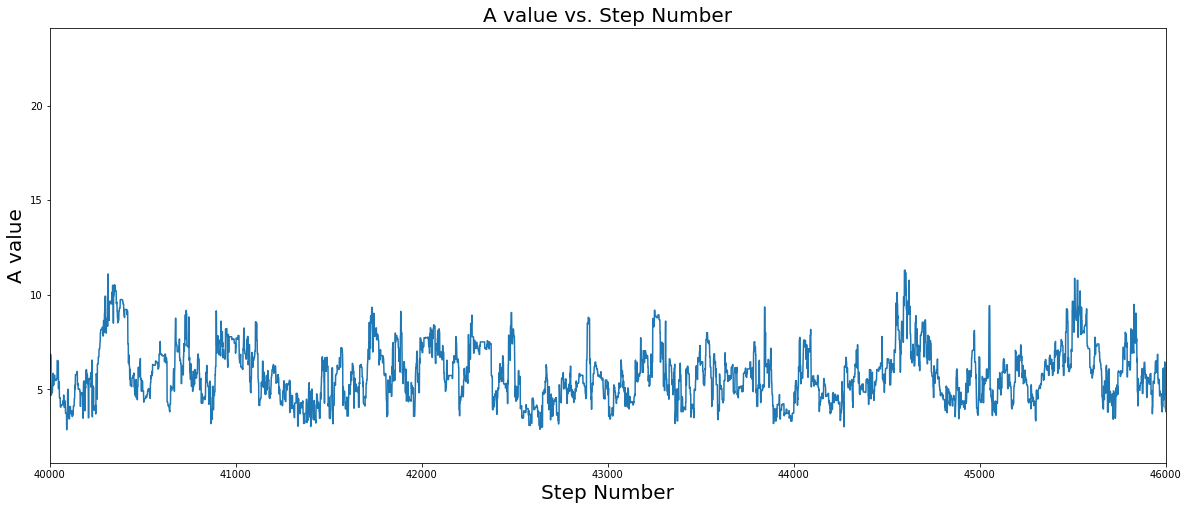

In [135]:
plt.figure(figsize=(20,8))
plt.plot(emcee_trace[:,0])
plt.xlim(40000, 46000)
plt.title("A value vs. Step Number", fontsize=20)
plt.xlabel("Step Number",fontsize=20)
plt.ylabel("A value",fontsize=20)
plt.show()

MEK: Let's burn in ~5000 (we probably only need around 2000, but we're going to be safe $\ddot\smile$)

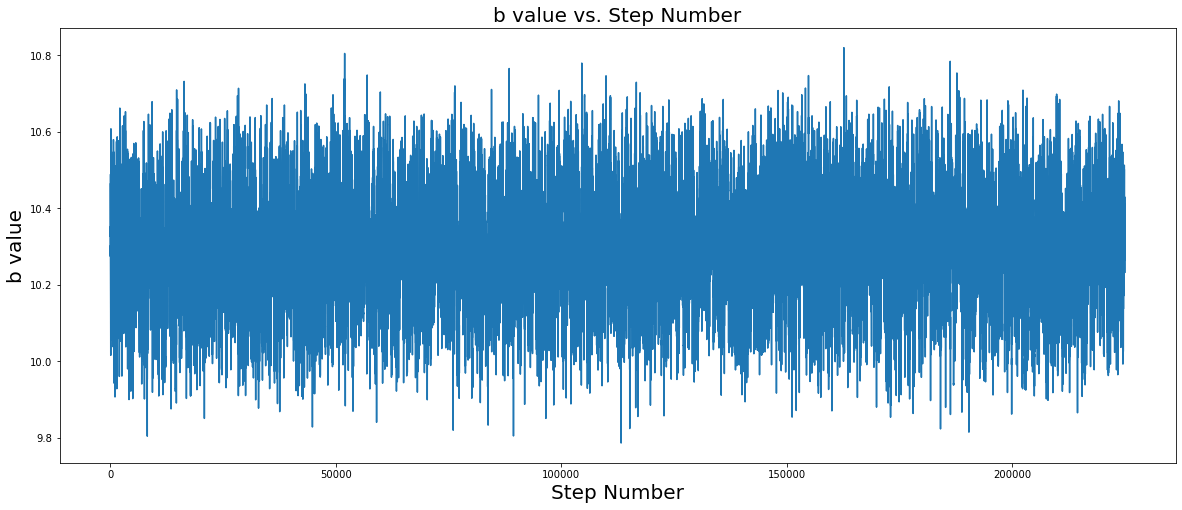

In [136]:
plt.figure(figsize=(20,8))
plt.plot(emcee_trace[:,1])
plt.title("b value vs. Step Number", fontsize=20)
plt.xlabel("Step Number",fontsize=20)
plt.ylabel("b value",fontsize=20)
plt.show()

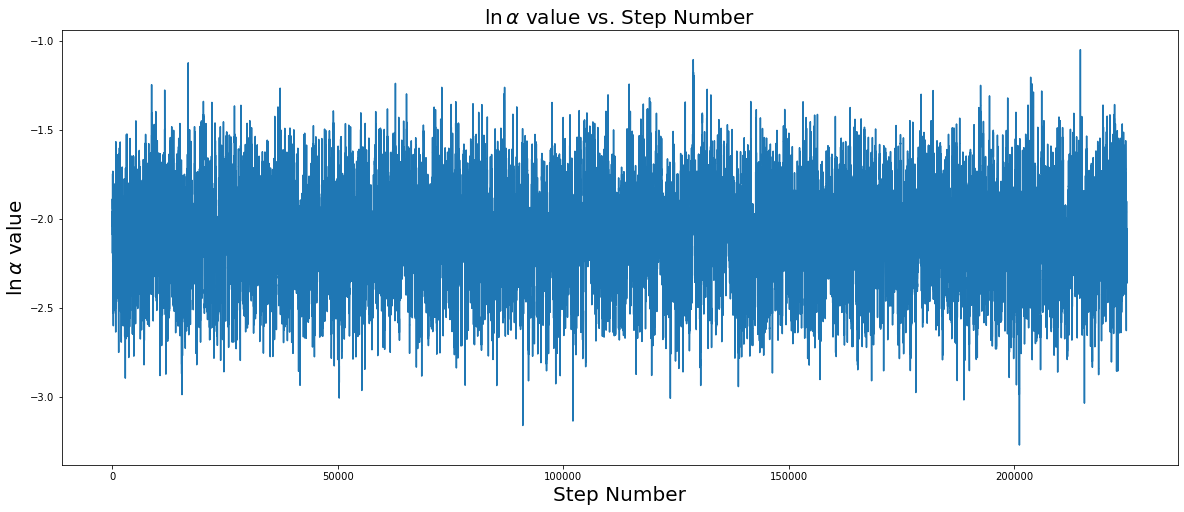

In [137]:
plt.figure(figsize=(20,8))
plt.plot(emcee_trace[:,2])
plt.title(r"$\ln\alpha$ value vs. Step Number", fontsize=20)
plt.xlabel("Step Number",fontsize=20)
plt.ylabel(r"$\ln\alpha$ value",fontsize=20)
plt.show()

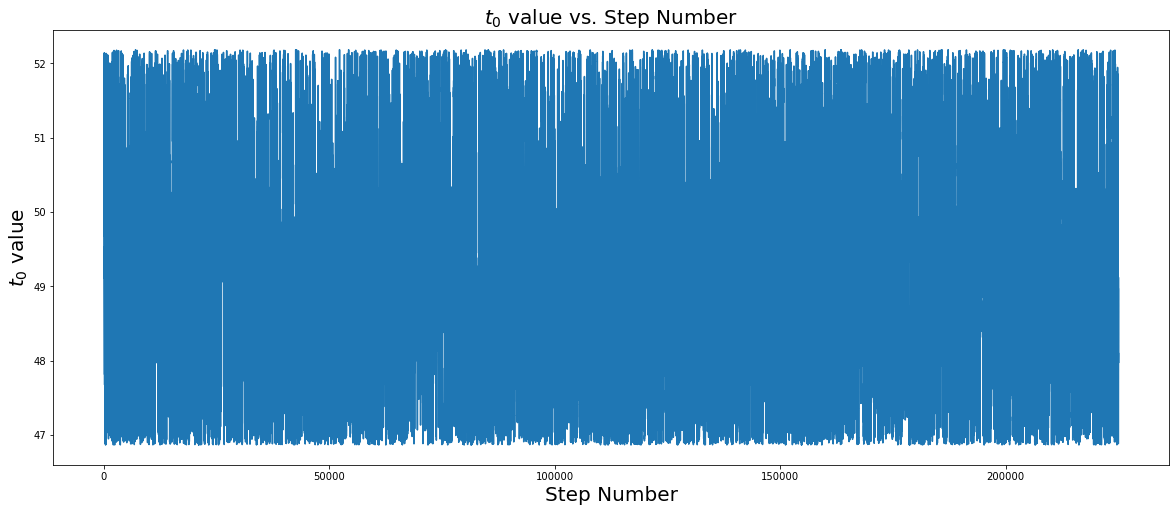

In [139]:
plt.figure(figsize=(20,8))
plt.plot(emcee_trace[:,3])
plt.title(r"$t_0$ value vs. Step Number", fontsize=20)
plt.xlabel("Step Number",fontsize=20)
plt.ylabel(r"$t_0$ value",fontsize=20)
plt.show()

MEK: Decide to burn in iterations, and thin by the maximum autocorrelation length found above

In [69]:
burn = 5000
emcee_trace  = sampler_emcee.chain[:, burn:, :].reshape(-1, ndim)

In [140]:
burned_chain0 = emcee_trace[:,0]
burned_chain1 = emcee_trace[:,1]
burned_chain2 = emcee_trace[:,2]
burned_chain3 = emcee_trace[:,3]

MEK: Check which autocorrelation length is the longest in each chain

In [141]:
thin0 = int(acor.acor(burned_chain0)[0])
thin1 = int(acor.acor(burned_chain1)[0])
thin2 = int(acor.acor(burned_chain2)[0])
thin3 = int(acor.acor(burned_chain3)[0])

print("0th Chain", thin0)
print("1st Chain", thin1)
print("2nd Chain", thin2)
print("3rd Chain", thin3)

0th Chain 95
1st Chain 79
2nd Chain 73
3rd Chain 78


In [105]:
thin = thin0

thinned_chain0 = burned_chain0[::thin]
thinned_chain1 = burned_chain1[::thin]
thinned_chain2 = burned_chain2[::thin]
thinned_chain3 = burned_chain3[::thin]

burn_thin_chain = np.vstack([thinned_chain0, thinned_chain1, thinned_chain2, thinned_chain3]).T

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

MEK: Plot corner plot with labels and quantiles

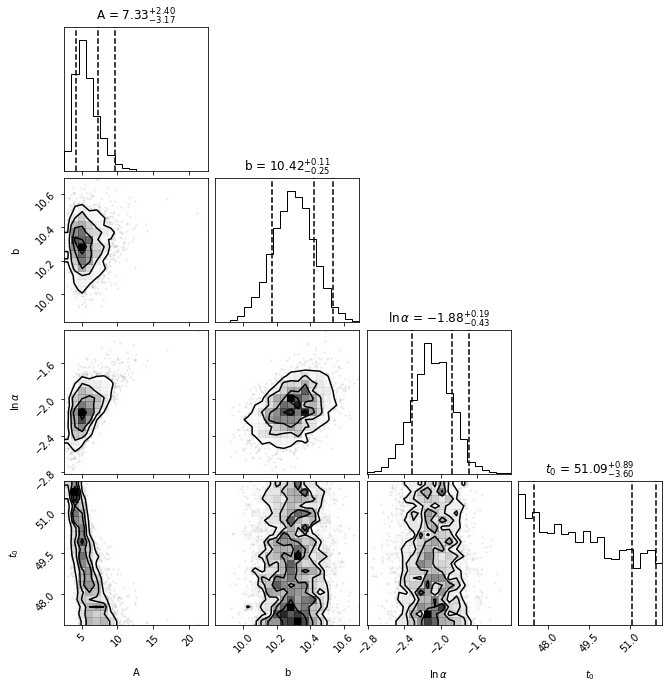

In [118]:
corner(burn_thin_chain, titles=["A","b", r"$\ln\alpha$", r"$t_0$"], show_titles=True, labels=["A","b", r"$\ln\alpha$", r"$t_0$"], \
              quantiles=[0.16, 0.84, 0.975]);

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ same-colored burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

MEK: Grab 100 random indices from the length of the burned and thinned chains and define a time array for plotting

In [119]:
idx = np.random.randint(0, len(burn_thin_chain), size=100)
t = np.linspace(0, 100, 100)

MEK: Plot data and each curve that corresponds to each of the random indices that we just picked. Plot with transparency set to 0.1 to see all the suggested solutions simultaneously

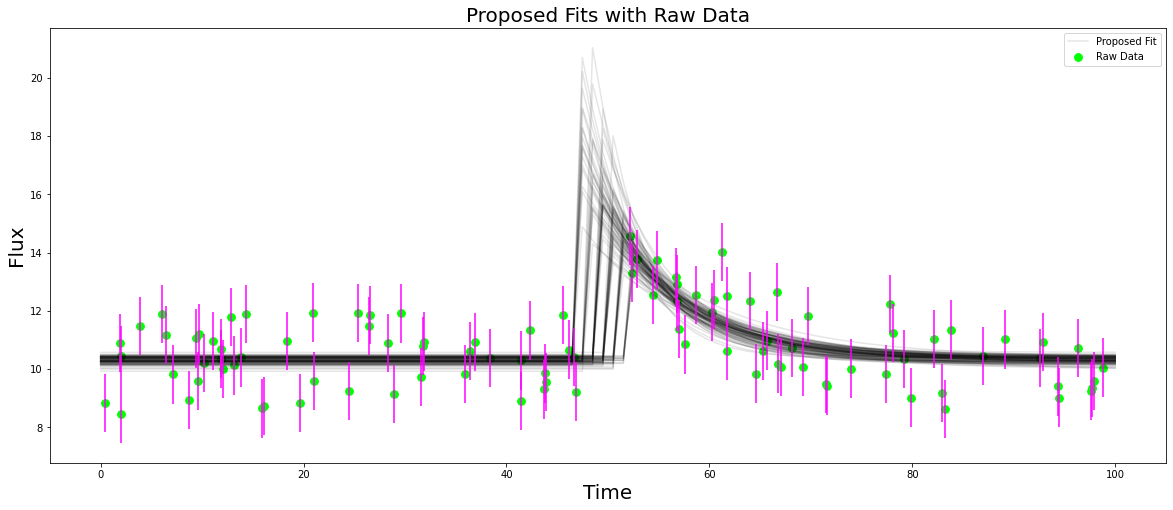

In [148]:
plt.figure(figsize=(20,8))

for i in idx:
    plt.plot(t, burst(t, burn_thin_chain[i,0], burn_thin_chain[i,1], burn_thin_chain[i,2], burn_thin_chain[i,3]), color="black", alpha=0.1)

# MEK plot one of the curves outside of the loop so that we can label the curves without having 100 entries in our legend
plt.plot(t, burst(t, burn_thin_chain[0,0], burn_thin_chain[0,1], burn_thin_chain[0,2], burn_thin_chain[0,3]), color="black", alpha=0.1, label="Proposed Fit")
plt.errorbar(time, flux, yerr=uncert, color="magenta", fmt="none")
plt.scatter(time, flux, color="lime", s=60, label="Raw Data")

plt.title("Proposed Fits with Raw Data", fontsize=20)
plt.xlabel("Time", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.legend()
plt.show()

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

MEK: Define Gaussian function. Grab likelihood and prior examples from Steve T. in Lecture 12 and edit them to fit the priors that we need. The likelihood is defined by the Gaussian function, and the prior is similar to earlier questions but with the new cube format used by ultranest

In [121]:
def gaussian_Q7(t, A, b, lnsigma, t0):
    sigma = np.e**lnsigma
    y_array = np.zeros(len(t))
    y_array[np.where(t<t0)] = b
    y_array[np.where(t>=t0)] = b + (A*(np.e**((-(t[np.where(t>=t0)]-t0)**2)/(2*sigma**2))))
    return y_array

def my_likelihood(params):
    burst, background, decay, epoch= params
    decay = np.e**decay
    y_model = np.zeros(len(t))
    y_model[np.where(t<epoch)] = background
    y_model[np.where(t>=epoch)] = background + (burst*(np.e**((-(t[np.where(t>=epoch)]-epoch)**2)/(2*decay**2))))
    #y_model = background + (burst*(np.e**((-(t-epoch)**2)/(2*decay**2))))
    like = -0.5 * (((y_model - flux)/uncert)**2).sum()
    return like

def my_prior_transform(cube):
    params = cube.copy()

    # transform location parameter: uniform prior
    lo = 0
    hi = 50
    params[0] = cube[0] * (hi - lo) + lo

    # transform location parameter: uniform prior
    lo = 0
    hi = 50
    params[1] = cube[1] * (hi - lo) + lo

    # transform amplitude parameter: log-uniform prior
    lo = -2
    hi = 2
    params[2] = cube[2] * (hi - lo) + lo

    #lo = np.e**(-2)
    #hi = np.e**(2)
    #params[2] = np.e**(cube[2] * (np.log(hi) - np.log(lo)) + np.log(lo))

    # transform location parameter: uniform prior
    lo = 0
    hi = 100
    params[3] = cube[3] * (hi - lo) + lo

    return params

MEK: Define parameter names and give ultranest the Gaussian likelihood and prior, let it fit and plot the results

DEBUG:ultranest:ReactiveNestedSampler: dims=4+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


[ultranest] Sampling 400 live points from prior ...


INFO:ultranest:Sampling 400 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=400, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 400.0), (inf, 400.0)]


Z=-inf(0.00%) | Like=-83316.07..-108.03 [-83316.0652..-12607.9442] | it/evals=0/401 eff=0.0000% N=400 

DEBUG:ultranest:iteration=0, ncalls=401, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-83316.07, Lmax=-108.03


Z=-63189.6(0.00%) | Like=-63083.74..-92.55 [-83316.0652..-12607.9442] | it/evals=40/444 eff=90.9091% N=400 

DEBUG:ultranest:iteration=40, ncalls=444, regioncalls=1760, ndraw=40, logz=-63189.55, remainder_fraction=100.0000%, Lmin=-63083.74, Lmax=-92.55


Z=-50452.8(0.00%) | Like=-49505.79..-92.55 [-83316.0652..-12607.9442] | it/evals=80/489 eff=89.8876% N=400 

DEBUG:ultranest:iteration=80, ncalls=489, regioncalls=3560, ndraw=40, logz=-50452.77, remainder_fraction=100.0000%, Lmin=-49505.79, Lmax=-92.55


Z=-40132.7(0.00%) | Like=-40045.87..-92.55 [-83316.0652..-12607.9442] | it/evals=120/544 eff=83.3333% N=400 

DEBUG:ultranest:iteration=120, ncalls=544, regioncalls=5760, ndraw=40, logz=-40132.66, remainder_fraction=100.0000%, Lmin=-40045.87, Lmax=-92.55


Z=-31092.7(0.00%) | Like=-30874.83..-92.55 [-83316.0652..-12607.9442] | it/evals=160/598 eff=80.8081% N=400 

DEBUG:ultranest:iteration=160, ncalls=598, regioncalls=7920, ndraw=40, logz=-31092.72, remainder_fraction=100.0000%, Lmin=-30874.83, Lmax=-92.55


Z=-28004.5(0.00%) | Like=-27788.43..-92.55 [-83316.0652..-12607.9442] | it/evals=180/627 eff=79.2952% N=400 

DEBUG:ultranest:iteration=180, ncalls=627, regioncalls=9080, ndraw=40, logz=-28004.53, remainder_fraction=100.0000%, Lmin=-27788.43, Lmax=-92.55


Z=-23814.0(0.00%) | Like=-23795.30..-92.55 [-83316.0652..-12607.9442] | it/evals=200/654 eff=78.7402% N=400 

DEBUG:ultranest:iteration=200, ncalls=654, regioncalls=10160, ndraw=40, logz=-23814.00, remainder_fraction=100.0000%, Lmin=-23795.30, Lmax=-92.55


Z=-17897.1(0.00%) | Like=-17842.18..-92.55 [-83316.0652..-12607.9442] | it/evals=240/714 eff=76.4331% N=400 

DEBUG:ultranest:iteration=240, ncalls=714, regioncalls=12560, ndraw=40, logz=-17897.06, remainder_fraction=100.0000%, Lmin=-17842.18, Lmax=-92.55


Z=-14156.9(0.00%) | Like=-14146.88..-92.55 [-83316.0652..-12607.9442] | it/evals=270/757 eff=75.6303% N=400 

DEBUG:ultranest:iteration=270, ncalls=757, regioncalls=14280, ndraw=40, logz=-14156.88, remainder_fraction=100.0000%, Lmin=-14146.88, Lmax=-92.55


Z=-13491.9(0.00%) | Like=-13431.52..-92.55 [-83316.0652..-12607.9442] | it/evals=280/774 eff=74.8663% N=400 

DEBUG:ultranest:iteration=280, ncalls=774, regioncalls=14960, ndraw=40, logz=-13491.90, remainder_fraction=100.0000%, Lmin=-13431.52, Lmax=-92.55


Z=-10394.5(0.00%) | Like=-10233.21..-92.55 [-12440.6670..-3257.7842] | it/evals=320/821 eff=76.0095% N=400 

DEBUG:ultranest:iteration=320, ncalls=821, regioncalls=16840, ndraw=40, logz=-10394.55, remainder_fraction=100.0000%, Lmin=-10233.21, Lmax=-92.55


Z=-7635.3(0.00%) | Like=-7538.61..-92.55 [-12440.6670..-3257.7842] | it/evals=360/867 eff=77.0878% N=400 

DEBUG:ultranest:iteration=360, ncalls=867, regioncalls=18680, ndraw=40, logz=-7635.27, remainder_fraction=100.0000%, Lmin=-7538.61, Lmax=-92.55


Z=-5459.1(0.00%) | Like=-5416.49..-92.55 [-12440.6670..-3257.7842] | it/evals=400/916 eff=77.5194% N=400 

DEBUG:ultranest:iteration=400, ncalls=916, regioncalls=20640, ndraw=40, logz=-5459.11, remainder_fraction=100.0000%, Lmin=-5416.49, Lmax=-92.55


Z=-4686.5(0.00%) | Like=-4678.26..-92.55 [-12440.6670..-3257.7842] | it/evals=440/976 eff=76.3889% N=400 

DEBUG:ultranest:iteration=440, ncalls=976, regioncalls=23040, ndraw=40, logz=-4686.51, remainder_fraction=100.0000%, Lmin=-4678.26, Lmax=-92.55


Z=-4592.5(0.00%) | Like=-4564.11..-87.10 [-12440.6670..-3257.7842] | it/evals=450/990 eff=76.2712% N=400 

DEBUG:ultranest:iteration=450, ncalls=990, regioncalls=23600, ndraw=40, logz=-4592.53, remainder_fraction=100.0000%, Lmin=-4564.11, Lmax=-87.10


Z=-4133.2(0.00%) | Like=-4125.19..-87.10 [-12440.6670..-3257.7842] | it/evals=480/1027 eff=76.5550% N=400 

DEBUG:ultranest:iteration=480, ncalls=1027, regioncalls=25080, ndraw=40, logz=-4133.24, remainder_fraction=100.0000%, Lmin=-4125.19, Lmax=-87.10


Z=-3609.6(0.00%) | Like=-3582.90..-87.10 [-12440.6670..-3257.7842] | it/evals=520/1100 eff=74.2857% N=400 

DEBUG:ultranest:iteration=520, ncalls=1100, regioncalls=28000, ndraw=40, logz=-3609.57, remainder_fraction=100.0000%, Lmin=-3582.90, Lmax=-87.10


Z=-3248.0(0.00%) | Like=-3240.14..-86.88 [-3240.6284..-1231.6093] | it/evals=560/1158 eff=73.8786% N=400 

DEBUG:ultranest:iteration=560, ncalls=1158, regioncalls=30320, ndraw=40, logz=-3248.02, remainder_fraction=100.0000%, Lmin=-3240.14, Lmax=-86.88


Z=-2703.8(0.00%) | Like=-2693.02..-86.88 [-3240.6284..-1231.6093] | it/evals=600/1215 eff=73.6196% N=400 

DEBUG:ultranest:iteration=600, ncalls=1215, regioncalls=32600, ndraw=40, logz=-2703.83, remainder_fraction=100.0000%, Lmin=-2693.02, Lmax=-86.88


Z=-2354.6(0.00%) | Like=-2343.26..-86.88 [-3240.6284..-1231.6093] | it/evals=640/1296 eff=71.4286% N=400 

DEBUG:ultranest:iteration=640, ncalls=1296, regioncalls=35840, ndraw=40, logz=-2354.61, remainder_fraction=100.0000%, Lmin=-2343.26, Lmax=-86.88


Z=-2050.4(0.00%) | Like=-2035.11..-86.88 [-3240.6284..-1231.6093] | it/evals=680/1363 eff=70.6127% N=400 

DEBUG:ultranest:iteration=680, ncalls=1363, regioncalls=38520, ndraw=40, logz=-2050.45, remainder_fraction=100.0000%, Lmin=-2035.11, Lmax=-86.88


Z=-1797.5(0.00%) | Like=-1786.88..-86.88 [-3240.6284..-1231.6093] | it/evals=720/1467 eff=67.4789% N=400 

DEBUG:ultranest:iteration=720, ncalls=1467, regioncalls=42680, ndraw=40, logz=-1797.51, remainder_fraction=100.0000%, Lmin=-1786.88, Lmax=-86.88


Z=-1561.4(0.00%) | Like=-1551.77..-86.88 [-3240.6284..-1231.6093] | it/evals=760/1543 eff=66.4917% N=400 

DEBUG:ultranest:iteration=760, ncalls=1543, regioncalls=45720, ndraw=40, logz=-1561.38, remainder_fraction=100.0000%, Lmin=-1551.77, Lmax=-86.88


Z=-1364.5(0.00%) | Like=-1356.58..-86.47 [-3240.6284..-1231.6093] | it/evals=800/1613 eff=65.9522% N=400 

DEBUG:ultranest:iteration=800, ncalls=1613, regioncalls=48520, ndraw=40, logz=-1364.51, remainder_fraction=100.0000%, Lmin=-1356.58, Lmax=-86.47


Z=-1216.0(0.00%) | Like=-1203.54..-86.47 [-1229.1473..-517.8030] | it/evals=840/1693 eff=64.9652% N=400 

DEBUG:ultranest:iteration=840, ncalls=1693, regioncalls=51720, ndraw=40, logz=-1215.95, remainder_fraction=100.0000%, Lmin=-1203.54, Lmax=-86.47


Z=-1040.1(0.00%) | Like=-1029.08..-86.47 [-1229.1473..-517.8030] | it/evals=880/1769 eff=64.2805% N=400 

DEBUG:ultranest:iteration=880, ncalls=1769, regioncalls=54760, ndraw=40, logz=-1040.13, remainder_fraction=100.0000%, Lmin=-1029.08, Lmax=-86.47


Z=-982.7(0.00%) | Like=-971.18..-86.47 [-1229.1473..-517.8030] | it/evals=900/1820 eff=63.3803% N=400 

DEBUG:ultranest:iteration=900, ncalls=1820, regioncalls=56800, ndraw=40, logz=-982.73, remainder_fraction=100.0000%, Lmin=-971.18, Lmax=-86.47


Z=-917.9(0.00%) | Like=-909.28..-86.47 [-1229.1473..-517.8030] | it/evals=920/1859 eff=63.0569% N=400 

DEBUG:ultranest:iteration=920, ncalls=1859, regioncalls=58360, ndraw=40, logz=-917.91, remainder_fraction=100.0000%, Lmin=-909.28, Lmax=-86.47


Z=-808.9(0.00%) | Like=-801.15..-86.47 [-1229.1473..-517.8030] | it/evals=960/1925 eff=62.9508% N=400 

DEBUG:ultranest:iteration=960, ncalls=1925, regioncalls=61000, ndraw=40, logz=-808.94, remainder_fraction=100.0000%, Lmin=-801.15, Lmax=-86.47


Z=-719.9(0.00%) | Like=-707.63..-86.47 [-1229.1473..-517.8030] | it/evals=1000/2015 eff=61.9195% N=400 

DEBUG:ultranest:iteration=1000, ncalls=2015, regioncalls=64600, ndraw=40, logz=-719.90, remainder_fraction=100.0000%, Lmin=-707.63, Lmax=-86.47


Z=-651.3(0.00%) | Like=-637.61..-86.47 [-1229.1473..-517.8030] | it/evals=1040/2108 eff=60.8899% N=400 

DEBUG:ultranest:iteration=1040, ncalls=2108, regioncalls=68320, ndraw=40, logz=-651.28, remainder_fraction=100.0000%, Lmin=-637.61, Lmax=-86.47


Z=-572.1(0.00%) | Like=-562.19..-86.47 [-1229.1473..-517.8030] | it/evals=1080/2203 eff=59.9002% N=400 

DEBUG:ultranest:iteration=1080, ncalls=2203, regioncalls=72120, ndraw=40, logz=-572.11, remainder_fraction=100.0000%, Lmin=-562.19, Lmax=-86.47


Z=-521.7(0.00%) | Like=-509.26..-86.47 [-517.5006..-264.4546] | it/evals=1120/2312 eff=58.5774% N=400 

DEBUG:ultranest:iteration=1120, ncalls=2312, regioncalls=76520, ndraw=40, logz=-521.67, remainder_fraction=100.0000%, Lmin=-509.26, Lmax=-86.47


Z=-468.5(0.00%) | Like=-458.17..-86.47 [-517.5006..-264.4546] | it/evals=1160/2419 eff=57.4542% N=400 

DEBUG:ultranest:iteration=1160, ncalls=2419, regioncalls=80800, ndraw=40, logz=-468.55, remainder_fraction=100.0000%, Lmin=-458.17, Lmax=-86.47


Z=-457.8(0.00%) | Like=-448.19..-86.47 [-517.5006..-264.4546] | it/evals=1170/2462 eff=56.7410% N=400 

DEBUG:ultranest:iteration=1170, ncalls=2462, regioncalls=82520, ndraw=40, logz=-457.85, remainder_fraction=100.0000%, Lmin=-448.19, Lmax=-86.47


Z=-429.4(0.00%) | Like=-418.58..-86.47 [-517.5006..-264.4546] | it/evals=1200/2539 eff=56.1010% N=400 

DEBUG:ultranest:iteration=1200, ncalls=2539, regioncalls=85600, ndraw=40, logz=-429.44, remainder_fraction=100.0000%, Lmin=-418.58, Lmax=-86.47


Z=-393.3(0.00%) | Like=-384.69..-82.53 [-517.5006..-264.4546] | it/evals=1240/2623 eff=55.7805% N=400 

DEBUG:ultranest:iteration=1240, ncalls=2623, regioncalls=89000, ndraw=40, logz=-393.28, remainder_fraction=100.0000%, Lmin=-384.69, Lmax=-82.53


Z=-349.0(0.00%) | Like=-340.01..-81.86 [-517.5006..-264.4546] | it/evals=1280/2768 eff=54.0541% N=400 

DEBUG:ultranest:iteration=1280, ncalls=2768, regioncalls=94800, ndraw=40, logz=-349.03, remainder_fraction=100.0000%, Lmin=-340.01, Lmax=-81.86


Z=-315.6(0.00%) | Like=-307.24..-81.86 [-517.5006..-264.4546] | it/evals=1320/2902 eff=52.7578% N=400 

DEBUG:ultranest:iteration=1320, ncalls=2902, regioncalls=100160, ndraw=40, logz=-315.56, remainder_fraction=100.0000%, Lmin=-307.24, Lmax=-81.86


Z=-297.0(0.00%) | Like=-288.21..-81.86 [-517.5006..-264.4546] | it/evals=1350/2980 eff=52.3256% N=400 

DEBUG:ultranest:iteration=1350, ncalls=2980, regioncalls=103280, ndraw=40, logz=-297.00, remainder_fraction=100.0000%, Lmin=-288.21, Lmax=-81.86


Z=-291.2(0.00%) | Like=-282.74..-81.86 [-517.5006..-264.4546] | it/evals=1360/3002 eff=52.2675% N=400 

DEBUG:ultranest:iteration=1360, ncalls=3002, regioncalls=104200, ndraw=40, logz=-291.22, remainder_fraction=100.0000%, Lmin=-282.74, Lmax=-81.86


Z=-261.7(0.00%) | Like=-252.68..-81.86 [-263.9972..-160.2609] | it/evals=1400/3087 eff=52.1027% N=400 

DEBUG:ultranest:iteration=1400, ncalls=3087, regioncalls=107600, ndraw=40, logz=-261.72, remainder_fraction=100.0000%, Lmin=-252.68, Lmax=-81.86


Z=-245.0(0.00%) | Like=-236.77..-81.86 [-263.9972..-160.2609] | it/evals=1440/3194 eff=51.5390% N=400 

DEBUG:ultranest:iteration=1440, ncalls=3194, regioncalls=111880, ndraw=40, logz=-244.97, remainder_fraction=100.0000%, Lmin=-236.77, Lmax=-81.86


Z=-226.1(0.00%) | Like=-215.93..-81.86 [-263.9972..-160.2609] | it/evals=1480/3316 eff=50.7545% N=400 

DEBUG:ultranest:iteration=1480, ncalls=3316, regioncalls=116960, ndraw=40, logz=-226.05, remainder_fraction=100.0000%, Lmin=-215.93, Lmax=-81.86


Z=-209.4(0.00%) | Like=-200.75..-81.86 [-263.9972..-160.2609] | it/evals=1520/3446 eff=49.9015% N=400 

DEBUG:ultranest:iteration=1520, ncalls=3446, regioncalls=122160, ndraw=40, logz=-209.45, remainder_fraction=100.0000%, Lmin=-200.75, Lmax=-81.86


Z=-197.0(0.00%) | Like=-188.32..-81.86 [-263.9972..-160.2609] | it/evals=1560/3565 eff=49.2891% N=400 

DEBUG:ultranest:iteration=1560, ncalls=3565, regioncalls=126920, ndraw=40, logz=-197.02, remainder_fraction=100.0000%, Lmin=-188.32, Lmax=-81.86


Z=-184.8(0.00%) | Like=-175.77..-81.86 [-263.9972..-160.2609] | it/evals=1600/3716 eff=48.2509% N=400 

DEBUG:ultranest:iteration=1600, ncalls=3716, regioncalls=132960, ndraw=40, logz=-184.76, remainder_fraction=100.0000%, Lmin=-175.77, Lmax=-81.86


Z=-179.5(0.00%) | Like=-169.96..-81.86 [-263.9972..-160.2609] | it/evals=1620/3817 eff=47.4100% N=400 

DEBUG:ultranest:iteration=1620, ncalls=3817, regioncalls=137000, ndraw=40, logz=-179.47, remainder_fraction=100.0000%, Lmin=-169.96, Lmax=-81.86


Z=-172.1(0.00%) | Like=-162.82..-81.86 [-263.9972..-160.2609] | it/evals=1640/3869 eff=47.2759% N=400 

DEBUG:ultranest:iteration=1640, ncalls=3869, regioncalls=139120, ndraw=40, logz=-172.08, remainder_fraction=100.0000%, Lmin=-162.82, Lmax=-81.86


Z=-162.3(0.00%) | Like=-153.34..-81.86 [-160.2192..-118.1901] | it/evals=1680/3979 eff=46.9405% N=400 

DEBUG:ultranest:iteration=1680, ncalls=3979, regioncalls=143520, ndraw=40, logz=-162.27, remainder_fraction=100.0000%, Lmin=-153.34, Lmax=-81.86


Z=-157.1(0.00%) | Like=-148.37..-81.86 [-160.2192..-118.1901] | it/evals=1710/4083 eff=46.4295% N=400 

DEBUG:ultranest:iteration=1710, ncalls=4083, regioncalls=147680, ndraw=40, logz=-157.13, remainder_fraction=100.0000%, Lmin=-148.37, Lmax=-81.86


Z=-154.9(0.00%) | Like=-146.15..-81.86 [-160.2192..-118.1901] | it/evals=1720/4117 eff=46.2739% N=400 

DEBUG:ultranest:iteration=1720, ncalls=4117, regioncalls=149120, ndraw=40, logz=-154.95, remainder_fraction=100.0000%, Lmin=-146.15, Lmax=-81.86


Z=-146.8(0.00%) | Like=-138.11..-81.78 [-160.2192..-118.1901] | it/evals=1760/4300 eff=45.1282% N=400 

DEBUG:ultranest:iteration=1760, ncalls=4300, regioncalls=156440, ndraw=40, logz=-146.85, remainder_fraction=100.0000%, Lmin=-138.11, Lmax=-81.78


Z=-141.0(0.00%) | Like=-132.58..-81.78 [-160.2192..-118.1901] | it/evals=1800/4458 eff=44.3568% N=400 

DEBUG:ultranest:iteration=1800, ncalls=4458, regioncalls=162840, ndraw=40, logz=-140.98, remainder_fraction=100.0000%, Lmin=-132.58, Lmax=-81.78


Z=-136.7(0.00%) | Like=-127.84..-81.78 [-160.2192..-118.1901] | it/evals=1840/4595 eff=43.8617% N=400 

DEBUG:ultranest:iteration=1840, ncalls=4595, regioncalls=168320, ndraw=40, logz=-136.68, remainder_fraction=100.0000%, Lmin=-127.84, Lmax=-81.78


Z=-131.4(0.00%) | Like=-122.53..-81.78 [-160.2192..-118.1901] | it/evals=1880/4740 eff=43.3180% N=400 

DEBUG:ultranest:iteration=1880, ncalls=4740, regioncalls=174120, ndraw=40, logz=-131.42, remainder_fraction=100.0000%, Lmin=-122.53, Lmax=-81.78


Z=-127.5(0.00%) | Like=-119.16..-81.78 [-160.2192..-118.1901] | it/evals=1920/4860 eff=43.0493% N=400 

DEBUG:ultranest:iteration=1920, ncalls=4860, regioncalls=178920, ndraw=40, logz=-127.46, remainder_fraction=100.0000%, Lmin=-119.16, Lmax=-81.78


Z=-124.0(0.00%) | Like=-115.95..-81.78 [-117.9941..-99.5213] | it/evals=1960/4994 eff=42.6643% N=400 

DEBUG:ultranest:iteration=1960, ncalls=4994, regioncalls=184280, ndraw=40, logz=-124.05, remainder_fraction=100.0000%, Lmin=-115.95, Lmax=-81.78


Z=-122.4(0.00%) | Like=-113.68..-81.78 [-117.9941..-99.5213] | it/evals=1980/5081 eff=42.2987% N=400 

DEBUG:ultranest:iteration=1980, ncalls=5081, regioncalls=187760, ndraw=40, logz=-122.45, remainder_fraction=100.0000%, Lmin=-113.68, Lmax=-81.78


Z=-119.8(0.00%) | Like=-110.77..-81.78 [-117.9941..-99.5213] | it/evals=2000/5159 eff=42.0256% N=400 

DEBUG:ultranest:iteration=2000, ncalls=5159, regioncalls=190920, ndraw=40, logz=-119.82, remainder_fraction=100.0000%, Lmin=-110.77, Lmax=-81.78


Z=-116.8(0.00%) | Like=-108.39..-75.11 [-117.9941..-99.5213] | it/evals=2040/5333 eff=41.3541% N=400 

DEBUG:ultranest:iteration=2040, ncalls=5333, regioncalls=197880, ndraw=40, logz=-116.77, remainder_fraction=100.0000%, Lmin=-108.39, Lmax=-75.11


Z=-114.6(0.00%) | Like=-105.87..-75.11 [-117.9941..-99.5213] | it/evals=2070/5442 eff=41.0551% N=400 

DEBUG:ultranest:iteration=2070, ncalls=5442, regioncalls=202280, ndraw=40, logz=-114.58, remainder_fraction=100.0000%, Lmin=-105.87, Lmax=-75.11


Z=-113.9(0.00%) | Like=-105.32..-75.11 [-117.9941..-99.5213] | it/evals=2080/5494 eff=40.8324% N=400 

DEBUG:ultranest:iteration=2080, ncalls=5494, regioncalls=204440, ndraw=40, logz=-113.86, remainder_fraction=100.0000%, Lmin=-105.32, Lmax=-75.11


Z=-111.7(0.00%) | Like=-103.26..-75.11 [-117.9941..-99.5213] | it/evals=2120/5628 eff=40.5509% N=400 

DEBUG:ultranest:iteration=2120, ncalls=5628, regioncalls=209800, ndraw=40, logz=-111.67, remainder_fraction=100.0000%, Lmin=-103.26, Lmax=-75.11


Z=-109.9(0.00%) | Like=-101.58..-75.11 [-117.9941..-99.5213] | it/evals=2160/5768 eff=40.2385% N=400 

DEBUG:ultranest:iteration=2160, ncalls=5768, regioncalls=215400, ndraw=40, logz=-109.89, remainder_fraction=100.0000%, Lmin=-101.58, Lmax=-75.11


Z=-108.0(0.00%) | Like=-99.62..-75.11 [-117.9941..-99.5213] | it/evals=2200/5950 eff=39.6396% N=400 

DEBUG:ultranest:iteration=2200, ncalls=5950, regioncalls=222680, ndraw=40, logz=-108.01, remainder_fraction=100.0000%, Lmin=-99.62, Lmax=-75.11


Z=-106.2(0.00%) | Like=-97.83..-75.11 [-99.5164..-91.0125] | it/evals=2240/6149 eff=38.9633% N=400 

DEBUG:ultranest:iteration=2240, ncalls=6149, regioncalls=230720, ndraw=40, logz=-106.21, remainder_fraction=100.0000%, Lmin=-97.83, Lmax=-75.11


Z=-104.7(0.00%) | Like=-96.38..-75.11 [-99.5164..-91.0125] | it/evals=2280/6337 eff=38.4032% N=400 

DEBUG:ultranest:iteration=2280, ncalls=6337, regioncalls=238280, ndraw=40, logz=-104.69, remainder_fraction=100.0000%, Lmin=-96.38, Lmax=-75.11


Z=-103.2(0.00%) | Like=-94.63..-75.11 [-99.5164..-91.0125] | it/evals=2320/6558 eff=37.6746% N=400 

DEBUG:ultranest:iteration=2320, ncalls=6558, regioncalls=247200, ndraw=40, logz=-103.17, remainder_fraction=100.0000%, Lmin=-94.63, Lmax=-75.11


Z=-101.8(0.00%) | Like=-93.37..-68.25 [-99.5164..-91.0125] | it/evals=2360/6789 eff=36.9385% N=400 

DEBUG:ultranest:iteration=2360, ncalls=6789, regioncalls=256440, ndraw=40, logz=-101.77, remainder_fraction=100.0000%, Lmin=-93.37, Lmax=-68.25


Z=-100.8(0.00%) | Like=-92.64..-68.25 [-99.5164..-91.0125] | it/evals=2400/7077 eff=35.9443% N=400 

DEBUG:ultranest:iteration=2400, ncalls=7077, regioncalls=268120, ndraw=40, logz=-100.82, remainder_fraction=100.0000%, Lmin=-92.64, Lmax=-68.25


Z=-99.9(0.00%) | Like=-91.70..-68.25 [-99.5164..-91.0125] | it/evals=2440/7345 eff=35.1332% N=400 

DEBUG:ultranest:iteration=2440, ncalls=7345, regioncalls=278840, ndraw=40, logz=-99.94, remainder_fraction=100.0000%, Lmin=-91.70, Lmax=-68.25


Z=-99.2(0.00%) | Like=-91.08..-68.25 [-99.5164..-91.0125] | it/evals=2480/7689 eff=34.0239% N=400 

DEBUG:ultranest:iteration=2480, ncalls=7689, regioncalls=292600, ndraw=40, logz=-99.16, remainder_fraction=100.0000%, Lmin=-91.08, Lmax=-68.25
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([399,   1]))


Z=-98.5(0.00%) | Like=-90.44..-68.25 [-90.9913..-88.2654] | it/evals=2520/8006 eff=33.1317% N=400 

DEBUG:ultranest:iteration=2520, ncalls=8006, regioncalls=305480, ndraw=40, logz=-98.53, remainder_fraction=100.0000%, Lmin=-90.44, Lmax=-68.25


Z=-98.0(0.00%) | Like=-89.88..-68.25 [-90.9913..-88.2654] | it/evals=2560/8358 eff=32.1689% N=400 

DEBUG:ultranest:iteration=2560, ncalls=8358, regioncalls=319600, ndraw=40, logz=-97.97, remainder_fraction=100.0000%, Lmin=-89.88, Lmax=-68.25


Z=-97.5(0.00%) | Like=-89.45..-68.20 [-90.9913..-88.2654] | it/evals=2600/8734 eff=31.1975% N=400 

DEBUG:ultranest:iteration=2600, ncalls=8734, regioncalls=334640, ndraw=40, logz=-97.47, remainder_fraction=100.0000%, Lmin=-89.45, Lmax=-68.20


Z=-97.1(0.00%) | Like=-89.13..-68.20 [-90.9913..-88.2654] | it/evals=2640/9437 eff=29.2132% N=400 

DEBUG:ultranest:iteration=2640, ncalls=9437, regioncalls=362840, ndraw=40, logz=-97.06, remainder_fraction=100.0000%, Lmin=-89.13, Lmax=-68.20


Z=-96.7(0.00%) | Like=-88.82..-68.20 [-90.9913..-88.2654] | it/evals=2680/9883 eff=28.2611% N=400 

DEBUG:ultranest:iteration=2680, ncalls=9883, regioncalls=380720, ndraw=40, logz=-96.70, remainder_fraction=100.0000%, Lmin=-88.82, Lmax=-68.20


Z=-96.4(0.00%) | Like=-88.50..-68.20 [-90.9913..-88.2654] | it/evals=2720/10459 eff=27.0405% N=400 

DEBUG:ultranest:iteration=2720, ncalls=10459, regioncalls=404280, ndraw=40, logz=-96.39, remainder_fraction=100.0000%, Lmin=-88.50, Lmax=-68.20


Z=-96.1(0.00%) | Like=-88.25..-68.20 [-88.2630..-87.3423] | it/evals=2760/10901 eff=26.2832% N=400 

DEBUG:ultranest:iteration=2760, ncalls=10901, regioncalls=421960, ndraw=40, logz=-96.11, remainder_fraction=100.0000%, Lmin=-88.25, Lmax=-68.20


Z=-95.9(0.00%) | Like=-88.10..-68.20 [-88.2630..-87.3423] | it/evals=2790/11400 eff=25.3636% N=400 

DEBUG:ultranest:iteration=2790, ncalls=11400, regioncalls=442200, ndraw=40, logz=-95.93, remainder_fraction=100.0000%, Lmin=-88.10, Lmax=-68.20


Z=-95.9(0.00%) | Like=-88.03..-64.66 [-88.2630..-87.3423] | it/evals=2800/11549 eff=25.1144% N=400 

DEBUG:ultranest:iteration=2800, ncalls=11549, regioncalls=448560, ndraw=40, logz=-95.87, remainder_fraction=100.0000%, Lmin=-88.03, Lmax=-64.66


Z=-95.7(0.00%) | Like=-87.84..-64.66 [-88.2630..-87.3423] | it/evals=2840/12014 eff=24.4532% N=400 

DEBUG:ultranest:iteration=2840, ncalls=12014, regioncalls=468960, ndraw=40, logz=-95.65, remainder_fraction=100.0000%, Lmin=-87.84, Lmax=-64.66


Z=-95.5(0.00%) | Like=-87.72..-64.66 [-88.2630..-87.3423] | it/evals=2880/12555 eff=23.6940% N=400 

DEBUG:ultranest:iteration=2880, ncalls=12555, regioncalls=493000, ndraw=40, logz=-95.47, remainder_fraction=100.0000%, Lmin=-87.72, Lmax=-64.66


Z=-95.3(0.00%) | Like=-87.59..-64.66 [-88.2630..-87.3423] | it/evals=2920/13245 eff=22.7326% N=400 

DEBUG:ultranest:iteration=2920, ncalls=13245, regioncalls=523360, ndraw=40, logz=-95.30, remainder_fraction=100.0000%, Lmin=-87.59, Lmax=-64.66


Z=-95.2(0.00%) | Like=-87.47..-64.66 [-88.2630..-87.3423] | it/evals=2960/13895 eff=21.9340% N=400 

DEBUG:ultranest:iteration=2960, ncalls=13895, regioncalls=551560, ndraw=40, logz=-95.16, remainder_fraction=100.0000%, Lmin=-87.47, Lmax=-64.66


Z=-95.1(0.00%) | Like=-87.40..-64.66 [-88.2630..-87.3423] | it/evals=2986/14469 eff=21.2240% N=400 

DEBUG:ultranest:iteration=2986, ncalls=14469, regioncalls=576880, ndraw=40, logz=-95.08, remainder_fraction=100.0000%, Lmin=-87.40, Lmax=-64.66


Z=-95.0(0.00%) | Like=-87.38..-64.66 [-88.2630..-87.3423] | it/evals=3000/14652 eff=21.0497% N=400 

DEBUG:ultranest:iteration=3000, ncalls=14652, regioncalls=584640, ndraw=40, logz=-95.04, remainder_fraction=100.0000%, Lmin=-87.38, Lmax=-64.66


Z=-95.0(0.00%) | Like=-87.33..-64.66 [-87.3413..-86.9799] | it/evals=3030/15447 eff=20.1369% N=400 

DEBUG:ultranest:iteration=3030, ncalls=15447, regioncalls=620920, ndraw=40, logz=-94.95, remainder_fraction=100.0000%, Lmin=-87.33, Lmax=-64.66


Z=-94.9(0.00%) | Like=-87.30..-64.66 [-87.3413..-86.9799] | it/evals=3040/15601 eff=19.9987% N=400 

DEBUG:ultranest:iteration=3040, ncalls=15601, regioncalls=627520, ndraw=40, logz=-94.93, remainder_fraction=100.0000%, Lmin=-87.30, Lmax=-64.66


Z=-94.9(0.00%) | Like=-87.27..-64.66 [-87.3413..-86.9799] | it/evals=3060/16098 eff=19.4929% N=400 

DEBUG:ultranest:iteration=3060, ncalls=16098, regioncalls=648880, ndraw=40, logz=-94.88, remainder_fraction=100.0000%, Lmin=-87.27, Lmax=-64.66


Z=-94.8(0.00%) | Like=-87.24..-64.66 [-87.3413..-86.9799] | it/evals=3080/16542 eff=19.0807% N=400 

DEBUG:ultranest:iteration=3080, ncalls=16542, regioncalls=667320, ndraw=40, logz=-94.83, remainder_fraction=100.0000%, Lmin=-87.24, Lmax=-64.66


Z=-94.8(0.00%) | Like=-87.20..-64.66 [-87.3413..-86.9799] | it/evals=3112/17519 eff=18.1786% N=400 

DEBUG:ultranest:iteration=3112, ncalls=17519, regioncalls=707560, ndraw=40, logz=-94.76, remainder_fraction=100.0000%, Lmin=-87.20, Lmax=-64.66


Z=-94.7(0.00%) | Like=-87.19..-64.66 [-87.3413..-86.9799] | it/evals=3120/17723 eff=18.0107% N=400 

DEBUG:ultranest:iteration=3120, ncalls=17723, regioncalls=715880, ndraw=40, logz=-94.75, remainder_fraction=100.0000%, Lmin=-87.19, Lmax=-64.66


Z=-94.7(0.00%) | Like=-87.15..-61.27 [-87.3413..-86.9799] | it/evals=3150/18434 eff=17.4670% N=400 

DEBUG:ultranest:iteration=3150, ncalls=18434, regioncalls=745080, ndraw=40, logz=-94.69, remainder_fraction=100.0000%, Lmin=-87.15, Lmax=-61.27


Z=-94.7(0.00%) | Like=-87.14..-61.27 [-87.3413..-86.9799] | it/evals=3160/18614 eff=17.3493% N=400 

DEBUG:ultranest:iteration=3160, ncalls=18614, regioncalls=752920, ndraw=40, logz=-94.67, remainder_fraction=100.0000%, Lmin=-87.14, Lmax=-61.27


Z=-94.6(0.00%) | Like=-87.12..-61.27 [-87.3413..-86.9799] | it/evals=3194/19436 eff=16.7787% N=400 

DEBUG:ultranest:iteration=3194, ncalls=19436, regioncalls=787400, ndraw=40, logz=-94.62, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-61.27


Z=-94.6(0.00%) | Like=-87.12..-61.27 [-87.3413..-86.9799] | it/evals=3200/19630 eff=16.6407% N=400 

DEBUG:ultranest:iteration=3200, ncalls=19630, regioncalls=795440, ndraw=40, logz=-94.61, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-61.27


Z=-94.6(0.00%) | Like=-87.10..-61.27 [-87.3413..-86.9799] | it/evals=3223/20133 eff=16.3330% N=400 

DEBUG:ultranest:iteration=3223, ncalls=20133, regioncalls=815680, ndraw=40, logz=-94.58, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-61.27


Z=-94.6(0.00%) | Like=-87.10..-61.27 [-87.3413..-86.9799] | it/evals=3232/20428 eff=16.1374% N=400 

DEBUG:ultranest:iteration=3232, ncalls=20428, regioncalls=827720, ndraw=40, logz=-94.56, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-61.27


Z=-94.6(0.00%) | Like=-87.09..-61.27 [-87.3413..-86.9799] | it/evals=3240/20726 eff=15.9402% N=400 

DEBUG:ultranest:iteration=3240, ncalls=20726, regioncalls=840120, ndraw=40, logz=-94.55, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-61.27


Z=-94.5(0.00%) | Like=-87.09..-61.27 [-87.3413..-86.9799] | it/evals=3266/21247 eff=15.6665% N=400 

DEBUG:ultranest:iteration=3266, ncalls=21247, regioncalls=862480, ndraw=40, logz=-94.52, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-61.27


Z=-94.5(0.00%) | Like=-87.07..-61.27 [-87.3413..-86.9799] | it/evals=3280/21663 eff=15.4259% N=400 

DEBUG:ultranest:iteration=3280, ncalls=21663, regioncalls=879640, ndraw=40, logz=-94.50, remainder_fraction=100.0000%, Lmin=-87.07, Lmax=-61.27


Z=-94.5(0.00%) | Like=-87.01..-61.27 [-87.3413..-86.9799] | it/evals=3297/22596 eff=14.8540% N=400 

DEBUG:ultranest:iteration=3297, ncalls=22596, regioncalls=918600, ndraw=40, logz=-94.48, remainder_fraction=100.0000%, Lmin=-87.01, Lmax=-61.27


Z=-94.5(0.00%) | Like=-86.96..-61.27 [-86.9748..-85.5740] | it/evals=3320/23336 eff=14.4751% N=400 

DEBUG:ultranest:iteration=3320, ncalls=23336, regioncalls=948840, ndraw=40, logz=-94.46, remainder_fraction=100.0000%, Lmin=-86.96, Lmax=-61.27


Z=-94.4(0.00%) | Like=-86.87..-61.27 [-86.9748..-85.5740] | it/evals=3346/24143 eff=14.0926% N=400 

DEBUG:ultranest:iteration=3346, ncalls=24143, regioncalls=983480, ndraw=40, logz=-94.43, remainder_fraction=100.0000%, Lmin=-86.87, Lmax=-61.27


Z=-94.4(0.00%) | Like=-86.81..-61.27 [-86.9748..-85.5740] | it/evals=3360/24477 eff=13.9552% N=400 

DEBUG:ultranest:iteration=3360, ncalls=24477, regioncalls=997600, ndraw=40, logz=-94.41, remainder_fraction=100.0000%, Lmin=-86.81, Lmax=-61.27


Z=-94.4(0.00%) | Like=-86.72..-61.27 [-86.9748..-85.5740] | it/evals=3382/25347 eff=13.5567% N=400 

DEBUG:ultranest:iteration=3382, ncalls=25347, regioncalls=1034080, ndraw=40, logz=-94.39, remainder_fraction=100.0000%, Lmin=-86.72, Lmax=-61.27


Z=-94.4(0.00%) | Like=-86.63..-61.27 [-86.9748..-85.5740] | it/evals=3400/25969 eff=13.2974% N=400 

DEBUG:ultranest:iteration=3400, ncalls=25969, regioncalls=1060560, ndraw=40, logz=-94.37, remainder_fraction=100.0000%, Lmin=-86.63, Lmax=-61.27


Z=-94.3(0.00%) | Like=-86.53..-61.27 [-86.9748..-85.5740] | it/evals=3420/26796 eff=12.9565% N=400 

DEBUG:ultranest:iteration=3420, ncalls=26796, regioncalls=1095440, ndraw=40, logz=-94.34, remainder_fraction=100.0000%, Lmin=-86.53, Lmax=-61.27


Z=-94.3(0.00%) | Like=-86.47..-61.27 [-86.9748..-85.5740] | it/evals=3439/27709 eff=12.5929% N=400 

DEBUG:ultranest:iteration=3439, ncalls=27709, regioncalls=1134800, ndraw=40, logz=-94.32, remainder_fraction=100.0000%, Lmin=-86.47, Lmax=-61.27


Z=-94.3(0.00%) | Like=-86.47..-61.27 [-86.9748..-85.5740] | it/evals=3440/27767 eff=12.5699% N=400 

DEBUG:ultranest:iteration=3440, ncalls=27767, regioncalls=1137120, ndraw=40, logz=-94.32, remainder_fraction=100.0000%, Lmin=-86.47, Lmax=-61.27


Z=-94.3(0.00%) | Like=-86.29..-61.27 [-86.9748..-85.5740] | it/evals=3470/28699 eff=12.2619% N=400 

DEBUG:ultranest:iteration=3470, ncalls=28699, regioncalls=1176480, ndraw=40, logz=-94.28, remainder_fraction=100.0000%, Lmin=-86.29, Lmax=-61.27


Z=-94.3(0.00%) | Like=-86.22..-61.27 [-86.9748..-85.5740] | it/evals=3480/28988 eff=12.1729% N=400 

DEBUG:ultranest:iteration=3480, ncalls=28988, regioncalls=1189640, ndraw=40, logz=-94.27, remainder_fraction=100.0000%, Lmin=-86.22, Lmax=-61.27


Z=-94.3(0.00%) | Like=-86.14..-61.27 [-86.9748..-85.5740] | it/evals=3495/29910 eff=11.8434% N=400 

DEBUG:ultranest:iteration=3495, ncalls=29910, regioncalls=1230360, ndraw=40, logz=-94.25, remainder_fraction=100.0000%, Lmin=-86.14, Lmax=-61.27


Z=-94.2(0.00%) | Like=-86.04..-61.27 [-86.9748..-85.5740] | it/evals=3511/30770 eff=11.5608% N=400 

DEBUG:ultranest:iteration=3511, ncalls=30770, regioncalls=1267880, ndraw=40, logz=-94.23, remainder_fraction=100.0000%, Lmin=-86.04, Lmax=-61.27


Z=-94.2(0.00%) | Like=-86.00..-61.27 [-86.9748..-85.5740] | it/evals=3520/31152 eff=11.4464% N=400 

DEBUG:ultranest:iteration=3520, ncalls=31152, regioncalls=1283600, ndraw=40, logz=-94.22, remainder_fraction=100.0000%, Lmin=-86.00, Lmax=-61.27


Z=-94.2(0.00%) | Like=-85.85..-61.27 [-86.9748..-85.5740] | it/evals=3544/31997 eff=11.2163% N=400 

DEBUG:ultranest:iteration=3544, ncalls=31997, regioncalls=1320800, ndraw=40, logz=-94.18, remainder_fraction=100.0000%, Lmin=-85.85, Lmax=-61.27


Z=-94.2(0.00%) | Like=-85.70..-61.27 [-86.9748..-85.5740] | it/evals=3560/32846 eff=10.9721% N=400 

DEBUG:ultranest:iteration=3560, ncalls=32846, regioncalls=1358800, ndraw=40, logz=-94.16, remainder_fraction=100.0000%, Lmin=-85.70, Lmax=-61.27


Z=-94.1(0.00%) | Like=-85.55..-55.06 [-85.5731..-82.8072] | it/evals=3578/33725 eff=10.7367% N=400 

DEBUG:ultranest:iteration=3578, ncalls=33725, regioncalls=1398200, ndraw=40, logz=-94.13, remainder_fraction=100.0000%, Lmin=-85.55, Lmax=-55.06


Z=-94.1(0.00%) | Like=-85.42..-55.06 [-85.5731..-82.8072] | it/evals=3594/34629 eff=10.4999% N=400 

DEBUG:ultranest:iteration=3594, ncalls=34629, regioncalls=1436720, ndraw=40, logz=-94.10, remainder_fraction=100.0000%, Lmin=-85.42, Lmax=-55.06


Z=-94.1(0.00%) | Like=-85.35..-55.06 [-85.5731..-82.8072] | it/evals=3600/35119 eff=10.3690% N=400 

DEBUG:ultranest:iteration=3600, ncalls=35119, regioncalls=1458600, ndraw=40, logz=-94.09, remainder_fraction=100.0000%, Lmin=-85.35, Lmax=-55.06


Z=-94.1(0.00%) | Like=-85.20..-55.06 [-85.5731..-82.8072] | it/evals=3617/36045 eff=10.1473% N=400 

DEBUG:ultranest:iteration=3617, ncalls=36045, regioncalls=1500120, ndraw=40, logz=-94.06, remainder_fraction=100.0000%, Lmin=-85.20, Lmax=-55.06


Z=-94.0(0.00%) | Like=-84.99..-55.06 [-85.5731..-82.8072] | it/evals=3633/36962 eff=9.9365% N=400 

DEBUG:ultranest:iteration=3633, ncalls=36962, regioncalls=1540760, ndraw=40, logz=-94.02, remainder_fraction=100.0000%, Lmin=-84.99, Lmax=-55.06


Z=-94.0(0.00%) | Like=-84.89..-55.06 [-85.5731..-82.8072] | it/evals=3640/37542 eff=9.8002% N=400 

DEBUG:ultranest:iteration=3640, ncalls=37542, regioncalls=1567840, ndraw=40, logz=-94.00, remainder_fraction=100.0000%, Lmin=-84.89, Lmax=-55.06


Z=-94.0(0.00%) | Like=-84.79..-55.06 [-85.5731..-82.8072] | it/evals=3652/38654 eff=9.5467% N=400 

DEBUG:ultranest:iteration=3652, ncalls=38654, regioncalls=1617440, ndraw=40, logz=-93.97, remainder_fraction=100.0000%, Lmin=-84.79, Lmax=-55.06


Z=-93.9(0.00%) | Like=-84.69..-55.06 [-85.5731..-82.8072] | it/evals=3663/39582 eff=9.3487% N=400 

DEBUG:ultranest:iteration=3663, ncalls=39582, regioncalls=1659400, ndraw=40, logz=-93.94, remainder_fraction=100.0000%, Lmin=-84.69, Lmax=-55.06


Z=-93.9(0.00%) | Like=-84.56..-55.06 [-85.5731..-82.8072] | it/evals=3676/40540 eff=9.1579% N=400 

DEBUG:ultranest:iteration=3676, ncalls=40540, regioncalls=1704560, ndraw=40, logz=-93.91, remainder_fraction=100.0000%, Lmin=-84.56, Lmax=-55.06


Z=-93.9(0.00%) | Like=-84.53..-55.06 [-85.5731..-82.8072] | it/evals=3680/40850 eff=9.0977% N=400 

DEBUG:ultranest:iteration=3680, ncalls=40850, regioncalls=1718520, ndraw=40, logz=-93.89, remainder_fraction=100.0000%, Lmin=-84.53, Lmax=-55.06


Z=-93.9(0.00%) | Like=-84.44..-55.06 [-85.5731..-82.8072] | it/evals=3694/41648 eff=8.9556% N=400 

DEBUG:ultranest:iteration=3694, ncalls=41648, regioncalls=1755040, ndraw=40, logz=-93.85, remainder_fraction=100.0000%, Lmin=-84.44, Lmax=-55.06


Z=-93.8(0.00%) | Like=-84.35..-55.06 [-85.5731..-82.8072] | it/evals=3706/42554 eff=8.7916% N=400 

DEBUG:ultranest:iteration=3706, ncalls=42554, regioncalls=1796280, ndraw=40, logz=-93.82, remainder_fraction=100.0000%, Lmin=-84.35, Lmax=-55.06


Z=-93.8(0.00%) | Like=-84.26..-55.06 [-85.5731..-82.8072] | it/evals=3720/43435 eff=8.6441% N=400 

DEBUG:ultranest:iteration=3720, ncalls=43435, regioncalls=1836640, ndraw=40, logz=-93.77, remainder_fraction=100.0000%, Lmin=-84.26, Lmax=-55.06


Z=-93.7(0.00%) | Like=-84.20..-52.29 [-85.5731..-82.8072] | it/evals=3729/44693 eff=8.4189% N=400 

DEBUG:ultranest:iteration=3729, ncalls=44693, regioncalls=1893400, ndraw=40, logz=-93.75, remainder_fraction=100.0000%, Lmin=-84.20, Lmax=-52.29


Z=-93.7(0.00%) | Like=-83.99..-52.29 [-85.5731..-82.8072] | it/evals=3745/45568 eff=8.2913% N=400 

DEBUG:ultranest:iteration=3745, ncalls=45568, regioncalls=1933240, ndraw=40, logz=-93.69, remainder_fraction=100.0000%, Lmin=-83.99, Lmax=-52.29


Z=-93.6(0.00%) | Like=-83.79..-52.29 [-85.5731..-82.8072] | it/evals=3760/46188 eff=8.2118% N=400 

DEBUG:ultranest:iteration=3760, ncalls=46188, regioncalls=1961560, ndraw=40, logz=-93.64, remainder_fraction=100.0000%, Lmin=-83.79, Lmax=-52.29


Z=-93.6(0.00%) | Like=-83.71..-52.29 [-85.5731..-82.8072] | it/evals=3769/47090 eff=8.0724% N=400 

DEBUG:ultranest:iteration=3769, ncalls=47090, regioncalls=2003240, ndraw=40, logz=-93.60, remainder_fraction=100.0000%, Lmin=-83.71, Lmax=-52.29


Z=-93.6(0.00%) | Like=-83.60..-52.29 [-85.5731..-82.8072] | it/evals=3781/47917 eff=7.9572% N=400 

DEBUG:ultranest:iteration=3781, ncalls=47917, regioncalls=2040920, ndraw=40, logz=-93.55, remainder_fraction=100.0000%, Lmin=-83.60, Lmax=-52.29


Z=-93.5(0.00%) | Like=-83.56..-52.29 [-85.5731..-82.8072] | it/evals=3787/48833 eff=7.8190% N=400 

DEBUG:ultranest:iteration=3787, ncalls=48833, regioncalls=2083360, ndraw=40, logz=-93.53, remainder_fraction=100.0000%, Lmin=-83.56, Lmax=-52.29


Z=-93.5(0.00%) | Like=-83.48..-52.29 [-85.5731..-82.8072] | it/evals=3800/49539 eff=7.7332% N=400 

DEBUG:ultranest:iteration=3800, ncalls=49539, regioncalls=2117640, ndraw=40, logz=-93.48, remainder_fraction=100.0000%, Lmin=-83.48, Lmax=-52.29


Z=-93.4(0.00%) | Like=-83.31..-52.29 [-85.5731..-82.8072] | it/evals=3816/50491 eff=7.6181% N=400 

DEBUG:ultranest:iteration=3816, ncalls=50491, regioncalls=2159800, ndraw=40, logz=-93.41, remainder_fraction=100.0000%, Lmin=-83.31, Lmax=-52.29


Z=-93.3(0.00%) | Like=-83.21..-52.29 [-85.5731..-82.8072] | it/evals=3832/51443 eff=7.5074% N=400 

DEBUG:ultranest:iteration=3832, ncalls=51443, regioncalls=2203480, ndraw=40, logz=-93.34, remainder_fraction=100.0000%, Lmin=-83.21, Lmax=-52.29


Z=-93.3(0.00%) | Like=-83.11..-52.29 [-85.5731..-82.8072] | it/evals=3840/51980 eff=7.4447% N=400 

DEBUG:ultranest:iteration=3840, ncalls=51980, regioncalls=2228200, ndraw=40, logz=-93.31, remainder_fraction=100.0000%, Lmin=-83.11, Lmax=-52.29


Z=-93.3(0.00%) | Like=-82.97..-52.29 [-85.5731..-82.8072] | it/evals=3849/52796 eff=7.3460% N=400 

DEBUG:ultranest:iteration=3849, ncalls=52796, regioncalls=2266200, ndraw=40, logz=-93.26, remainder_fraction=100.0000%, Lmin=-82.97, Lmax=-52.29


Z=-93.2(0.00%) | Like=-82.81..-52.29 [-85.5731..-82.8072] | it/evals=3861/53765 eff=7.2351% N=400 

DEBUG:ultranest:iteration=3861, ncalls=53765, regioncalls=2311280, ndraw=40, logz=-93.20, remainder_fraction=100.0000%, Lmin=-82.81, Lmax=-52.29


Z=-93.2(0.00%) | Like=-82.72..-52.29 [-82.8020..-79.9278] | it/evals=3871/54378 eff=7.1714% N=400 

DEBUG:ultranest:iteration=3871, ncalls=54378, regioncalls=2340280, ndraw=40, logz=-93.15, remainder_fraction=100.0000%, Lmin=-82.72, Lmax=-52.29


Z=-93.1(0.00%) | Like=-82.67..-52.29 [-82.8020..-79.9278] | it/evals=3880/54885 eff=7.1212% N=400 

DEBUG:ultranest:iteration=3880, ncalls=54885, regioncalls=2364320, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-82.67, Lmax=-52.29


Z=-93.0(0.00%) | Like=-82.56..-52.29 [-82.8020..-79.9278] | it/evals=3891/55838 eff=7.0187% N=400 

DEBUG:ultranest:iteration=3891, ncalls=55838, regioncalls=2408840, ndraw=40, logz=-93.04, remainder_fraction=100.0000%, Lmin=-82.56, Lmax=-52.29


Z=-93.0(0.00%) | Like=-82.48..-52.29 [-82.8020..-79.9278] | it/evals=3896/56608 eff=6.9314% N=400 

DEBUG:ultranest:iteration=3896, ncalls=56608, regioncalls=2445760, ndraw=40, logz=-93.02, remainder_fraction=100.0000%, Lmin=-82.48, Lmax=-52.29


Z=-93.0(0.00%) | Like=-82.42..-52.29 [-82.8020..-79.9278] | it/evals=3905/57626 eff=6.8238% N=400 

DEBUG:ultranest:iteration=3905, ncalls=57626, regioncalls=2494560, ndraw=40, logz=-92.97, remainder_fraction=100.0000%, Lmin=-82.42, Lmax=-52.29


Z=-92.9(0.00%) | Like=-82.26..-52.29 [-82.8020..-79.9278] | it/evals=3917/58468 eff=6.7455% N=400 

DEBUG:ultranest:iteration=3917, ncalls=58468, regioncalls=2533320, ndraw=40, logz=-92.90, remainder_fraction=100.0000%, Lmin=-82.26, Lmax=-52.29


Z=-92.9(0.00%) | Like=-82.23..-52.29 [-82.8020..-79.9278] | it/evals=3920/58789 eff=6.7136% N=400 

DEBUG:ultranest:iteration=3920, ncalls=58789, regioncalls=2549040, ndraw=40, logz=-92.88, remainder_fraction=100.0000%, Lmin=-82.23, Lmax=-52.29


Z=-92.8(0.00%) | Like=-81.98..-52.29 [-82.8020..-79.9278] | it/evals=3936/59694 eff=6.6381% N=400 

DEBUG:ultranest:iteration=3936, ncalls=59694, regioncalls=2591480, ndraw=40, logz=-92.78, remainder_fraction=100.0000%, Lmin=-81.98, Lmax=-52.29


Z=-92.7(0.00%) | Like=-81.89..-52.29 [-82.8020..-79.9278] | it/evals=3948/60525 eff=6.5663% N=400 

DEBUG:ultranest:iteration=3948, ncalls=60525, regioncalls=2631960, ndraw=40, logz=-92.71, remainder_fraction=100.0000%, Lmin=-81.89, Lmax=-52.29


Z=-92.7(0.00%) | Like=-81.86..-52.29 [-82.8020..-79.9278] | it/evals=3952/61434 eff=6.4751% N=400 

DEBUG:ultranest:iteration=3952, ncalls=61434, regioncalls=2675440, ndraw=40, logz=-92.68, remainder_fraction=100.0000%, Lmin=-81.86, Lmax=-52.29


Z=-92.6(0.00%) | Like=-81.82..-52.29 [-82.8020..-79.9278] | it/evals=3959/62278 eff=6.3981% N=400 

DEBUG:ultranest:iteration=3959, ncalls=62278, regioncalls=2718400, ndraw=40, logz=-92.64, remainder_fraction=100.0000%, Lmin=-81.82, Lmax=-52.29


Z=-92.6(0.00%) | Like=-81.82..-52.29 [-82.8020..-79.9278] | it/evals=3960/62448 eff=6.3822% N=400 

DEBUG:ultranest:iteration=3960, ncalls=62448, regioncalls=2726840, ndraw=40, logz=-92.63, remainder_fraction=100.0000%, Lmin=-81.82, Lmax=-52.29


Z=-92.6(0.00%) | Like=-81.77..-52.29 [-82.8020..-79.9278] | it/evals=3968/64096 eff=6.2296% N=400 

DEBUG:ultranest:iteration=3968, ncalls=64096, regioncalls=2809440, ndraw=40, logz=-92.58, remainder_fraction=100.0000%, Lmin=-81.77, Lmax=-52.29


Z=-92.5(0.00%) | Like=-81.70..-52.29 [-82.8020..-79.9278] | it/evals=3983/64945 eff=6.1709% N=400 

DEBUG:ultranest:iteration=3983, ncalls=64945, regioncalls=2849360, ndraw=40, logz=-92.49, remainder_fraction=100.0000%, Lmin=-81.70, Lmax=-52.29


Z=-92.4(0.00%) | Like=-81.65..-52.29 [-82.8020..-79.9278] | it/evals=3992/65771 eff=6.1067% N=400 

DEBUG:ultranest:iteration=3992, ncalls=65771, regioncalls=2892000, ndraw=40, logz=-92.44, remainder_fraction=100.0000%, Lmin=-81.65, Lmax=-52.29


Z=-92.4(0.00%) | Like=-81.53..-52.29 [-82.8020..-79.9278] | it/evals=3999/66717 eff=6.0301% N=400 

DEBUG:ultranest:iteration=3999, ncalls=66717, regioncalls=2939120, ndraw=40, logz=-92.40, remainder_fraction=100.0000%, Lmin=-81.53, Lmax=-52.29


Z=-92.4(0.00%) | Like=-81.52..-52.29 [-82.8020..-79.9278] | it/evals=4000/66723 eff=6.0311% N=400 

DEBUG:ultranest:iteration=4000, ncalls=66723, regioncalls=2939360, ndraw=40, logz=-92.39, remainder_fraction=100.0000%, Lmin=-81.52, Lmax=-52.29


Z=-92.3(0.00%) | Like=-81.39..-52.29 [-82.8020..-79.9278] | it/evals=4009/67567 eff=5.9687% N=400 

DEBUG:ultranest:iteration=4009, ncalls=67567, regioncalls=2982120, ndraw=40, logz=-92.34, remainder_fraction=100.0000%, Lmin=-81.39, Lmax=-52.29


Z=-92.3(0.00%) | Like=-81.23..-52.29 [-82.8020..-79.9278] | it/evals=4022/68396 eff=5.9151% N=400 

DEBUG:ultranest:iteration=4022, ncalls=68396, regioncalls=3025120, ndraw=40, logz=-92.26, remainder_fraction=100.0000%, Lmin=-81.23, Lmax=-52.29


Z=-92.2(0.00%) | Like=-81.12..-52.29 [-82.8020..-79.9278] | it/evals=4029/69168 eff=5.8588% N=400 

DEBUG:ultranest:iteration=4029, ncalls=69168, regioncalls=3064240, ndraw=40, logz=-92.21, remainder_fraction=100.0000%, Lmin=-81.12, Lmax=-52.29


Z=-92.2(0.00%) | Like=-81.06..-52.29 [-82.8020..-79.9278] | it/evals=4037/70499 eff=5.7590% N=400 

DEBUG:ultranest:iteration=4037, ncalls=70499, regioncalls=3132360, ndraw=40, logz=-92.15, remainder_fraction=100.0000%, Lmin=-81.06, Lmax=-52.29


Z=-92.1(0.00%) | Like=-81.03..-52.29 [-82.8020..-79.9278] | it/evals=4040/70738 eff=5.7437% N=400 

DEBUG:ultranest:iteration=4040, ncalls=70738, regioncalls=3145360, ndraw=40, logz=-92.13, remainder_fraction=100.0000%, Lmin=-81.03, Lmax=-52.29


Z=-92.1(0.00%) | Like=-80.90..-52.29 [-82.8020..-79.9278] | it/evals=4050/71378 eff=5.7060% N=400 

DEBUG:ultranest:iteration=4050, ncalls=71378, regioncalls=3177920, ndraw=40, logz=-92.06, remainder_fraction=100.0000%, Lmin=-80.90, Lmax=-52.29


Z=-91.9(0.00%) | Like=-80.72..-52.29 [-82.8020..-79.9278] | it/evals=4066/72083 eff=5.6722% N=400 

DEBUG:ultranest:iteration=4066, ncalls=72083, regioncalls=3212160, ndraw=40, logz=-91.95, remainder_fraction=100.0000%, Lmin=-80.72, Lmax=-52.29


Z=-91.9(0.00%) | Like=-80.63..-52.29 [-82.8020..-79.9278] | it/evals=4078/72972 eff=5.6192% N=400 

DEBUG:ultranest:iteration=4078, ncalls=72972, regioncalls=3255680, ndraw=40, logz=-91.86, remainder_fraction=100.0000%, Lmin=-80.63, Lmax=-52.29


Z=-91.8(0.00%) | Like=-80.62..-52.29 [-82.8020..-79.9278] | it/evals=4080/73043 eff=5.6165% N=400 

DEBUG:ultranest:iteration=4080, ncalls=73043, regioncalls=3259080, ndraw=40, logz=-91.85, remainder_fraction=100.0000%, Lmin=-80.62, Lmax=-52.29


Z=-91.7(0.00%) | Like=-80.45..-52.29 [-82.8020..-79.9278] | it/evals=4098/73841 eff=5.5800% N=400 

DEBUG:ultranest:iteration=4098, ncalls=73841, regioncalls=3298960, ndraw=40, logz=-91.72, remainder_fraction=100.0000%, Lmin=-80.45, Lmax=-52.29


Z=-91.7(0.00%) | Like=-80.36..-52.29 [-82.8020..-79.9278] | it/evals=4107/74645 eff=5.5317% N=400 

DEBUG:ultranest:iteration=4107, ncalls=74645, regioncalls=3341080, ndraw=40, logz=-91.66, remainder_fraction=100.0000%, Lmin=-80.36, Lmax=-52.29


Z=-91.6(0.00%) | Like=-80.24..-52.29 [-82.8020..-79.9278] | it/evals=4120/75134 eff=5.5129% N=400 

DEBUG:ultranest:iteration=4120, ncalls=75134, regioncalls=3369160, ndraw=40, logz=-91.57, remainder_fraction=100.0000%, Lmin=-80.24, Lmax=-52.29
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([399,   1]))


Z=-91.4(0.00%) | Like=-79.94..-52.29 [-82.8020..-79.9278] | it/evals=4140/75835 eff=5.4882% N=400 

DEBUG:ultranest:iteration=4140, ncalls=75835, regioncalls=3409240, ndraw=40, logz=-91.42, remainder_fraction=100.0000%, Lmin=-79.94, Lmax=-52.29


Z=-91.3(0.00%) | Like=-79.81..-52.29 [-79.9184..-75.9987] | it/evals=4155/76434 eff=5.4647% N=400 

DEBUG:ultranest:iteration=4155, ncalls=76434, regioncalls=3449960, ndraw=40, logz=-91.31, remainder_fraction=100.0000%, Lmin=-79.81, Lmax=-52.29


Z=-91.3(0.00%) | Like=-79.73..-52.29 [-79.9184..-75.9987] | it/evals=4160/76574 eff=5.4612% N=400 

DEBUG:ultranest:iteration=4160, ncalls=76574, regioncalls=3461080, ndraw=40, logz=-91.27, remainder_fraction=100.0000%, Lmin=-79.73, Lmax=-52.29


Z=-91.1(0.00%) | Like=-79.34..-52.29 [-79.9184..-75.9987] | it/evals=4183/77084 eff=5.4549% N=400 

DEBUG:ultranest:iteration=4183, ncalls=77084, regioncalls=3501800, ndraw=40, logz=-91.08, remainder_fraction=100.0000%, Lmin=-79.34, Lmax=-52.29


Z=-90.9(0.00%) | Like=-79.11..-52.29 [-79.9184..-75.9987] | it/evals=4197/77498 eff=5.4437% N=400 

DEBUG:ultranest:iteration=4197, ncalls=77498, regioncalls=3536400, ndraw=40, logz=-90.95, remainder_fraction=100.0000%, Lmin=-79.11, Lmax=-52.29


Z=-90.9(0.00%) | Like=-79.05..-52.29 [-79.9184..-75.9987] | it/evals=4200/77550 eff=5.4439% N=400 

DEBUG:ultranest:iteration=4200, ncalls=77550, regioncalls=3540080, ndraw=40, logz=-90.92, remainder_fraction=100.0000%, Lmin=-79.05, Lmax=-52.29


Z=-90.8(0.00%) | Like=-78.86..-52.29 [-79.9184..-75.9987] | it/evals=4214/78093 eff=5.4239% N=400 

DEBUG:ultranest:iteration=4214, ncalls=78093, regioncalls=3583920, ndraw=40, logz=-90.78, remainder_fraction=100.0000%, Lmin=-78.86, Lmax=-52.29


Z=-90.7(0.00%) | Like=-78.65..-52.29 [-79.9184..-75.9987] | it/evals=4225/78543 eff=5.4068% N=400 

DEBUG:ultranest:iteration=4225, ncalls=78543, regioncalls=3625880, ndraw=40, logz=-90.67, remainder_fraction=100.0000%, Lmin=-78.65, Lmax=-52.29


Z=-90.6(0.00%) | Like=-78.56..-52.29 [-79.9184..-75.9987] | it/evals=4230/78718 eff=5.4011% N=400 

DEBUG:ultranest:iteration=4230, ncalls=78718, regioncalls=3641280, ndraw=40, logz=-90.61, remainder_fraction=100.0000%, Lmin=-78.56, Lmax=-52.29


Z=-90.5(0.00%) | Like=-78.45..-52.29 [-79.9184..-75.9987] | it/evals=4240/78821 eff=5.4067% N=400 

DEBUG:ultranest:iteration=4240, ncalls=78821, regioncalls=3645400, ndraw=40, logz=-90.51, remainder_fraction=100.0000%, Lmin=-78.45, Lmax=-52.29


Z=-90.1(0.00%) | Like=-78.01..-52.29 [-79.9184..-75.9987] | it/evals=4280/79289 eff=5.4253% N=400 

DEBUG:ultranest:iteration=4280, ncalls=79289, regioncalls=3664120, ndraw=40, logz=-90.09, remainder_fraction=100.0000%, Lmin=-78.01, Lmax=-52.29


Z=-89.7(0.00%) | Like=-77.51..-52.29 [-79.9184..-75.9987] | it/evals=4320/79775 eff=5.4425% N=400 

DEBUG:ultranest:iteration=4320, ncalls=79775, regioncalls=3683600, ndraw=40, logz=-89.70, remainder_fraction=100.0000%, Lmin=-77.51, Lmax=-52.29


Z=-89.3(0.00%) | Like=-76.85..-52.29 [-79.9184..-75.9987] | it/evals=4360/80080 eff=5.4719% N=400 

DEBUG:ultranest:iteration=4360, ncalls=80080, regioncalls=3695960, ndraw=40, logz=-89.27, remainder_fraction=100.0000%, Lmin=-76.85, Lmax=-52.29


Z=-88.8(0.00%) | Like=-76.33..-52.29 [-79.9184..-75.9987] | it/evals=4400/80328 eff=5.5050% N=400 

DEBUG:ultranest:iteration=4400, ncalls=80328, regioncalls=3705880, ndraw=40, logz=-88.83, remainder_fraction=100.0000%, Lmin=-76.33, Lmax=-52.29


Z=-88.7(0.00%) | Like=-76.15..-52.29 [-79.9184..-75.9987] | it/evals=4410/80393 eff=5.5130% N=400 

DEBUG:ultranest:iteration=4410, ncalls=80393, regioncalls=3708520, ndraw=40, logz=-88.71, remainder_fraction=100.0000%, Lmin=-76.15, Lmax=-52.29


Z=-88.4(0.00%) | Like=-75.71..-52.29 [-75.9881..-71.6272] | it/evals=4440/80591 eff=5.5368% N=400 

DEBUG:ultranest:iteration=4440, ncalls=80591, regioncalls=3716440, ndraw=40, logz=-88.37, remainder_fraction=100.0000%, Lmin=-75.71, Lmax=-52.29


Z=-87.9(0.00%) | Like=-75.07..-52.29 [-75.9881..-71.6272] | it/evals=4480/80862 eff=5.5678% N=400 

DEBUG:ultranest:iteration=4480, ncalls=80862, regioncalls=3727280, ndraw=40, logz=-87.89, remainder_fraction=100.0000%, Lmin=-75.07, Lmax=-52.29


Z=-87.6(0.00%) | Like=-74.68..-52.29 [-75.9881..-71.6272] | it/evals=4500/80977 eff=5.5847% N=400 

DEBUG:ultranest:iteration=4500, ncalls=80977, regioncalls=3731920, ndraw=40, logz=-87.64, remainder_fraction=100.0000%, Lmin=-74.68, Lmax=-52.29


Z=-87.4(0.00%) | Like=-74.42..-52.29 [-75.9881..-71.6272] | it/evals=4520/81056 eff=5.6040% N=400 

DEBUG:ultranest:iteration=4520, ncalls=81056, regioncalls=3735240, ndraw=40, logz=-87.38, remainder_fraction=100.0000%, Lmin=-74.42, Lmax=-52.29


Z=-86.9(0.00%) | Like=-73.95..-52.29 [-75.9881..-71.6272] | it/evals=4560/81234 eff=5.6412% N=400 

DEBUG:ultranest:iteration=4560, ncalls=81234, regioncalls=3742360, ndraw=40, logz=-86.89, remainder_fraction=100.0000%, Lmin=-73.95, Lmax=-52.29


Z=-86.4(0.00%) | Like=-73.33..-52.29 [-75.9881..-71.6272] | it/evals=4600/81451 eff=5.6754% N=400 

DEBUG:ultranest:iteration=4600, ncalls=81451, regioncalls=3751040, ndraw=40, logz=-86.42, remainder_fraction=100.0000%, Lmin=-73.33, Lmax=-52.29


Z=-85.9(0.00%) | Like=-72.77..-52.29 [-75.9881..-71.6272] | it/evals=4640/81694 eff=5.7077% N=400 

DEBUG:ultranest:iteration=4640, ncalls=81694, regioncalls=3760760, ndraw=40, logz=-85.94, remainder_fraction=100.0000%, Lmin=-72.77, Lmax=-52.29


Z=-85.4(0.00%) | Like=-72.01..-52.29 [-75.9881..-71.6272] | it/evals=4680/81856 eff=5.7454% N=400 

DEBUG:ultranest:iteration=4680, ncalls=81856, regioncalls=3767280, ndraw=40, logz=-85.41, remainder_fraction=100.0000%, Lmin=-72.01, Lmax=-52.29


Z=-84.9(0.00%) | Like=-71.34..-52.29 [-71.6050..-67.9594] | it/evals=4720/82025 eff=5.7825% N=400 

DEBUG:ultranest:iteration=4720, ncalls=82025, regioncalls=3774040, ndraw=40, logz=-84.86, remainder_fraction=100.0000%, Lmin=-71.34, Lmax=-52.29


Z=-84.3(0.00%) | Like=-70.80..-52.19 [-71.6050..-67.9594] | it/evals=4760/82188 eff=5.8199% N=400 

DEBUG:ultranest:iteration=4760, ncalls=82188, regioncalls=3780560, ndraw=40, logz=-84.33, remainder_fraction=100.0000%, Lmin=-70.80, Lmax=-52.19


Z=-83.8(0.00%) | Like=-70.26..-52.19 [-71.6050..-67.9594] | it/evals=4800/82361 eff=5.8564% N=400 

DEBUG:ultranest:iteration=4800, ncalls=82361, regioncalls=3787480, ndraw=40, logz=-83.83, remainder_fraction=100.0000%, Lmin=-70.26, Lmax=-52.19


Z=-83.4(0.00%) | Like=-69.77..-52.19 [-71.6050..-67.9594] | it/evals=4840/82569 eff=5.8903% N=400 

DEBUG:ultranest:iteration=4840, ncalls=82569, regioncalls=3795800, ndraw=40, logz=-83.36, remainder_fraction=99.9999%, Lmin=-69.77, Lmax=-52.19


Z=-82.9(0.00%) | Like=-69.26..-52.19 [-71.6050..-67.9594] | it/evals=4880/82797 eff=5.9225% N=400 

DEBUG:ultranest:iteration=4880, ncalls=82797, regioncalls=3804920, ndraw=40, logz=-82.93, remainder_fraction=99.9999%, Lmin=-69.26, Lmax=-52.19


Z=-82.5(0.00%) | Like=-68.58..-52.19 [-71.6050..-67.9594] | it/evals=4920/83023 eff=5.9548% N=400 

DEBUG:ultranest:iteration=4920, ncalls=83023, regioncalls=3813960, ndraw=40, logz=-82.47, remainder_fraction=99.9999%, Lmin=-68.58, Lmax=-52.19


Z=-82.1(0.00%) | Like=-68.23..-52.19 [-71.6050..-67.9594] | it/evals=4950/83186 eff=5.9793% N=400 

DEBUG:ultranest:iteration=4950, ncalls=83186, regioncalls=3820560, ndraw=40, logz=-82.11, remainder_fraction=99.9998%, Lmin=-68.23, Lmax=-52.19


Z=-82.0(0.00%) | Like=-68.09..-52.19 [-71.6050..-67.9594] | it/evals=4960/83228 eff=5.9883% N=400 

DEBUG:ultranest:iteration=4960, ncalls=83228, regioncalls=3822240, ndraw=40, logz=-82.00, remainder_fraction=99.9997%, Lmin=-68.09, Lmax=-52.19


Z=-81.6(0.00%) | Like=-67.64..-52.19 [-67.9349..-64.3210] | it/evals=5000/83418 eff=6.0228% N=400 

DEBUG:ultranest:iteration=5000, ncalls=83418, regioncalls=3830080, ndraw=40, logz=-81.56, remainder_fraction=99.9996%, Lmin=-67.64, Lmax=-52.19


Z=-81.1(0.00%) | Like=-67.00..-52.19 [-67.9349..-64.3210] | it/evals=5040/83582 eff=6.0590% N=400 

DEBUG:ultranest:iteration=5040, ncalls=83582, regioncalls=3836640, ndraw=40, logz=-81.13, remainder_fraction=99.9993%, Lmin=-67.00, Lmax=-52.19


Z=-80.7(0.00%) | Like=-66.57..-52.19 [-67.9349..-64.3210] | it/evals=5080/83774 eff=6.0930% N=400 

DEBUG:ultranest:iteration=5080, ncalls=83774, regioncalls=3844320, ndraw=40, logz=-80.70, remainder_fraction=99.9989%, Lmin=-66.57, Lmax=-52.19


Z=-80.3(0.00%) | Like=-66.12..-52.02 [-67.9349..-64.3210] | it/evals=5120/83991 eff=6.1251% N=400 

DEBUG:ultranest:iteration=5120, ncalls=83991, regioncalls=3853000, ndraw=40, logz=-80.30, remainder_fraction=99.9988%, Lmin=-66.12, Lmax=-52.02


Z=-80.2(0.00%) | Like=-66.03..-52.02 [-67.9349..-64.3210] | it/evals=5130/84063 eff=6.1317% N=400 

DEBUG:ultranest:iteration=5130, ncalls=84063, regioncalls=3855960, ndraw=40, logz=-80.20, remainder_fraction=99.9987%, Lmin=-66.03, Lmax=-52.02


Z=-79.9(0.00%) | Like=-65.54..-52.02 [-67.9349..-64.3210] | it/evals=5160/84174 eff=6.1594% N=400 

DEBUG:ultranest:iteration=5160, ncalls=84174, regioncalls=3860720, ndraw=40, logz=-79.90, remainder_fraction=99.9982%, Lmin=-65.54, Lmax=-52.02


Z=-79.4(0.00%) | Like=-65.00..-52.02 [-67.9349..-64.3210] | it/evals=5200/84353 eff=6.1939% N=400 

DEBUG:ultranest:iteration=5200, ncalls=84353, regioncalls=3867880, ndraw=40, logz=-79.45, remainder_fraction=99.9971%, Lmin=-65.00, Lmax=-52.02


Z=-79.2(0.00%) | Like=-64.80..-52.02 [-67.9349..-64.3210] | it/evals=5220/84450 eff=6.2106% N=400 

DEBUG:ultranest:iteration=5220, ncalls=84450, regioncalls=3871800, ndraw=40, logz=-79.24, remainder_fraction=99.9962%, Lmin=-64.80, Lmax=-52.02


Z=-79.0(0.00%) | Like=-64.56..-51.68 [-67.9349..-64.3210] | it/evals=5240/84529 eff=6.2285% N=400 

DEBUG:ultranest:iteration=5240, ncalls=84529, regioncalls=3874960, ndraw=40, logz=-79.04, remainder_fraction=99.9960%, Lmin=-64.56, Lmax=-51.68


Z=-78.6(0.01%) | Like=-64.07..-51.68 [-64.3014..-61.0800] | it/evals=5280/84691 eff=6.2640% N=400 

DEBUG:ultranest:iteration=5280, ncalls=84691, regioncalls=3881440, ndraw=40, logz=-78.65, remainder_fraction=99.9939%, Lmin=-64.07, Lmax=-51.68


Z=-78.2(0.01%) | Like=-63.48..-51.68 [-64.3014..-61.0800] | it/evals=5320/84849 eff=6.2997% N=400 

DEBUG:ultranest:iteration=5320, ncalls=84849, regioncalls=3887760, ndraw=40, logz=-78.22, remainder_fraction=99.9902%, Lmin=-63.48, Lmax=-51.68


Z=-77.8(0.01%) | Like=-63.02..-51.68 [-64.3014..-61.0800] | it/evals=5360/84986 eff=6.3367% N=400 

DEBUG:ultranest:iteration=5360, ncalls=84986, regioncalls=3893240, ndraw=40, logz=-77.82, remainder_fraction=99.9850%, Lmin=-63.02, Lmax=-51.68


Z=-77.4(0.02%) | Like=-62.59..-51.68 [-64.3014..-61.0800] | it/evals=5400/85227 eff=6.3659% N=400 

DEBUG:ultranest:iteration=5400, ncalls=85227, regioncalls=3902920, ndraw=40, logz=-77.42, remainder_fraction=99.9776%, Lmin=-62.59, Lmax=-51.68


Z=-77.0(0.03%) | Like=-61.98..-51.68 [-64.3014..-61.0800] | it/evals=5440/85405 eff=6.3996% N=400 

DEBUG:ultranest:iteration=5440, ncalls=85405, regioncalls=3910040, ndraw=40, logz=-77.02, remainder_fraction=99.9652%, Lmin=-61.98, Lmax=-51.68


Z=-76.6(0.05%) | Like=-61.54..-51.68 [-64.3014..-61.0800] | it/evals=5480/85598 eff=6.4321% N=400 

DEBUG:ultranest:iteration=5480, ncalls=85598, regioncalls=3917760, ndraw=40, logz=-76.62, remainder_fraction=99.9486%, Lmin=-61.54, Lmax=-51.68


Z=-76.5(0.05%) | Like=-61.46..-51.47 [-64.3014..-61.0800] | it/evals=5490/85635 eff=6.4410% N=400 

DEBUG:ultranest:iteration=5490, ncalls=85635, regioncalls=3919280, ndraw=40, logz=-76.52, remainder_fraction=99.9484%, Lmin=-61.46, Lmax=-51.47


Z=-76.2(0.07%) | Like=-61.13..-51.47 [-64.3014..-61.0800] | it/evals=5520/85773 eff=6.4657% N=400 

DEBUG:ultranest:iteration=5520, ncalls=85773, regioncalls=3924800, ndraw=40, logz=-76.24, remainder_fraction=99.9290%, Lmin=-61.13, Lmax=-51.47


Z=-75.9(0.10%) | Like=-60.82..-51.47 [-61.0746..-58.7498] | it/evals=5560/85958 eff=6.4985% N=400 

DEBUG:ultranest:iteration=5560, ncalls=85958, regioncalls=3932200, ndraw=40, logz=-75.90, remainder_fraction=99.8959%, Lmin=-60.82, Lmax=-51.47


Z=-75.7(0.12%) | Like=-60.66..-51.47 [-61.0746..-58.7498] | it/evals=5580/86045 eff=6.5153% N=400 

DEBUG:ultranest:iteration=5580, ncalls=86045, regioncalls=3935720, ndraw=40, logz=-75.74, remainder_fraction=99.8757%, Lmin=-60.66, Lmax=-51.47


Z=-75.6(0.14%) | Like=-60.46..-51.47 [-61.0746..-58.7498] | it/evals=5600/86130 eff=6.5321% N=400 

DEBUG:ultranest:iteration=5600, ncalls=86130, regioncalls=3939160, ndraw=40, logz=-75.58, remainder_fraction=99.8578%, Lmin=-60.46, Lmax=-51.47


Z=-75.3(0.19%) | Like=-60.13..-51.47 [-61.0746..-58.7498] | it/evals=5640/86274 eff=6.5678% N=400 

DEBUG:ultranest:iteration=5640, ncalls=86274, regioncalls=3944920, ndraw=40, logz=-75.29, remainder_fraction=99.8116%, Lmin=-60.13, Lmax=-51.47


Z=-75.0(0.25%) | Like=-59.85..-51.47 [-61.0746..-58.7498] | it/evals=5680/86438 eff=6.6017% N=400 

DEBUG:ultranest:iteration=5680, ncalls=86438, regioncalls=3951480, ndraw=40, logz=-75.01, remainder_fraction=99.7541%, Lmin=-59.85, Lmax=-51.47


Z=-74.7(0.34%) | Like=-59.42..-51.47 [-61.0746..-58.7498] | it/evals=5720/86600 eff=6.6357% N=400 

DEBUG:ultranest:iteration=5720, ncalls=86600, regioncalls=3957960, ndraw=40, logz=-74.75, remainder_fraction=99.6611%, Lmin=-59.42, Lmax=-51.47
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([399,   1]))


Z=-74.5(0.42%) | Like=-59.10..-51.47 [-61.0746..-58.7498] | it/evals=5760/86757 eff=6.6700% N=400 

DEBUG:ultranest:iteration=5760, ncalls=86757, regioncalls=3964240, ndraw=40, logz=-74.48, remainder_fraction=99.5767%, Lmin=-59.10, Lmax=-51.47


Z=-74.2(0.55%) | Like=-58.80..-51.47 [-61.0746..-58.7498] | it/evals=5800/86970 eff=6.6998% N=400 

DEBUG:ultranest:iteration=5800, ncalls=86970, regioncalls=3972760, ndraw=40, logz=-74.22, remainder_fraction=99.4533%, Lmin=-58.80, Lmax=-51.47


Z=-74.0(0.73%) | Like=-58.38..-51.47 [-58.7480..-56.6424] | it/evals=5840/87174 eff=6.7301% N=400 

DEBUG:ultranest:iteration=5840, ncalls=87174, regioncalls=3980920, ndraw=40, logz=-73.97, remainder_fraction=99.2679%, Lmin=-58.38, Lmax=-51.47


Z=-73.9(0.79%) | Like=-58.28..-51.47 [-58.7480..-56.6424] | it/evals=5850/87208 eff=6.7390% N=400 

DEBUG:ultranest:iteration=5850, ncalls=87208, regioncalls=3982400, ndraw=40, logz=-73.90, remainder_fraction=99.2103%, Lmin=-58.28, Lmax=-51.47


Z=-73.7(0.95%) | Like=-58.05..-51.47 [-58.7480..-56.6424] | it/evals=5880/87327 eff=6.7643% N=400 

DEBUG:ultranest:iteration=5880, ncalls=87327, regioncalls=3987160, ndraw=40, logz=-73.70, remainder_fraction=99.0480%, Lmin=-58.05, Lmax=-51.47


Z=-73.4(1.23%) | Like=-57.75..-51.47 [-58.7480..-56.6424] | it/evals=5920/87499 eff=6.7969% N=400 

DEBUG:ultranest:iteration=5920, ncalls=87499, regioncalls=3994040, ndraw=40, logz=-73.45, remainder_fraction=98.7739%, Lmin=-57.75, Lmax=-51.47


Z=-73.3(1.41%) | Like=-57.59..-51.47 [-58.7480..-56.6424] | it/evals=5940/87569 eff=6.8143% N=400 

DEBUG:ultranest:iteration=5940, ncalls=87569, regioncalls=3996920, ndraw=40, logz=-73.33, remainder_fraction=98.5898%, Lmin=-57.59, Lmax=-51.47


Z=-73.2(1.64%) | Like=-57.35..-51.47 [-58.7480..-56.6424] | it/evals=5960/87655 eff=6.8306% N=400 

DEBUG:ultranest:iteration=5960, ncalls=87655, regioncalls=4000400, ndraw=40, logz=-73.20, remainder_fraction=98.3619%, Lmin=-57.35, Lmax=-51.47


Z=-73.0(2.12%) | Like=-57.09..-51.47 [-58.7480..-56.6424] | it/evals=6000/87776 eff=6.8669% N=400 

DEBUG:ultranest:iteration=6000, ncalls=87776, regioncalls=4005240, ndraw=40, logz=-72.95, remainder_fraction=97.8805%, Lmin=-57.09, Lmax=-51.47


Z=-72.8(2.52%) | Like=-56.86..-51.47 [-58.7480..-56.6424] | it/evals=6030/87895 eff=6.8918% N=400 

DEBUG:ultranest:iteration=6030, ncalls=87895, regioncalls=4010120, ndraw=40, logz=-72.78, remainder_fraction=97.4817%, Lmin=-56.86, Lmax=-51.47


Z=-72.7(2.69%) | Like=-56.84..-51.47 [-58.7480..-56.6424] | it/evals=6040/87935 eff=6.9001% N=400 

DEBUG:ultranest:iteration=6040, ncalls=87935, regioncalls=4011720, ndraw=40, logz=-72.72, remainder_fraction=97.3095%, Lmin=-56.84, Lmax=-51.47


Z=-72.5(3.33%) | Like=-56.61..-51.47 [-56.6414..-55.3279] | it/evals=6080/88061 eff=6.9358% N=400 

DEBUG:ultranest:iteration=6080, ncalls=88061, regioncalls=4016760, ndraw=40, logz=-72.51, remainder_fraction=96.6735%, Lmin=-56.61, Lmax=-51.47


Z=-72.3(3.95%) | Like=-56.33..-51.47 [-56.6414..-55.3279] | it/evals=6120/88195 eff=6.9708% N=400 

DEBUG:ultranest:iteration=6120, ncalls=88195, regioncalls=4022120, ndraw=40, logz=-72.31, remainder_fraction=96.0533%, Lmin=-56.33, Lmax=-51.47


Z=-72.1(4.95%) | Like=-56.01..-51.47 [-56.6414..-55.3279] | it/evals=6160/88348 eff=7.0041% N=400 

DEBUG:ultranest:iteration=6160, ncalls=88348, regioncalls=4028240, ndraw=40, logz=-72.11, remainder_fraction=95.0539%, Lmin=-56.01, Lmax=-51.47


Z=-71.9(5.97%) | Like=-55.85..-51.47 [-56.6414..-55.3279] | it/evals=6200/88509 eff=7.0367% N=400 

DEBUG:ultranest:iteration=6200, ncalls=88509, regioncalls=4034680, ndraw=40, logz=-71.92, remainder_fraction=94.0275%, Lmin=-55.85, Lmax=-51.47


Z=-71.9(6.22%) | Like=-55.82..-51.47 [-56.6414..-55.3279] | it/evals=6210/88541 eff=7.0455% N=400 

DEBUG:ultranest:iteration=6210, ncalls=88541, regioncalls=4036000, ndraw=40, logz=-71.88, remainder_fraction=93.7824%, Lmin=-55.82, Lmax=-51.47


Z=-71.7(7.13%) | Like=-55.62..-51.47 [-56.6414..-55.3279] | it/evals=6240/88626 eff=7.0727% N=400 

DEBUG:ultranest:iteration=6240, ncalls=88626, regioncalls=4039520, ndraw=40, logz=-71.75, remainder_fraction=92.8678%, Lmin=-55.62, Lmax=-51.47


Z=-71.6(8.25%) | Like=-55.41..-51.47 [-56.6414..-55.3279] | it/evals=6280/88764 eff=7.1070% N=400 

DEBUG:ultranest:iteration=6280, ncalls=88764, regioncalls=4045040, ndraw=40, logz=-71.59, remainder_fraction=91.7487%, Lmin=-55.41, Lmax=-51.47


Z=-71.5(8.71%) | Like=-55.30..-51.47 [-55.3214..-54.7986] | it/evals=6300/88828 eff=7.1244% N=400 

DEBUG:ultranest:iteration=6300, ncalls=88828, regioncalls=4047640, ndraw=40, logz=-71.51, remainder_fraction=91.2924%, Lmin=-55.30, Lmax=-51.47


Z=-71.4(9.60%) | Like=-55.19..-51.47 [-55.3214..-54.7986] | it/evals=6320/88917 eff=7.1399% N=400 

DEBUG:ultranest:iteration=6320, ncalls=88917, regioncalls=4051200, ndraw=40, logz=-71.43, remainder_fraction=90.4030%, Lmin=-55.19, Lmax=-51.47


Z=-71.3(11.13%) | Like=-55.00..-51.47 [-55.3214..-54.7986] | it/evals=6360/89058 eff=7.1736% N=400 

DEBUG:ultranest:iteration=6360, ncalls=89058, regioncalls=4056840, ndraw=40, logz=-71.28, remainder_fraction=88.8668%, Lmin=-55.00, Lmax=-51.47


Z=-71.2(12.42%) | Like=-54.88..-51.45 [-55.3214..-54.7986] | it/evals=6390/89192 eff=7.1966% N=400 

DEBUG:ultranest:iteration=6390, ncalls=89192, regioncalls=4062240, ndraw=40, logz=-71.17, remainder_fraction=87.5826%, Lmin=-54.88, Lmax=-51.45


Z=-71.1(12.83%) | Like=-54.86..-51.45 [-55.3214..-54.7986] | it/evals=6400/89220 eff=7.2056% N=400 

DEBUG:ultranest:iteration=6400, ncalls=89220, regioncalls=4063360, ndraw=40, logz=-71.14, remainder_fraction=87.1672%, Lmin=-54.86, Lmax=-51.45


Z=-71.0(14.48%) | Like=-54.68..-51.45 [-54.7965..-54.5826] | it/evals=6440/89376 eff=7.2379% N=400 

DEBUG:ultranest:iteration=6440, ncalls=89376, regioncalls=4069600, ndraw=40, logz=-71.01, remainder_fraction=85.5239%, Lmin=-54.68, Lmax=-51.45


Z=-70.9(16.58%) | Like=-54.56..-51.45 [-54.5817..-54.4617] | it/evals=6480/89505 eff=7.2723% N=400 

DEBUG:ultranest:iteration=6480, ncalls=89505, regioncalls=4074800, ndraw=40, logz=-70.89, remainder_fraction=83.4209%, Lmin=-54.56, Lmax=-51.45


Z=-70.8(18.29%) | Like=-54.38..-51.07 [-54.3750..-54.3643] | it/evals=6520/89653 eff=7.3051% N=400 

DEBUG:ultranest:iteration=6520, ncalls=89653, regioncalls=4080720, ndraw=40, logz=-70.78, remainder_fraction=81.7105%, Lmin=-54.38, Lmax=-51.07


Z=-70.7(20.24%) | Like=-54.19..-51.07 [-54.1855..-54.1820]*| it/evals=6560/89802 eff=7.3376% N=400 

DEBUG:ultranest:iteration=6560, ncalls=89802, regioncalls=4086680, ndraw=40, logz=-70.67, remainder_fraction=79.7644%, Lmin=-54.19, Lmax=-51.07


Z=-70.6(20.66%) | Like=-54.14..-51.07 [-54.1439..-54.1267] | it/evals=6570/89853 eff=7.3446% N=400 

DEBUG:ultranest:iteration=6570, ncalls=89853, regioncalls=4088760, ndraw=40, logz=-70.64, remainder_fraction=79.3403%, Lmin=-54.14, Lmax=-51.07


Z=-70.6(22.40%) | Like=-54.05..-51.07 [-54.0489..-54.0487]*| it/evals=6600/89993 eff=7.3666% N=400 

DEBUG:ultranest:iteration=6600, ncalls=89993, regioncalls=4094360, ndraw=40, logz=-70.56, remainder_fraction=77.5951%, Lmin=-54.05, Lmax=-51.07


Z=-70.5(24.62%) | Like=-53.89..-51.02 [-53.8895..-53.8879]*| it/evals=6640/90173 eff=7.3964% N=400 

DEBUG:ultranest:iteration=6640, ncalls=90173, regioncalls=4101560, ndraw=40, logz=-70.46, remainder_fraction=75.3804%, Lmin=-53.89, Lmax=-51.02


Z=-70.4(26.01%) | Like=-53.81..-51.02 [-53.8098..-53.8053]*| it/evals=6660/90267 eff=7.4110% N=400 

DEBUG:ultranest:iteration=6660, ncalls=90267, regioncalls=4105360, ndraw=40, logz=-70.41, remainder_fraction=73.9926%, Lmin=-53.81, Lmax=-51.02


Z=-70.4(27.18%) | Like=-53.75..-51.02 [-53.7495..-53.7483]*| it/evals=6680/90321 eff=7.4287% N=400 

DEBUG:ultranest:iteration=6680, ncalls=90321, regioncalls=4107520, ndraw=40, logz=-70.37, remainder_fraction=72.8186%, Lmin=-53.75, Lmax=-51.02


Z=-70.3(30.13%) | Like=-53.62..-51.02 [-53.6320..-53.6208] | it/evals=6720/90468 eff=7.4610% N=400 

DEBUG:ultranest:iteration=6720, ncalls=90468, regioncalls=4113400, ndraw=40, logz=-70.28, remainder_fraction=69.8655%, Lmin=-53.62, Lmax=-51.02


Z=-70.2(32.33%) | Like=-53.51..-51.02 [-53.5129..-53.5129]*| it/evals=6760/90620 eff=7.4928% N=400 

DEBUG:ultranest:iteration=6760, ncalls=90620, regioncalls=4119480, ndraw=40, logz=-70.19, remainder_fraction=67.6692%, Lmin=-53.51, Lmax=-51.02


Z=-70.1(34.78%) | Like=-53.42..-51.02 [-53.4161..-53.4160]*| it/evals=6800/90766 eff=7.5250% N=400 

DEBUG:ultranest:iteration=6800, ncalls=90766, regioncalls=4125320, ndraw=40, logz=-70.12, remainder_fraction=65.2157%, Lmin=-53.42, Lmax=-51.02


Z=-70.0(37.75%) | Like=-53.32..-51.02 [-53.3187..-53.3168]*| it/evals=6840/90982 eff=7.5512% N=400 

DEBUG:ultranest:iteration=6840, ncalls=90982, regioncalls=4134000, ndraw=40, logz=-70.05, remainder_fraction=62.2539%, Lmin=-53.32, Lmax=-51.02


Z=-70.0(40.41%) | Like=-53.22..-51.02 [-53.2179..-53.2159]*| it/evals=6880/91086 eff=7.5866% N=400 

DEBUG:ultranest:iteration=6880, ncalls=91086, regioncalls=4138240, ndraw=40, logz=-69.98, remainder_fraction=59.5863%, Lmin=-53.22, Lmax=-51.02


Z=-69.9(42.91%) | Like=-53.09..-51.02 [-53.0917..-53.0880]*| it/evals=6920/91206 eff=7.6206% N=400 

DEBUG:ultranest:iteration=6920, ncalls=91206, regioncalls=4143040, ndraw=40, logz=-69.92, remainder_fraction=57.0920%, Lmin=-53.09, Lmax=-51.02


Z=-69.9(43.58%) | Like=-53.06..-51.02 [-53.0645..-53.0607]*| it/evals=6930/91248 eff=7.6281% N=400 

DEBUG:ultranest:iteration=6930, ncalls=91248, regioncalls=4144760, ndraw=40, logz=-69.90, remainder_fraction=56.4209%, Lmin=-53.06, Lmax=-51.02


Z=-69.9(45.64%) | Like=-53.01..-51.02 [-53.0110..-53.0054]*| it/evals=6960/91369 eff=7.6510% N=400 

DEBUG:ultranest:iteration=6960, ncalls=91369, regioncalls=4149640, ndraw=40, logz=-69.86, remainder_fraction=54.3579%, Lmin=-53.01, Lmax=-51.02


Z=-69.8(48.00%) | Like=-52.94..-51.02 [-52.9356..-52.9329]*| it/evals=7000/91573 eff=7.6777% N=400 

DEBUG:ultranest:iteration=7000, ncalls=91573, regioncalls=4157800, ndraw=40, logz=-69.80, remainder_fraction=52.0011%, Lmin=-52.94, Lmax=-51.02


Z=-69.8(49.40%) | Like=-52.89..-51.02 [-52.8890..-52.8854]*| it/evals=7020/91645 eff=7.6936% N=400 

DEBUG:ultranest:iteration=7020, ncalls=91645, regioncalls=4160720, ndraw=40, logz=-69.77, remainder_fraction=50.6043%, Lmin=-52.89, Lmax=-51.02


Z=-69.7(50.74%) | Like=-52.85..-51.02 [-52.8526..-52.8515]*| it/evals=7040/91701 eff=7.7108% N=400 

DEBUG:ultranest:iteration=7040, ncalls=91701, regioncalls=4163000, ndraw=40, logz=-69.75, remainder_fraction=49.2568%, Lmin=-52.85, Lmax=-51.02


Z=-69.7(53.32%) | Like=-52.78..-51.02 [-52.7849..-52.7818]*| it/evals=7080/91835 eff=7.7432% N=400 

DEBUG:ultranest:iteration=7080, ncalls=91835, regioncalls=4168360, ndraw=40, logz=-69.70, remainder_fraction=46.6794%, Lmin=-52.78, Lmax=-51.02


Z=-69.7(55.80%) | Like=-52.73..-51.02 [-52.7259..-52.7256]*| it/evals=7120/92006 eff=7.7724% N=400 

DEBUG:ultranest:iteration=7120, ncalls=92006, regioncalls=4175240, ndraw=40, logz=-69.66, remainder_fraction=44.2007%, Lmin=-52.73, Lmax=-51.02


Z=-69.6(57.56%) | Like=-52.69..-51.02 [-52.6872..-52.6856]*| it/evals=7150/92091 eff=7.7979% N=400 

DEBUG:ultranest:iteration=7150, ncalls=92091, regioncalls=4178640, ndraw=40, logz=-69.63, remainder_fraction=42.4420%, Lmin=-52.69, Lmax=-51.02


Z=-69.6(58.15%) | Like=-52.66..-51.02 [-52.6643..-52.6563]*| it/evals=7160/92118 eff=7.8065% N=400 

DEBUG:ultranest:iteration=7160, ncalls=92118, regioncalls=4179720, ndraw=40, logz=-69.62, remainder_fraction=41.8480%, Lmin=-52.66, Lmax=-51.02


Z=-69.6(60.30%) | Like=-52.57..-51.02 [-52.5724..-52.5716]*| it/evals=7200/92261 eff=7.8379% N=400 

DEBUG:ultranest:iteration=7200, ncalls=92261, regioncalls=4185480, ndraw=40, logz=-69.58, remainder_fraction=39.6956%, Lmin=-52.57, Lmax=-51.02


Z=-69.5(62.40%) | Like=-52.48..-51.02 [-52.4775..-52.4761]*| it/evals=7240/92354 eff=7.8735% N=400 

DEBUG:ultranest:iteration=7240, ncalls=92354, regioncalls=4189240, ndraw=40, logz=-69.54, remainder_fraction=37.6026%, Lmin=-52.48, Lmax=-51.02


Z=-69.5(64.48%) | Like=-52.41..-51.02 [-52.4090..-52.4081]*| it/evals=7280/92469 eff=7.9071% N=400 

DEBUG:ultranest:iteration=7280, ncalls=92469, regioncalls=4193960, ndraw=40, logz=-69.51, remainder_fraction=35.5239%, Lmin=-52.41, Lmax=-51.02


Z=-69.5(66.68%) | Like=-52.36..-51.02 [-52.3552..-52.3502]*| it/evals=7320/92584 eff=7.9406% N=400 

DEBUG:ultranest:iteration=7320, ncalls=92584, regioncalls=4198560, ndraw=40, logz=-69.48, remainder_fraction=33.3188%, Lmin=-52.36, Lmax=-51.02


Z=-69.4(68.88%) | Like=-52.29..-51.02 [-52.2898..-52.2890]*| it/evals=7360/92741 eff=7.9705% N=400 

DEBUG:ultranest:iteration=7360, ncalls=92741, regioncalls=4204840, ndraw=40, logz=-69.45, remainder_fraction=31.1209%, Lmin=-52.29, Lmax=-51.02


Z=-69.4(70.76%) | Like=-52.24..-51.02 [-52.2358..-52.2305]*| it/evals=7400/92881 eff=8.0016% N=400 

DEBUG:ultranest:iteration=7400, ncalls=92881, regioncalls=4210440, ndraw=40, logz=-69.42, remainder_fraction=29.2442%, Lmin=-52.24, Lmax=-51.02


Z=-69.4(72.75%) | Like=-52.18..-51.02 [-52.1765..-52.1758]*| it/evals=7440/93023 eff=8.0326% N=400 

DEBUG:ultranest:iteration=7440, ncalls=93023, regioncalls=4216120, ndraw=40, logz=-69.39, remainder_fraction=27.2454%, Lmin=-52.18, Lmax=-51.02


Z=-69.4(74.31%) | Like=-52.14..-51.02 [-52.1446..-52.1443]*| it/evals=7470/93120 eff=8.0565% N=400 

DEBUG:ultranest:iteration=7470, ncalls=93120, regioncalls=4220080, ndraw=40, logz=-69.37, remainder_fraction=25.6923%, Lmin=-52.14, Lmax=-51.02


Z=-69.4(74.80%) | Like=-52.13..-51.02 [-52.1286..-52.1278]*| it/evals=7480/93160 eff=8.0638% N=400 

DEBUG:ultranest:iteration=7480, ncalls=93160, regioncalls=4221680, ndraw=40, logz=-69.37, remainder_fraction=25.2007%, Lmin=-52.13, Lmax=-51.02


Z=-69.3(76.49%) | Like=-52.08..-51.02 [-52.0824..-52.0818]*| it/evals=7520/93259 eff=8.0983% N=400 

DEBUG:ultranest:iteration=7520, ncalls=93259, regioncalls=4225640, ndraw=40, logz=-69.35, remainder_fraction=23.5113%, Lmin=-52.08, Lmax=-51.02


Z=-69.3(78.13%) | Like=-52.04..-51.02 [-52.0366..-52.0350]*| it/evals=7560/93412 eff=8.1280% N=400 

DEBUG:ultranest:iteration=7560, ncalls=93412, regioncalls=4231840, ndraw=40, logz=-69.33, remainder_fraction=21.8672%, Lmin=-52.04, Lmax=-51.02


Z=-69.3(79.57%) | Like=-51.99..-50.93 [-51.9893..-51.9892]*| it/evals=7600/93583 eff=8.1560% N=400 

DEBUG:ultranest:iteration=7600, ncalls=93583, regioncalls=4238680, ndraw=40, logz=-69.31, remainder_fraction=20.4287%, Lmin=-51.99, Lmax=-50.93


Z=-69.3(80.98%) | Like=-51.94..-50.93 [-51.9355..-51.9331]*| it/evals=7640/93730 eff=8.1860% N=400 

DEBUG:ultranest:iteration=7640, ncalls=93730, regioncalls=4244560, ndraw=40, logz=-69.29, remainder_fraction=19.0176%, Lmin=-51.94, Lmax=-50.93


Z=-69.3(81.33%) | Like=-51.92..-50.93 [-51.9182..-51.9176]*| it/evals=7650/93784 eff=8.1920% N=400 

DEBUG:ultranest:iteration=7650, ncalls=93784, regioncalls=4246760, ndraw=40, logz=-69.28, remainder_fraction=18.6693%, Lmin=-51.92, Lmax=-50.93


Z=-69.3(82.31%) | Like=-51.90..-50.93 [-51.8968..-51.8958]*| it/evals=7680/93889 eff=8.2149% N=400 

DEBUG:ultranest:iteration=7680, ncalls=93889, regioncalls=4250960, ndraw=40, logz=-69.27, remainder_fraction=17.6931%, Lmin=-51.90, Lmax=-50.93


Z=-69.3(83.61%) | Like=-51.86..-50.93 [-51.8606..-51.8602]*| it/evals=7720/94039 eff=8.2444% N=400 

DEBUG:ultranest:iteration=7720, ncalls=94039, regioncalls=4256960, ndraw=40, logz=-69.26, remainder_fraction=16.3914%, Lmin=-51.86, Lmax=-50.93


Z=-69.2(84.21%) | Like=-51.84..-50.93 [-51.8367..-51.8357]*| it/evals=7740/94099 eff=8.2605% N=400 

DEBUG:ultranest:iteration=7740, ncalls=94099, regioncalls=4259440, ndraw=40, logz=-69.25, remainder_fraction=15.7905%, Lmin=-51.84, Lmax=-50.93


Z=-69.2(84.80%) | Like=-51.82..-50.93 [-51.8229..-51.8221]*| it/evals=7760/94177 eff=8.2750% N=400 

DEBUG:ultranest:iteration=7760, ncalls=94177, regioncalls=4262560, ndraw=40, logz=-69.24, remainder_fraction=15.2013%, Lmin=-51.82, Lmax=-50.93


Z=-69.2(85.96%) | Like=-51.79..-50.93 [-51.7880..-51.7879]*| it/evals=7800/94352 eff=8.3021% N=400 

DEBUG:ultranest:iteration=7800, ncalls=94352, regioncalls=4269560, ndraw=40, logz=-69.23, remainder_fraction=14.0420%, Lmin=-51.79, Lmax=-50.93


Z=-69.2(86.79%) | Like=-51.76..-50.93 [-51.7636..-51.7634]*| it/evals=7830/94507 eff=8.3203% N=400 

DEBUG:ultranest:iteration=7830, ncalls=94507, regioncalls=4275960, ndraw=40, logz=-69.22, remainder_fraction=13.2081%, Lmin=-51.76, Lmax=-50.93


Z=-69.2(87.04%) | Like=-51.76..-50.93 [-51.7564..-51.7562]*| it/evals=7840/94537 eff=8.3283% N=400 

DEBUG:ultranest:iteration=7840, ncalls=94537, regioncalls=4277160, ndraw=40, logz=-69.22, remainder_fraction=12.9618%, Lmin=-51.76, Lmax=-50.93


Z=-69.2(88.04%) | Like=-51.72..-50.93 [-51.7241..-51.7240]*| it/evals=7880/94687 eff=8.3575% N=400 

DEBUG:ultranest:iteration=7880, ncalls=94687, regioncalls=4283200, ndraw=40, logz=-69.21, remainder_fraction=11.9558%, Lmin=-51.72, Lmax=-50.93


Z=-69.2(88.96%) | Like=-51.69..-50.93 [-51.6946..-51.6937]*| it/evals=7920/94846 eff=8.3857% N=400 

DEBUG:ultranest:iteration=7920, ncalls=94846, regioncalls=4289600, ndraw=40, logz=-69.19, remainder_fraction=11.0358%, Lmin=-51.69, Lmax=-50.93


Z=-69.2(89.80%) | Like=-51.67..-50.93 [-51.6728..-51.6724]*| it/evals=7960/95014 eff=8.4131% N=400 

DEBUG:ultranest:iteration=7960, ncalls=95014, regioncalls=4296320, ndraw=40, logz=-69.19, remainder_fraction=10.1985%, Lmin=-51.67, Lmax=-50.93


Z=-69.2(90.61%) | Like=-51.65..-50.93 [-51.6460..-51.6455]*| it/evals=8000/95208 eff=8.4381% N=400 

DEBUG:ultranest:iteration=8000, ncalls=95208, regioncalls=4304080, ndraw=40, logz=-69.18, remainder_fraction=9.3880%, Lmin=-51.65, Lmax=-50.93


Z=-69.2(90.81%) | Like=-51.64..-50.93 [-51.6395..-51.6395]*| it/evals=8010/95235 eff=8.4462% N=400 

DEBUG:ultranest:iteration=8010, ncalls=95235, regioncalls=4305240, ndraw=40, logz=-69.17, remainder_fraction=9.1919%, Lmin=-51.64, Lmax=-50.93


Z=-69.2(91.37%) | Like=-51.62..-50.93 [-51.6229..-51.6223]*| it/evals=8040/95365 eff=8.4663% N=400 

DEBUG:ultranest:iteration=8040, ncalls=95365, regioncalls=4310480, ndraw=40, logz=-69.17, remainder_fraction=8.6318%, Lmin=-51.62, Lmax=-50.93


Z=-69.2(92.05%) | Like=-51.60..-50.93 [-51.5968..-51.5966]*| it/evals=8080/95541 eff=8.4927% N=400 

DEBUG:ultranest:iteration=8080, ncalls=95541, regioncalls=4317520, ndraw=40, logz=-69.16, remainder_fraction=7.9462%, Lmin=-51.60, Lmax=-50.93


Z=-69.2(92.69%) | Like=-51.57..-50.93 [-51.5749..-51.5740]*| it/evals=8120/95680 eff=8.5223% N=400 

DEBUG:ultranest:iteration=8120, ncalls=95680, regioncalls=4323080, ndraw=40, logz=-69.15, remainder_fraction=7.3085%, Lmin=-51.57, Lmax=-50.93


Z=-69.1(93.28%) | Like=-51.55..-50.93 [-51.5530..-51.5523]*| it/evals=8160/95865 eff=8.5476% N=400 

DEBUG:ultranest:iteration=8160, ncalls=95865, regioncalls=4330480, ndraw=40, logz=-69.15, remainder_fraction=6.7167%, Lmin=-51.55, Lmax=-50.93


Z=-69.1(93.71%) | Like=-51.54..-50.93 [-51.5368..-51.5358]*| it/evals=8190/96014 eff=8.5657% N=400 

DEBUG:ultranest:iteration=8190, ncalls=96014, regioncalls=4336520, ndraw=40, logz=-69.14, remainder_fraction=6.2945%, Lmin=-51.54, Lmax=-50.93


Z=-69.1(93.84%) | Like=-51.53..-50.93 [-51.5320..-51.5319]*| it/evals=8200/96055 eff=8.5725% N=400 

DEBUG:ultranest:iteration=8200, ncalls=96055, regioncalls=4338160, ndraw=40, logz=-69.14, remainder_fraction=6.1552%, Lmin=-51.53, Lmax=-50.93


Z=-69.1(94.34%) | Like=-51.51..-50.93 [-51.5146..-51.5146]*| it/evals=8240/96183 eff=8.6028% N=400 

DEBUG:ultranest:iteration=8240, ncalls=96183, regioncalls=4343280, ndraw=40, logz=-69.14, remainder_fraction=5.6628%, Lmin=-51.51, Lmax=-50.93


Z=-69.1(94.81%) | Like=-51.50..-50.93 [-51.4965..-51.4961]*| it/evals=8280/96306 eff=8.6335% N=400 

DEBUG:ultranest:iteration=8280, ncalls=96306, regioncalls=4348200, ndraw=40, logz=-69.13, remainder_fraction=5.1901%, Lmin=-51.50, Lmax=-50.93


Z=-69.1(95.25%) | Like=-51.48..-50.93 [-51.4755..-51.4753]*| it/evals=8320/96447 eff=8.6624% N=400 

DEBUG:ultranest:iteration=8320, ncalls=96447, regioncalls=4353840, ndraw=40, logz=-69.13, remainder_fraction=4.7534%, Lmin=-51.48, Lmax=-50.93


Z=-69.1(95.66%) | Like=-51.46..-50.93 [-51.4560..-51.4560]*| it/evals=8360/96612 eff=8.6891% N=400 

DEBUG:ultranest:iteration=8360, ncalls=96612, regioncalls=4360440, ndraw=40, logz=-69.12, remainder_fraction=4.3449%, Lmin=-51.46, Lmax=-50.93


Z=-69.1(96.02%) | Like=-51.44..-50.93 [-51.4431..-51.4428]*| it/evals=8400/96732 eff=8.7198% N=400 

DEBUG:ultranest:iteration=8400, ncalls=96732, regioncalls=4365240, ndraw=40, logz=-69.12, remainder_fraction=3.9812%, Lmin=-51.44, Lmax=-50.93


Z=-69.1(96.35%) | Like=-51.42..-50.93 [-51.4245..-51.4242]*| it/evals=8440/96911 eff=8.7451% N=400 

DEBUG:ultranest:iteration=8440, ncalls=96911, regioncalls=4372400, ndraw=40, logz=-69.12, remainder_fraction=3.6533%, Lmin=-51.42, Lmax=-50.93


Z=-69.1(96.51%) | Like=-51.41..-50.93 [-51.4133..-51.4130]*| it/evals=8460/97000 eff=8.7578% N=400 

DEBUG:ultranest:iteration=8460, ncalls=97000, regioncalls=4376000, ndraw=40, logz=-69.11, remainder_fraction=3.4917%, Lmin=-51.41, Lmax=-50.93


Z=-69.1(96.66%) | Like=-51.40..-50.93 [-51.4046..-51.4045]*| it/evals=8480/97078 eff=8.7714% N=400 

DEBUG:ultranest:iteration=8480, ncalls=97078, regioncalls=4379280, ndraw=40, logz=-69.11, remainder_fraction=3.3445%, Lmin=-51.40, Lmax=-50.93


Z=-69.1(96.94%) | Like=-51.39..-50.93 [-51.3927..-51.3925]*| it/evals=8520/97204 eff=8.8013% N=400 

DEBUG:ultranest:iteration=8520, ncalls=97204, regioncalls=4384320, ndraw=40, logz=-69.11, remainder_fraction=3.0571%, Lmin=-51.39, Lmax=-50.93


Z=-69.1(97.13%) | Like=-51.38..-50.93 [-51.3801..-51.3797]*| it/evals=8550/97322 eff=8.8215% N=400 

DEBUG:ultranest:iteration=8550, ncalls=97322, regioncalls=4389120, ndraw=40, logz=-69.11, remainder_fraction=2.8671%, Lmin=-51.38, Lmax=-50.93


Z=-69.1(97.20%) | Like=-51.38..-50.93 [-51.3778..-51.3774]*| it/evals=8560/97353 eff=8.8290% N=400 

DEBUG:ultranest:iteration=8560, ncalls=97353, regioncalls=4390360, ndraw=40, logz=-69.11, remainder_fraction=2.8036%, Lmin=-51.38, Lmax=-50.93


Z=-69.1(97.43%) | Like=-51.36..-50.93 [-51.3647..-51.3639]*| it/evals=8600/97520 eff=8.8550% N=400 

DEBUG:ultranest:iteration=8600, ncalls=97520, regioncalls=4397040, ndraw=40, logz=-69.10, remainder_fraction=2.5697%, Lmin=-51.36, Lmax=-50.93


Z=-69.1(97.64%) | Like=-51.35..-50.93 [-51.3460..-51.3459]*| it/evals=8640/97659 eff=8.8835% N=400 

DEBUG:ultranest:iteration=8640, ncalls=97659, regioncalls=4402640, ndraw=40, logz=-69.10, remainder_fraction=2.3562%, Lmin=-51.35, Lmax=-50.93


Z=-69.1(97.84%) | Like=-51.33..-50.93 [-51.3295..-51.3294]*| it/evals=8680/97791 eff=8.9125% N=400 

DEBUG:ultranest:iteration=8680, ncalls=97791, regioncalls=4407920, ndraw=40, logz=-69.10, remainder_fraction=2.1569%, Lmin=-51.33, Lmax=-50.93


Z=-69.1(98.03%) | Like=-51.31..-50.93 [-51.3139..-51.3139]*| it/evals=8720/97918 eff=8.9419% N=400 

DEBUG:ultranest:iteration=8720, ncalls=97918, regioncalls=4413000, ndraw=40, logz=-69.10, remainder_fraction=1.9720%, Lmin=-51.31, Lmax=-50.93


Z=-69.1(98.07%) | Like=-51.31..-50.93 [-51.3095..-51.3093]*| it/evals=8730/97947 eff=8.9495% N=400 

DEBUG:ultranest:iteration=8730, ncalls=97947, regioncalls=4414200, ndraw=40, logz=-69.10, remainder_fraction=1.9273%, Lmin=-51.31, Lmax=-50.93


Z=-69.1(98.20%) | Like=-51.30..-50.93 [-51.3017..-51.3013]*| it/evals=8760/98041 eff=8.9716% N=400 

DEBUG:ultranest:iteration=8760, ncalls=98041, regioncalls=4417960, ndraw=40, logz=-69.10, remainder_fraction=1.8010%, Lmin=-51.30, Lmax=-50.93


Z=-69.1(98.36%) | Like=-51.29..-50.93 [-51.2871..-51.2870]*| it/evals=8800/98190 eff=8.9989% N=400 

DEBUG:ultranest:iteration=8800, ncalls=98190, regioncalls=4423920, ndraw=40, logz=-69.10, remainder_fraction=1.6437%, Lmin=-51.29, Lmax=-50.93


Z=-69.1(98.43%) | Like=-51.28..-50.93 [-51.2817..-51.2807]*| it/evals=8820/98262 eff=9.0127% N=400 

DEBUG:ultranest:iteration=8820, ncalls=98262, regioncalls=4426960, ndraw=40, logz=-69.09, remainder_fraction=1.5686%, Lmin=-51.28, Lmax=-50.93


Z=-69.1(98.50%) | Like=-51.28..-50.93 [-51.2755..-51.2743]*| it/evals=8840/98329 eff=9.0269% N=400 

DEBUG:ultranest:iteration=8840, ncalls=98329, regioncalls=4429640, ndraw=40, logz=-69.09, remainder_fraction=1.4989%, Lmin=-51.28, Lmax=-50.93


Z=-69.1(98.63%) | Like=-51.26..-50.93 [-51.2625..-51.2624]*| it/evals=8880/98422 eff=9.0592% N=400 

DEBUG:ultranest:iteration=8880, ncalls=98422, regioncalls=4433360, ndraw=40, logz=-69.09, remainder_fraction=1.3674%, Lmin=-51.26, Lmax=-50.93


Z=-69.1(98.75%) | Like=-51.25..-50.93 [-51.2516..-51.2509]*| it/evals=8920/98553 eff=9.0879% N=400 

DEBUG:ultranest:iteration=8920, ncalls=98553, regioncalls=4438600, ndraw=40, logz=-69.09, remainder_fraction=1.2452%, Lmin=-51.25, Lmax=-50.93


Z=-69.1(98.86%) | Like=-51.24..-50.93 [-51.2399..-51.2399]*| it/evals=8960/98702 eff=9.1148% N=400 

DEBUG:ultranest:iteration=8960, ncalls=98702, regioncalls=4444560, ndraw=40, logz=-69.09, remainder_fraction=1.1362%, Lmin=-51.24, Lmax=-50.93


Z=-69.1(98.96%) | Like=-51.23..-50.93 [-51.2303..-51.2301]*| it/evals=9000/98832 eff=9.1434% N=400 

DEBUG:ultranest:iteration=9000, ncalls=98832, regioncalls=4449760, ndraw=40, logz=-69.09, remainder_fraction=1.0352%, Lmin=-51.23, Lmax=-50.93


[ultranest] Explored until L=-5e+01  


INFO:ultranest:Explored until L=-5e+01  


[ultranest] Likelihood function evaluations: 98894


INFO:ultranest:Likelihood function evaluations: 98894
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -69.1 +- 0.1575


INFO:ultranest:  logZ = -69.1 +- 0.1575


[ultranest] Effective samples strategy satisfied (ESS = 2192.1, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 2192.1, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)


[ultranest]   logZ error budget: single: 0.20 bs:0.16 tail:0.01 total:0.16 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.20 bs:0.16 tail:0.01 total:0.16 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.



logZ = -69.079 +- 0.305
  single instance: logZ = -69.079 +- 0.199
  bootstrapped   : logZ = -69.096 +- 0.305
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    burst               : 1.88  │ ▁ ▁▁▁▁▁▁▁▂▃▄▄▅▆▇▇▇▇▇▆▇▅▃▃▃▂▂▁▁▁▁▁▁▁ ▁ │5.47      3.63 +- 0.44
    background          : 9.92  │ ▁  ▁▁▁▁▁▁▁▂▂▃▄▄▅▆▇▇▇▆▇▅▅▄▃▂▂▁▁▁▁▁▁▁▁▁ │10.90     10.43 +- 0.11
    decay               : 1.212 │ ▁    ▁▁▁▁ ▁ ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▄▄▆▇│2.000     1.929 +- 0.073
    epoch               : 50.41 │ ▁▅▃▄▅▄▅▅▅▅▆▆▆▆▇▇▆▇▇▁       ▁       ▁▁ │52.57     51.07 +- 0.29



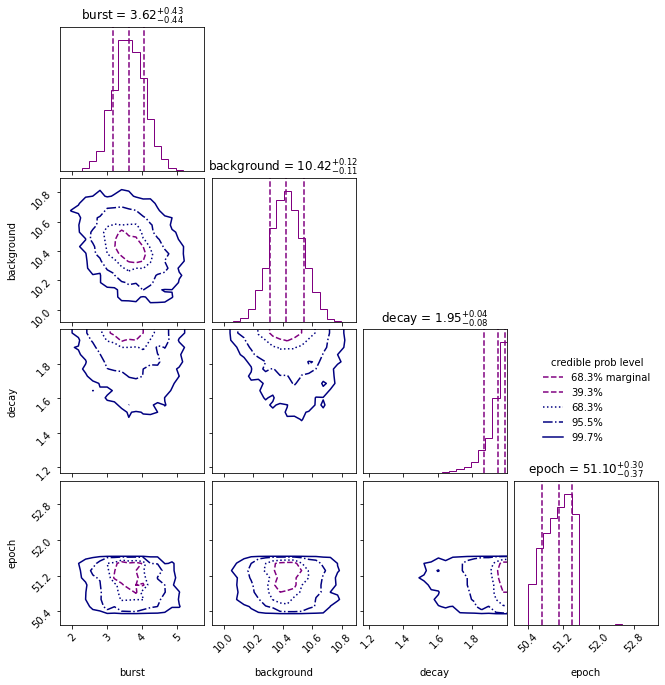

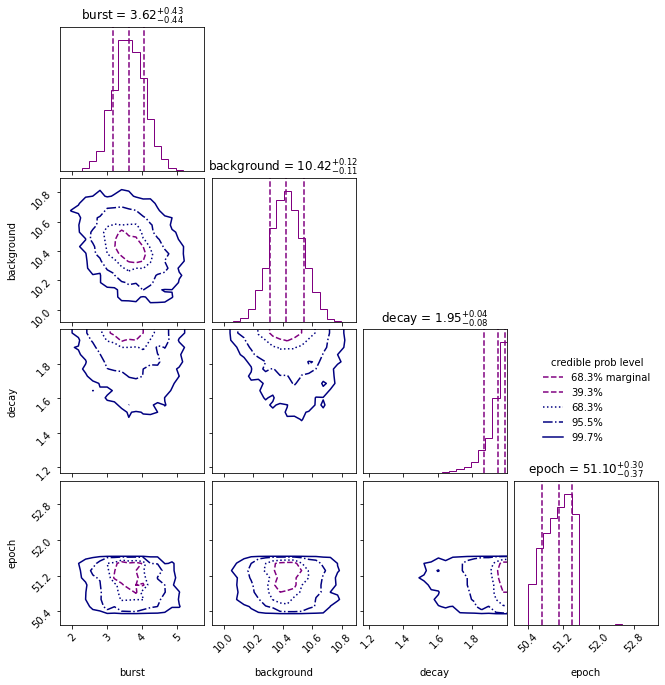

In [122]:
param_names = ['burst', 'background', 'decay', 'epoch']
sampler_ultranest_g = ultranest.ReactiveNestedSampler(param_names, my_likelihood, 
                                          my_prior_transform)
result = sampler_ultranest_g.run()
sampler_ultranest_g.print_results()
cornerplot(result)

MEK: Grab the resulting parameter values, and plot them on top of the raw data

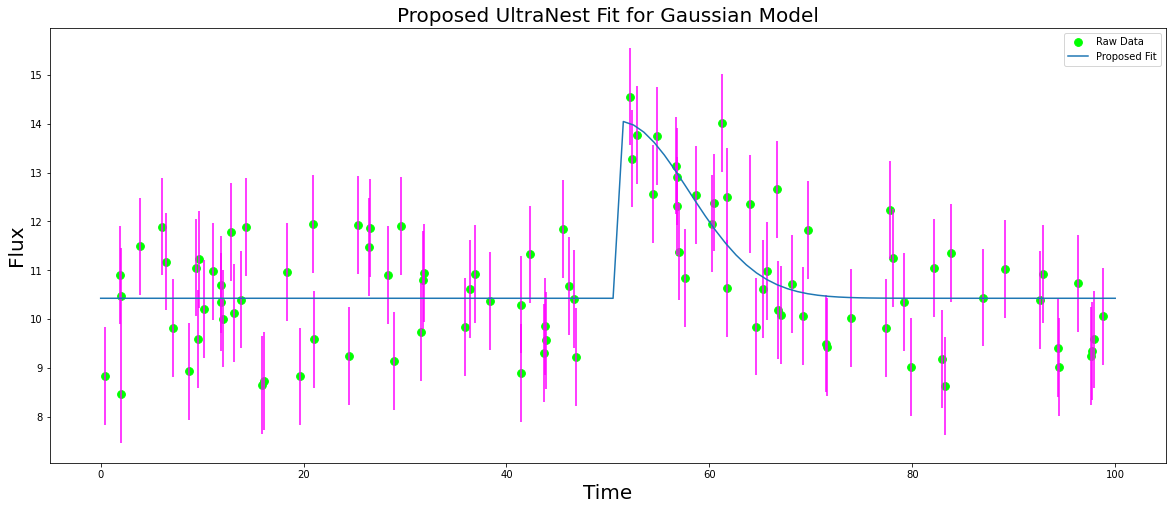

In [149]:
final_parameters = sampler_ultranest_g.results['posterior']['mean']

plt.figure(figsize=(20,8))
plt.errorbar(time, flux, yerr=uncert, color="magenta", fmt="none")
plt.scatter(time, flux, color="lime", s=60, label="Raw Data")

nest_result = gaussian_Q7(t, final_parameters[0], final_parameters[1], final_parameters[2], final_parameters[3])
plt.plot(t, nest_result, label="Proposed Fit")
plt.title("Proposed UltraNest Fit for Gaussian Model", fontsize=20)
plt.xlabel("Time", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.legend()
plt.show()

MEK: Redefine likelihood and prior examples from Steve T. in Lecture 12 and edit them, but this time give them the function and priors for the burst model

In [124]:
def my_likelihood(params):
    burst, background, decay, epoch= params
    decay = np.e**decay
    y_model = np.zeros(len(t))
    y_model[np.where(t<epoch)] = background
    y_model[np.where(t>=epoch)] = background + (burst*(np.e**(-decay*(t[np.where(t>=epoch)]-epoch))))
    like = -0.5 * (((y_model - flux)/uncert)**2).sum()
    return like

def my_prior_transform(cube):
    params = cube.copy()

    # transform location parameter: uniform prior
    lo = 0
    hi = 50
    params[0] = cube[0] * (hi - lo) + lo

    # transform location parameter: uniform prior
    lo = 0
    hi = 50
    params[1] = cube[1] * (hi - lo) + lo

    # transform amplitude parameter: log-uniform prior
    lo = -5
    hi = 5
    params[2] = cube[2] * (hi - lo) + lo

    # transform location parameter: uniform prior
    lo = 0
    hi = 100
    params[3] = cube[3] * (hi - lo) + lo

    return params

MEK: Define parameter names and give ultranest the Gaussian likelihood and prior, let it fit and plot the results

DEBUG:ultranest:ReactiveNestedSampler: dims=4+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


[ultranest] Sampling 400 live points from prior ...


INFO:ultranest:Sampling 400 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=400, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 400.0), (inf, 400.0)]


Z=-inf(0.00%) | Like=-184867.81..-87.20 [-184867.8145..-16967.2857] | it/evals=0/401 eff=0.0000% N=400 

DEBUG:ultranest:iteration=0, ncalls=401, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-184867.81, Lmax=-87.20


Z=-72837.4(0.00%) | Like=-72829.01..-87.20 [-184867.8145..-16967.2857] | it/evals=40/444 eff=90.9091% N=400 

DEBUG:ultranest:iteration=40, ncalls=444, regioncalls=1760, ndraw=40, logz=-72837.38, remainder_fraction=100.0000%, Lmin=-72829.01, Lmax=-87.20


Z=-56864.1(0.00%) | Like=-56589.02..-87.20 [-184867.8145..-16967.2857] | it/evals=80/489 eff=89.8876% N=400 

DEBUG:ultranest:iteration=80, ncalls=489, regioncalls=3560, ndraw=40, logz=-56864.13, remainder_fraction=100.0000%, Lmin=-56589.02, Lmax=-87.20


Z=-51854.2(0.00%) | Like=-51764.86..-87.20 [-184867.8145..-16967.2857] | it/evals=90/500 eff=90.0000% N=400 

DEBUG:ultranest:iteration=90, ncalls=500, regioncalls=4000, ndraw=40, logz=-51854.23, remainder_fraction=100.0000%, Lmin=-51764.86, Lmax=-87.20


Z=-44738.7(0.00%) | Like=-44548.12..-87.20 [-184867.8145..-16967.2857] | it/evals=120/535 eff=88.8889% N=400 

DEBUG:ultranest:iteration=120, ncalls=535, regioncalls=5400, ndraw=40, logz=-44738.69, remainder_fraction=100.0000%, Lmin=-44548.12, Lmax=-87.20


Z=-33325.0(0.00%) | Like=-33293.67..-87.20 [-184867.8145..-16967.2857] | it/evals=160/593 eff=82.9016% N=400 

DEBUG:ultranest:iteration=160, ncalls=593, regioncalls=7720, ndraw=40, logz=-33324.97, remainder_fraction=100.0000%, Lmin=-33293.67, Lmax=-87.20


Z=-28743.6(0.00%) | Like=-28697.49..-87.20 [-184867.8145..-16967.2857] | it/evals=180/618 eff=82.5688% N=400 

DEBUG:ultranest:iteration=180, ncalls=618, regioncalls=8720, ndraw=40, logz=-28743.62, remainder_fraction=100.0000%, Lmin=-28697.49, Lmax=-87.20


Z=-26570.1(0.00%) | Like=-26274.04..-87.20 [-184867.8145..-16967.2857] | it/evals=200/643 eff=82.3045% N=400 

DEBUG:ultranest:iteration=200, ncalls=643, regioncalls=9720, ndraw=40, logz=-26570.10, remainder_fraction=100.0000%, Lmin=-26274.04, Lmax=-87.20


Z=-22356.3(0.00%) | Like=-22225.16..-87.20 [-184867.8145..-16967.2857] | it/evals=240/697 eff=80.8081% N=400 

DEBUG:ultranest:iteration=240, ncalls=697, regioncalls=11880, ndraw=40, logz=-22356.30, remainder_fraction=100.0000%, Lmin=-22225.16, Lmax=-87.20


Z=-16766.1(0.00%) | Like=-16640.88..-87.09 [-16874.3142..-3115.0468] | it/evals=280/744 eff=81.3953% N=400 

DEBUG:ultranest:iteration=280, ncalls=744, regioncalls=13760, ndraw=40, logz=-16766.09, remainder_fraction=100.0000%, Lmin=-16640.88, Lmax=-87.09


Z=-11896.6(0.00%) | Like=-11858.85..-87.09 [-16874.3142..-3115.0468] | it/evals=320/791 eff=81.8414% N=400 

DEBUG:ultranest:iteration=320, ncalls=791, regioncalls=15640, ndraw=40, logz=-11896.59, remainder_fraction=100.0000%, Lmin=-11858.85, Lmax=-87.09


Z=-9127.1(0.00%) | Like=-9101.81..-87.09 [-16874.3142..-3115.0468] | it/evals=360/838 eff=82.1918% N=400 

DEBUG:ultranest:iteration=360, ncalls=838, regioncalls=17520, ndraw=40, logz=-9127.06, remainder_fraction=100.0000%, Lmin=-9101.81, Lmax=-87.09


Z=-6697.8(0.00%) | Like=-6552.60..-87.09 [-16874.3142..-3115.0468] | it/evals=400/896 eff=80.6452% N=400 

DEBUG:ultranest:iteration=400, ncalls=896, regioncalls=19840, ndraw=40, logz=-6697.82, remainder_fraction=100.0000%, Lmin=-6552.60, Lmax=-87.09


Z=-5060.7(0.00%) | Like=-5037.92..-87.09 [-16874.3142..-3115.0468] | it/evals=440/946 eff=80.5861% N=400 

DEBUG:ultranest:iteration=440, ncalls=946, regioncalls=21840, ndraw=40, logz=-5060.73, remainder_fraction=100.0000%, Lmin=-5037.92, Lmax=-87.09


Z=-4838.8(0.00%) | Like=-4827.34..-87.09 [-16874.3142..-3115.0468] | it/evals=450/960 eff=80.3571% N=400 

DEBUG:ultranest:iteration=450, ncalls=960, regioncalls=22400, ndraw=40, logz=-4838.76, remainder_fraction=100.0000%, Lmin=-4827.34, Lmax=-87.09


Z=-4094.2(0.00%) | Like=-4032.54..-87.09 [-16874.3142..-3115.0468] | it/evals=480/1001 eff=79.8669% N=400 

DEBUG:ultranest:iteration=480, ncalls=1001, regioncalls=24040, ndraw=40, logz=-4094.21, remainder_fraction=100.0000%, Lmin=-4032.54, Lmax=-87.09


Z=-3452.1(0.00%) | Like=-3435.60..-87.09 [-16874.3142..-3115.0468] | it/evals=520/1065 eff=78.1955% N=400 

DEBUG:ultranest:iteration=520, ncalls=1065, regioncalls=26600, ndraw=40, logz=-3452.08, remainder_fraction=100.0000%, Lmin=-3435.60, Lmax=-87.09


Z=-3266.2(0.00%) | Like=-3253.29..-87.09 [-16874.3142..-3115.0468] | it/evals=540/1100 eff=77.1429% N=400 

DEBUG:ultranest:iteration=540, ncalls=1100, regioncalls=28000, ndraw=40, logz=-3266.23, remainder_fraction=100.0000%, Lmin=-3253.29, Lmax=-87.09


Z=-3050.5(0.00%) | Like=-3019.47..-87.09 [-3105.6712..-1194.5100] | it/evals=560/1131 eff=76.6074% N=400 

DEBUG:ultranest:iteration=560, ncalls=1131, regioncalls=29240, ndraw=40, logz=-3050.48, remainder_fraction=100.0000%, Lmin=-3019.47, Lmax=-87.09


Z=-2691.8(0.00%) | Like=-2680.41..-87.09 [-3105.6712..-1194.5100] | it/evals=600/1218 eff=73.3496% N=400 

DEBUG:ultranest:iteration=600, ncalls=1218, regioncalls=32720, ndraw=40, logz=-2691.81, remainder_fraction=100.0000%, Lmin=-2680.41, Lmax=-87.09


Z=-2329.0(0.00%) | Like=-2310.88..-87.09 [-3105.6712..-1194.5100] | it/evals=640/1302 eff=70.9534% N=400 

DEBUG:ultranest:iteration=640, ncalls=1302, regioncalls=36080, ndraw=40, logz=-2329.04, remainder_fraction=100.0000%, Lmin=-2310.88, Lmax=-87.09


Z=-1964.4(0.00%) | Like=-1956.57..-87.09 [-3105.6712..-1194.5100] | it/evals=680/1391 eff=68.6176% N=400 

DEBUG:ultranest:iteration=680, ncalls=1391, regioncalls=39640, ndraw=40, logz=-1964.41, remainder_fraction=100.0000%, Lmin=-1956.57, Lmax=-87.09


Z=-1740.9(0.00%) | Like=-1730.74..-87.09 [-3105.6712..-1194.5100] | it/evals=720/1500 eff=65.4545% N=400 

DEBUG:ultranest:iteration=720, ncalls=1500, regioncalls=44000, ndraw=40, logz=-1740.94, remainder_fraction=100.0000%, Lmin=-1730.74, Lmax=-87.09


Z=-1542.5(0.00%) | Like=-1532.46..-87.09 [-3105.6712..-1194.5100] | it/evals=760/1576 eff=64.6259% N=400 

DEBUG:ultranest:iteration=760, ncalls=1576, regioncalls=47040, ndraw=40, logz=-1542.52, remainder_fraction=100.0000%, Lmin=-1532.46, Lmax=-87.09


Z=-1370.2(0.00%) | Like=-1360.63..-87.09 [-3105.6712..-1194.5100] | it/evals=800/1646 eff=64.2055% N=400 

DEBUG:ultranest:iteration=800, ncalls=1646, regioncalls=49840, ndraw=40, logz=-1370.24, remainder_fraction=100.0000%, Lmin=-1360.63, Lmax=-87.09


Z=-1300.9(0.00%) | Like=-1289.19..-87.09 [-3105.6712..-1194.5100] | it/evals=810/1669 eff=63.8298% N=400 

DEBUG:ultranest:iteration=810, ncalls=1669, regioncalls=50760, ndraw=40, logz=-1300.86, remainder_fraction=100.0000%, Lmin=-1289.19, Lmax=-87.09


Z=-1178.3(0.00%) | Like=-1168.46..-87.09 [-1194.4439..-474.8450] | it/evals=840/1750 eff=62.2222% N=400 

DEBUG:ultranest:iteration=840, ncalls=1750, regioncalls=54000, ndraw=40, logz=-1178.34, remainder_fraction=100.0000%, Lmin=-1168.46, Lmax=-87.09


Z=-1040.0(0.00%) | Like=-1029.99..-87.09 [-1194.4439..-474.8450] | it/evals=880/1862 eff=60.1915% N=400 

DEBUG:ultranest:iteration=880, ncalls=1862, regioncalls=58480, ndraw=40, logz=-1040.05, remainder_fraction=100.0000%, Lmin=-1029.99, Lmax=-87.09


Z=-872.0(0.00%) | Like=-861.14..-87.09 [-1194.4439..-474.8450] | it/evals=920/2009 eff=57.1784% N=400 

DEBUG:ultranest:iteration=920, ncalls=2009, regioncalls=64360, ndraw=40, logz=-872.00, remainder_fraction=100.0000%, Lmin=-861.14, Lmax=-87.09


Z=-774.0(0.00%) | Like=-765.54..-87.09 [-1194.4439..-474.8450] | it/evals=960/2154 eff=54.7320% N=400 

DEBUG:ultranest:iteration=960, ncalls=2154, regioncalls=70160, ndraw=40, logz=-773.95, remainder_fraction=100.0000%, Lmin=-765.54, Lmax=-87.09


Z=-676.8(0.00%) | Like=-667.73..-87.09 [-1194.4439..-474.8450] | it/evals=1000/2270 eff=53.4759% N=400 

DEBUG:ultranest:iteration=1000, ncalls=2270, regioncalls=74800, ndraw=40, logz=-676.80, remainder_fraction=100.0000%, Lmin=-667.73, Lmax=-87.09


Z=-603.3(0.00%) | Like=-594.72..-87.09 [-1194.4439..-474.8450] | it/evals=1040/2420 eff=51.4851% N=400 

DEBUG:ultranest:iteration=1040, ncalls=2420, regioncalls=80800, ndraw=40, logz=-603.32, remainder_fraction=100.0000%, Lmin=-594.72, Lmax=-87.09


Z=-530.4(0.00%) | Like=-514.67..-87.09 [-1194.4439..-474.8450] | it/evals=1080/2592 eff=49.2701% N=400 

DEBUG:ultranest:iteration=1080, ncalls=2592, regioncalls=87680, ndraw=40, logz=-530.37, remainder_fraction=100.0000%, Lmin=-514.67, Lmax=-87.09


Z=-467.9(0.00%) | Like=-458.76..-85.81 [-472.6101..-238.0648] | it/evals=1120/2745 eff=47.7612% N=400 

DEBUG:ultranest:iteration=1120, ncalls=2745, regioncalls=93800, ndraw=40, logz=-467.90, remainder_fraction=100.0000%, Lmin=-458.76, Lmax=-85.81


Z=-427.1(0.00%) | Like=-418.71..-85.81 [-472.6101..-238.0648] | it/evals=1160/2923 eff=45.9770% N=400 

DEBUG:ultranest:iteration=1160, ncalls=2923, regioncalls=100920, ndraw=40, logz=-427.09, remainder_fraction=100.0000%, Lmin=-418.71, Lmax=-85.81


Z=-412.6(0.00%) | Like=-404.10..-85.81 [-472.6101..-238.0648] | it/evals=1170/2956 eff=45.7746% N=400 

DEBUG:ultranest:iteration=1170, ncalls=2956, regioncalls=102240, ndraw=40, logz=-412.59, remainder_fraction=100.0000%, Lmin=-404.10, Lmax=-85.81


Z=-384.6(0.00%) | Like=-374.82..-85.81 [-472.6101..-238.0648] | it/evals=1200/3016 eff=45.8716% N=400 

DEBUG:ultranest:iteration=1200, ncalls=3016, regioncalls=104640, ndraw=40, logz=-384.60, remainder_fraction=100.0000%, Lmin=-374.82, Lmax=-85.81


Z=-356.4(0.00%) | Like=-347.66..-85.81 [-472.6101..-238.0648] | it/evals=1240/3104 eff=45.8580% N=400 

DEBUG:ultranest:iteration=1240, ncalls=3104, regioncalls=108160, ndraw=40, logz=-356.38, remainder_fraction=100.0000%, Lmin=-347.66, Lmax=-85.81


Z=-319.6(0.00%) | Like=-309.76..-85.81 [-472.6101..-238.0648] | it/evals=1280/3205 eff=45.6328% N=400 

DEBUG:ultranest:iteration=1280, ncalls=3205, regioncalls=112200, ndraw=40, logz=-319.57, remainder_fraction=100.0000%, Lmin=-309.76, Lmax=-85.81


Z=-290.8(0.00%) | Like=-281.43..-85.81 [-472.6101..-238.0648] | it/evals=1320/3306 eff=45.4233% N=400 

DEBUG:ultranest:iteration=1320, ncalls=3306, regioncalls=116320, ndraw=40, logz=-290.82, remainder_fraction=100.0000%, Lmin=-281.43, Lmax=-85.81


Z=-268.3(0.00%) | Like=-259.70..-85.81 [-472.6101..-238.0648] | it/evals=1360/3396 eff=45.3939% N=400 

DEBUG:ultranest:iteration=1360, ncalls=3396, regioncalls=119920, ndraw=40, logz=-268.33, remainder_fraction=100.0000%, Lmin=-259.70, Lmax=-85.81


Z=-245.0(0.00%) | Like=-236.02..-85.81 [-237.3489..-135.3924] | it/evals=1400/3495 eff=45.2342% N=400 

DEBUG:ultranest:iteration=1400, ncalls=3495, regioncalls=123880, ndraw=40, logz=-245.00, remainder_fraction=100.0000%, Lmin=-236.02, Lmax=-85.81


Z=-222.5(0.00%) | Like=-213.62..-80.99 [-237.3489..-135.3924] | it/evals=1440/3605 eff=44.9298% N=400 

DEBUG:ultranest:iteration=1440, ncalls=3605, regioncalls=128280, ndraw=40, logz=-222.53, remainder_fraction=100.0000%, Lmin=-213.62, Lmax=-80.99


Z=-203.7(0.00%) | Like=-194.69..-80.99 [-237.3489..-135.3924] | it/evals=1480/3730 eff=44.4444% N=400 

DEBUG:ultranest:iteration=1480, ncalls=3730, regioncalls=133320, ndraw=40, logz=-203.66, remainder_fraction=100.0000%, Lmin=-194.69, Lmax=-80.99


Z=-186.8(0.00%) | Like=-178.03..-80.99 [-237.3489..-135.3924] | it/evals=1520/3840 eff=44.1860% N=400 

DEBUG:ultranest:iteration=1520, ncalls=3840, regioncalls=137720, ndraw=40, logz=-186.77, remainder_fraction=100.0000%, Lmin=-178.03, Lmax=-80.99


Z=-171.6(0.00%) | Like=-163.17..-80.99 [-237.3489..-135.3924] | it/evals=1560/3993 eff=43.4178% N=400 

DEBUG:ultranest:iteration=1560, ncalls=3993, regioncalls=143880, ndraw=40, logz=-171.56, remainder_fraction=100.0000%, Lmin=-163.17, Lmax=-80.99


Z=-160.8(0.00%) | Like=-152.53..-80.99 [-237.3489..-135.3924] | it/evals=1600/4154 eff=42.6212% N=400 

DEBUG:ultranest:iteration=1600, ncalls=4154, regioncalls=150600, ndraw=40, logz=-160.84, remainder_fraction=100.0000%, Lmin=-152.53, Lmax=-80.99


Z=-150.6(0.00%) | Like=-142.12..-80.99 [-237.3489..-135.3924] | it/evals=1640/4266 eff=42.4211% N=400 

DEBUG:ultranest:iteration=1640, ncalls=4266, regioncalls=155240, ndraw=40, logz=-150.59, remainder_fraction=100.0000%, Lmin=-142.12, Lmax=-80.99


Z=-143.2(0.00%) | Like=-134.65..-80.99 [-135.3745..-100.7046] | it/evals=1680/4484 eff=41.1361% N=400 

DEBUG:ultranest:iteration=1680, ncalls=4484, regioncalls=164240, ndraw=40, logz=-143.22, remainder_fraction=100.0000%, Lmin=-134.65, Lmax=-80.99


Z=-137.3(0.00%) | Like=-128.93..-80.99 [-135.3745..-100.7046] | it/evals=1710/4600 eff=40.7143% N=400 

DEBUG:ultranest:iteration=1710, ncalls=4600, regioncalls=169000, ndraw=40, logz=-137.29, remainder_fraction=100.0000%, Lmin=-128.93, Lmax=-80.99


Z=-135.8(0.00%) | Like=-127.07..-80.99 [-135.3745..-100.7046] | it/evals=1720/4624 eff=40.7197% N=400 

DEBUG:ultranest:iteration=1720, ncalls=4624, regioncalls=170000, ndraw=40, logz=-135.78, remainder_fraction=100.0000%, Lmin=-127.07, Lmax=-80.99


Z=-130.3(0.00%) | Like=-122.45..-80.99 [-135.3745..-100.7046] | it/evals=1760/4770 eff=40.2746% N=400 

DEBUG:ultranest:iteration=1760, ncalls=4770, regioncalls=175840, ndraw=40, logz=-130.34, remainder_fraction=100.0000%, Lmin=-122.45, Lmax=-80.99


Z=-125.0(0.00%) | Like=-116.20..-80.99 [-135.3745..-100.7046] | it/evals=1800/4894 eff=40.0534% N=400 

DEBUG:ultranest:iteration=1800, ncalls=4894, regioncalls=180800, ndraw=40, logz=-125.00, remainder_fraction=100.0000%, Lmin=-116.20, Lmax=-80.99


Z=-120.8(0.00%) | Like=-112.21..-80.99 [-135.3745..-100.7046] | it/evals=1840/5006 eff=39.9479% N=400 

DEBUG:ultranest:iteration=1840, ncalls=5006, regioncalls=185400, ndraw=40, logz=-120.84, remainder_fraction=100.0000%, Lmin=-112.21, Lmax=-80.99


Z=-116.3(0.00%) | Like=-107.82..-80.99 [-135.3745..-100.7046] | it/evals=1880/5134 eff=39.7127% N=400 

DEBUG:ultranest:iteration=1880, ncalls=5134, regioncalls=190520, ndraw=40, logz=-116.31, remainder_fraction=100.0000%, Lmin=-107.82, Lmax=-80.99


Z=-112.1(0.00%) | Like=-103.32..-80.99 [-135.3745..-100.7046] | it/evals=1920/5306 eff=39.1358% N=400 

DEBUG:ultranest:iteration=1920, ncalls=5306, regioncalls=197400, ndraw=40, logz=-112.14, remainder_fraction=100.0000%, Lmin=-103.32, Lmax=-80.99


Z=-108.7(0.00%) | Like=-100.53..-80.99 [-100.6833..-91.3563] | it/evals=1960/5491 eff=38.4993% N=400 

DEBUG:ultranest:iteration=1960, ncalls=5491, regioncalls=204800, ndraw=40, logz=-108.66, remainder_fraction=100.0000%, Lmin=-100.53, Lmax=-80.99


Z=-106.7(0.00%) | Like=-98.75..-80.99 [-100.6833..-91.3563] | it/evals=2000/5648 eff=38.1098% N=400 

DEBUG:ultranest:iteration=2000, ncalls=5648, regioncalls=211080, ndraw=40, logz=-106.69, remainder_fraction=100.0000%, Lmin=-98.75, Lmax=-80.99


Z=-105.0(0.00%) | Like=-97.17..-80.99 [-100.6833..-91.3563] | it/evals=2040/5835 eff=37.5345% N=400 

DEBUG:ultranest:iteration=2040, ncalls=5835, regioncalls=218600, ndraw=40, logz=-104.99, remainder_fraction=99.9999%, Lmin=-97.17, Lmax=-80.99


Z=-103.6(0.00%) | Like=-95.76..-80.99 [-100.6833..-91.3563] | it/evals=2080/5996 eff=37.1694% N=400 

DEBUG:ultranest:iteration=2080, ncalls=5996, regioncalls=225040, ndraw=40, logz=-103.60, remainder_fraction=99.9994%, Lmin=-95.76, Lmax=-80.99


Z=-102.3(0.00%) | Like=-94.36..-77.26 [-100.6833..-91.3563] | it/evals=2120/6163 eff=36.7864% N=400 

DEBUG:ultranest:iteration=2120, ncalls=6163, regioncalls=231840, ndraw=40, logz=-102.31, remainder_fraction=99.9999%, Lmin=-94.36, Lmax=-77.26


Z=-101.0(0.00%) | Like=-93.04..-77.26 [-100.6833..-91.3563] | it/evals=2160/6395 eff=36.0300% N=400 

DEBUG:ultranest:iteration=2160, ncalls=6395, regioncalls=241160, ndraw=40, logz=-100.97, remainder_fraction=99.9996%, Lmin=-93.04, Lmax=-77.26


Z=-99.8(0.00%) | Like=-91.83..-76.83 [-100.6833..-91.3563] | it/evals=2200/6573 eff=35.6391% N=400 

DEBUG:ultranest:iteration=2200, ncalls=6573, regioncalls=248760, ndraw=40, logz=-99.80, remainder_fraction=99.9994%, Lmin=-91.83, Lmax=-76.83


Z=-98.9(0.00%) | Like=-91.16..-76.83 [-91.3478..-88.2311] | it/evals=2240/6784 eff=35.0877% N=400 

DEBUG:ultranest:iteration=2240, ncalls=6784, regioncalls=257800, ndraw=40, logz=-98.86, remainder_fraction=99.9984%, Lmin=-91.16, Lmax=-76.83


Z=-98.1(0.00%) | Like=-90.43..-76.55 [-91.3478..-88.2311] | it/evals=2280/7034 eff=34.3684% N=400 

DEBUG:ultranest:iteration=2280, ncalls=7034, regioncalls=268880, ndraw=40, logz=-98.08, remainder_fraction=99.9963%, Lmin=-90.43, Lmax=-76.55


Z=-97.4(0.00%) | Like=-89.76..-61.85 [-91.3478..-88.2311] | it/evals=2320/7254 eff=33.8488% N=400 

DEBUG:ultranest:iteration=2320, ncalls=7254, regioncalls=277840, ndraw=40, logz=-97.40, remainder_fraction=100.0000%, Lmin=-89.76, Lmax=-61.85


Z=-96.8(0.00%) | Like=-89.29..-61.85 [-91.3478..-88.2311] | it/evals=2360/7575 eff=32.8920% N=400 

DEBUG:ultranest:iteration=2360, ncalls=7575, regioncalls=291160, ndraw=40, logz=-96.83, remainder_fraction=100.0000%, Lmin=-89.29, Lmax=-61.85


Z=-96.4(0.00%) | Like=-88.98..-61.85 [-91.3478..-88.2311] | it/evals=2400/7926 eff=31.8894% N=400 

DEBUG:ultranest:iteration=2400, ncalls=7926, regioncalls=305520, ndraw=40, logz=-96.38, remainder_fraction=100.0000%, Lmin=-88.98, Lmax=-61.85


Z=-96.1(0.00%) | Like=-88.75..-61.85 [-91.3478..-88.2311] | it/evals=2430/8117 eff=31.4889% N=400 

DEBUG:ultranest:iteration=2430, ncalls=8117, regioncalls=313840, ndraw=40, logz=-96.09, remainder_fraction=100.0000%, Lmin=-88.75, Lmax=-61.85


Z=-96.0(0.00%) | Like=-88.68..-61.85 [-91.3478..-88.2311] | it/evals=2440/8166 eff=31.4190% N=400 

DEBUG:ultranest:iteration=2440, ncalls=8166, regioncalls=315880, ndraw=40, logz=-96.01, remainder_fraction=100.0000%, Lmin=-88.68, Lmax=-61.85


Z=-95.7(0.00%) | Like=-88.34..-61.85 [-91.3478..-88.2311] | it/evals=2480/8443 eff=30.8343% N=400 

DEBUG:ultranest:iteration=2480, ncalls=8443, regioncalls=328320, ndraw=40, logz=-95.68, remainder_fraction=100.0000%, Lmin=-88.34, Lmax=-61.85


Z=-95.4(0.00%) | Like=-88.11..-61.85 [-88.2053..-87.3462] | it/evals=2520/8734 eff=30.2376% N=400 

DEBUG:ultranest:iteration=2520, ncalls=8734, regioncalls=340120, ndraw=40, logz=-95.39, remainder_fraction=100.0000%, Lmin=-88.11, Lmax=-61.85


Z=-95.1(0.00%) | Like=-87.91..-61.85 [-88.2053..-87.3462] | it/evals=2560/9071 eff=29.5237% N=400 

DEBUG:ultranest:iteration=2560, ncalls=9071, regioncalls=354920, ndraw=40, logz=-95.14, remainder_fraction=100.0000%, Lmin=-87.91, Lmax=-61.85


Z=-94.9(0.00%) | Like=-87.76..-61.85 [-88.2053..-87.3462] | it/evals=2600/9358 eff=29.0243% N=400 

DEBUG:ultranest:iteration=2600, ncalls=9358, regioncalls=368080, ndraw=40, logz=-94.93, remainder_fraction=100.0000%, Lmin=-87.76, Lmax=-61.85


Z=-94.9(0.00%) | Like=-87.74..-61.66 [-88.2053..-87.3462] | it/evals=2610/9466 eff=28.7889% N=400 

DEBUG:ultranest:iteration=2610, ncalls=9466, regioncalls=373360, ndraw=40, logz=-94.88, remainder_fraction=100.0000%, Lmin=-87.74, Lmax=-61.66


Z=-94.8(0.00%) | Like=-87.66..-61.66 [-88.2053..-87.3462] | it/evals=2640/9763 eff=28.1961% N=400 

DEBUG:ultranest:iteration=2640, ncalls=9763, regioncalls=387240, ndraw=40, logz=-94.75, remainder_fraction=100.0000%, Lmin=-87.66, Lmax=-61.66


Z=-94.6(0.00%) | Like=-87.53..-61.66 [-88.2053..-87.3462] | it/evals=2680/10245 eff=27.2219% N=400 

DEBUG:ultranest:iteration=2680, ncalls=10245, regioncalls=407960, ndraw=40, logz=-94.60, remainder_fraction=100.0000%, Lmin=-87.53, Lmax=-61.66


Z=-94.5(0.00%) | Like=-87.45..-61.66 [-88.2053..-87.3462] | it/evals=2720/10752 eff=26.2751% N=400 

DEBUG:ultranest:iteration=2720, ncalls=10752, regioncalls=429520, ndraw=40, logz=-94.47, remainder_fraction=100.0000%, Lmin=-87.45, Lmax=-61.66


Z=-94.4(0.00%) | Like=-87.36..-61.66 [-88.2053..-87.3462] | it/evals=2758/11350 eff=25.1872% N=400 

DEBUG:ultranest:iteration=2758, ncalls=11350, regioncalls=455920, ndraw=40, logz=-94.36, remainder_fraction=100.0000%, Lmin=-87.36, Lmax=-61.66


Z=-94.4(0.00%) | Like=-87.36..-61.66 [-88.2053..-87.3462] | it/evals=2760/11376 eff=25.1458% N=400 

DEBUG:ultranest:iteration=2760, ncalls=11376, regioncalls=456960, ndraw=40, logz=-94.35, remainder_fraction=100.0000%, Lmin=-87.36, Lmax=-61.66


Z=-94.3(0.00%) | Like=-87.33..-61.66 [-87.3459..-87.1243] | it/evals=2797/11900 eff=24.3217% N=400 

DEBUG:ultranest:iteration=2797, ncalls=11900, regioncalls=479800, ndraw=40, logz=-94.26, remainder_fraction=100.0000%, Lmin=-87.33, Lmax=-61.66


Z=-94.2(0.00%) | Like=-87.33..-61.66 [-87.3459..-87.1243] | it/evals=2800/11920 eff=24.3056% N=400 

DEBUG:ultranest:iteration=2800, ncalls=11920, regioncalls=480600, ndraw=40, logz=-94.25, remainder_fraction=100.0000%, Lmin=-87.33, Lmax=-61.66


Z=-94.2(0.00%) | Like=-87.28..-61.66 [-87.3459..-87.1243] | it/evals=2840/12445 eff=23.5782% N=400 

DEBUG:ultranest:iteration=2840, ncalls=12445, regioncalls=502680, ndraw=40, logz=-94.16, remainder_fraction=100.0000%, Lmin=-87.28, Lmax=-61.66


Z=-94.1(0.00%) | Like=-87.23..-60.20 [-87.3459..-87.1243] | it/evals=2879/13258 eff=22.3907% N=400 

DEBUG:ultranest:iteration=2879, ncalls=13258, regioncalls=537400, ndraw=40, logz=-94.09, remainder_fraction=100.0000%, Lmin=-87.23, Lmax=-60.20


Z=-94.1(0.00%) | Like=-87.23..-60.20 [-87.3459..-87.1243] | it/evals=2880/13267 eff=22.3828% N=400 

DEBUG:ultranest:iteration=2880, ncalls=13267, regioncalls=537880, ndraw=40, logz=-94.09, remainder_fraction=100.0000%, Lmin=-87.23, Lmax=-60.20


Z=-94.0(0.00%) | Like=-87.20..-60.20 [-87.3459..-87.1243] | it/evals=2920/14080 eff=21.3450% N=400 

DEBUG:ultranest:iteration=2920, ncalls=14080, regioncalls=574080, ndraw=40, logz=-94.02, remainder_fraction=100.0000%, Lmin=-87.20, Lmax=-60.20


Z=-94.0(0.00%) | Like=-87.17..-60.20 [-87.3459..-87.1243] | it/evals=2956/14916 eff=20.3637% N=400 

DEBUG:ultranest:iteration=2956, ncalls=14916, regioncalls=611560, ndraw=40, logz=-93.97, remainder_fraction=100.0000%, Lmin=-87.17, Lmax=-60.20


Z=-94.0(0.00%) | Like=-87.17..-60.20 [-87.3459..-87.1243] | it/evals=2960/15017 eff=20.2504% N=400 

DEBUG:ultranest:iteration=2960, ncalls=15017, regioncalls=615960, ndraw=40, logz=-93.96, remainder_fraction=100.0000%, Lmin=-87.17, Lmax=-60.20


Z=-94.0(0.00%) | Like=-87.16..-60.20 [-87.3459..-87.1243] | it/evals=2970/15163 eff=20.1179% N=400 

DEBUG:ultranest:iteration=2970, ncalls=15163, regioncalls=622320, ndraw=40, logz=-93.95, remainder_fraction=100.0000%, Lmin=-87.16, Lmax=-60.20


Z=-93.9(0.00%) | Like=-87.14..-60.20 [-87.3459..-87.1243] | it/evals=3000/15921 eff=19.3287% N=400 

DEBUG:ultranest:iteration=3000, ncalls=15921, regioncalls=653760, ndraw=40, logz=-93.91, remainder_fraction=100.0000%, Lmin=-87.14, Lmax=-60.20


Z=-93.9(0.00%) | Like=-87.13..-60.14 [-87.3459..-87.1243] | it/evals=3038/16885 eff=18.4289% N=400 

DEBUG:ultranest:iteration=3038, ncalls=16885, regioncalls=694440, ndraw=40, logz=-93.87, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-60.14


Z=-93.9(0.00%) | Like=-87.13..-60.14 [-87.3459..-87.1243] | it/evals=3040/16933 eff=18.3875% N=400 

DEBUG:ultranest:iteration=3040, ncalls=16933, regioncalls=696440, ndraw=40, logz=-93.87, remainder_fraction=100.0000%, Lmin=-87.13, Lmax=-60.14


Z=-93.8(0.00%) | Like=-87.12..-60.14 [-87.1241..-86.9537] | it/evals=3060/17484 eff=17.9115% N=400 

DEBUG:ultranest:iteration=3060, ncalls=17484, regioncalls=718880, ndraw=40, logz=-93.85, remainder_fraction=100.0000%, Lmin=-87.12, Lmax=-60.14


Z=-93.8(0.00%) | Like=-87.11..-60.14 [-87.1241..-86.9537] | it/evals=3080/18042 eff=17.4583% N=400 

DEBUG:ultranest:iteration=3080, ncalls=18042, regioncalls=741600, ndraw=40, logz=-93.83, remainder_fraction=100.0000%, Lmin=-87.11, Lmax=-60.14


Z=-93.8(0.00%) | Like=-87.10..-60.14 [-87.1241..-86.9537] | it/evals=3120/18940 eff=16.8285% N=400 

DEBUG:ultranest:iteration=3120, ncalls=18940, regioncalls=778280, ndraw=40, logz=-93.79, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-60.14


Z=-93.8(0.00%) | Like=-87.10..-56.41 [-87.1241..-86.9537] | it/evals=3150/19850 eff=16.1954% N=400 

DEBUG:ultranest:iteration=3150, ncalls=19850, regioncalls=815560, ndraw=40, logz=-93.77, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-56.41


Z=-93.8(0.00%) | Like=-87.10..-56.41 [-87.1241..-86.9537] | it/evals=3160/20149 eff=16.0008% N=400 

DEBUG:ultranest:iteration=3160, ncalls=20149, regioncalls=828160, ndraw=40, logz=-93.76, remainder_fraction=100.0000%, Lmin=-87.10, Lmax=-56.41


Z=-93.7(0.00%) | Like=-87.09..-56.41 [-87.1241..-86.9537] | it/evals=3197/21328 eff=15.2762% N=400 

DEBUG:ultranest:iteration=3197, ncalls=21328, regioncalls=875720, ndraw=40, logz=-93.74, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-56.41


Z=-93.7(0.00%) | Like=-87.09..-56.41 [-87.1241..-86.9537] | it/evals=3200/21534 eff=15.1415% N=400 

DEBUG:ultranest:iteration=3200, ncalls=21534, regioncalls=883960, ndraw=40, logz=-93.73, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-56.41


Z=-93.7(0.00%) | Like=-87.09..-56.41 [-87.1241..-86.9537] | it/evals=3230/22512 eff=14.6075% N=400 

DEBUG:ultranest:iteration=3230, ncalls=22512, regioncalls=923800, ndraw=40, logz=-93.72, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-56.41


Z=-93.7(0.00%) | Like=-87.09..-56.41 [-87.1241..-86.9537] | it/evals=3240/22878 eff=14.4141% N=400 

DEBUG:ultranest:iteration=3240, ncalls=22878, regioncalls=938720, ndraw=40, logz=-93.71, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-56.41


Z=-93.7(0.00%) | Like=-87.09..-52.23 [-87.1241..-86.9537] | it/evals=3267/23973 eff=13.8591% N=400 

DEBUG:ultranest:iteration=3267, ncalls=23973, regioncalls=982560, ndraw=40, logz=-93.70, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.23


Z=-93.7(0.00%) | Like=-87.09..-52.23 [-87.1241..-86.9537] | it/evals=3280/24327 eff=13.7084% N=400 

DEBUG:ultranest:iteration=3280, ncalls=24327, regioncalls=996720, ndraw=40, logz=-93.69, remainder_fraction=100.0000%, Lmin=-87.09, Lmax=-52.23


Z=-93.7(0.00%) | Like=-87.02..-52.23 [-87.1241..-86.9537] | it/evals=3316/25512 eff=13.2048% N=400 

DEBUG:ultranest:iteration=3316, ncalls=25512, regioncalls=1044120, ndraw=40, logz=-93.67, remainder_fraction=100.0000%, Lmin=-87.02, Lmax=-52.23


Z=-93.7(0.00%) | Like=-87.01..-52.23 [-87.1241..-86.9537] | it/evals=3320/25840 eff=13.0503% N=400 

DEBUG:ultranest:iteration=3320, ncalls=25840, regioncalls=1057240, ndraw=40, logz=-93.67, remainder_fraction=100.0000%, Lmin=-87.01, Lmax=-52.23


Z=-93.7(0.00%) | Like=-86.88..-52.23 [-86.9513..-84.8499] | it/evals=3353/26870 eff=12.6672% N=400 

DEBUG:ultranest:iteration=3353, ncalls=26870, regioncalls=1098560, ndraw=40, logz=-93.65, remainder_fraction=100.0000%, Lmin=-86.88, Lmax=-52.23


Z=-93.6(0.00%) | Like=-86.87..-52.23 [-86.9513..-84.8499] | it/evals=3360/27343 eff=12.4708% N=400 

DEBUG:ultranest:iteration=3360, ncalls=27343, regioncalls=1117480, ndraw=40, logz=-93.65, remainder_fraction=100.0000%, Lmin=-86.87, Lmax=-52.23


Z=-93.6(0.00%) | Like=-86.73..-52.23 [-86.9513..-84.8499] | it/evals=3387/28625 eff=12.0000% N=400 

DEBUG:ultranest:iteration=3387, ncalls=28625, regioncalls=1168880, ndraw=40, logz=-93.64, remainder_fraction=100.0000%, Lmin=-86.73, Lmax=-52.23


Z=-93.6(0.00%) | Like=-86.68..-52.23 [-86.9513..-84.8499] | it/evals=3400/28966 eff=11.9023% N=400 

DEBUG:ultranest:iteration=3400, ncalls=28966, regioncalls=1182520, ndraw=40, logz=-93.63, remainder_fraction=100.0000%, Lmin=-86.68, Lmax=-52.23
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2, 3, 4]), array([396,   2,   1,   1]))


Z=-93.6(0.00%) | Like=-86.52..-52.23 [-86.9513..-84.8499] | it/evals=3428/30262 eff=11.4795% N=400 

DEBUG:ultranest:iteration=3428, ncalls=30262, regioncalls=1234440, ndraw=40, logz=-93.61, remainder_fraction=100.0000%, Lmin=-86.52, Lmax=-52.23


Z=-93.6(0.00%) | Like=-86.44..-52.23 [-86.9513..-84.8499] | it/evals=3440/30744 eff=11.3367% N=400 

DEBUG:ultranest:iteration=3440, ncalls=30744, regioncalls=1253720, ndraw=40, logz=-93.61, remainder_fraction=100.0000%, Lmin=-86.44, Lmax=-52.23


Z=-93.6(0.00%) | Like=-86.28..-52.23 [-86.9513..-84.8499] | it/evals=3464/31958 eff=10.9766% N=400 

DEBUG:ultranest:iteration=3464, ncalls=31958, regioncalls=1302600, ndraw=40, logz=-93.59, remainder_fraction=100.0000%, Lmin=-86.28, Lmax=-52.23


Z=-93.6(0.00%) | Like=-86.08..-52.23 [-86.9513..-84.8499] | it/evals=3480/32560 eff=10.8209% N=400 

DEBUG:ultranest:iteration=3480, ncalls=32560, regioncalls=1326800, ndraw=40, logz=-93.58, remainder_fraction=100.0000%, Lmin=-86.08, Lmax=-52.23


Z=-93.6(0.00%) | Like=-85.87..-51.50 [-86.9513..-84.8499] | it/evals=3505/33750 eff=10.5097% N=400 

DEBUG:ultranest:iteration=3505, ncalls=33750, regioncalls=1375160, ndraw=40, logz=-93.56, remainder_fraction=100.0000%, Lmin=-85.87, Lmax=-51.50


Z=-93.6(0.00%) | Like=-85.83..-51.50 [-86.9513..-84.8499] | it/evals=3510/34041 eff=10.4337% N=400 

DEBUG:ultranest:iteration=3510, ncalls=34041, regioncalls=1387320, ndraw=40, logz=-93.56, remainder_fraction=100.0000%, Lmin=-85.83, Lmax=-51.50


Z=-93.5(0.00%) | Like=-85.73..-51.50 [-86.9513..-84.8499] | it/evals=3520/34308 eff=10.3810% N=400 

DEBUG:ultranest:iteration=3520, ncalls=34308, regioncalls=1398000, ndraw=40, logz=-93.55, remainder_fraction=100.0000%, Lmin=-85.73, Lmax=-51.50


Z=-93.5(0.00%) | Like=-85.48..-51.50 [-86.9513..-84.8499] | it/evals=3549/35449 eff=10.1258% N=400 

DEBUG:ultranest:iteration=3549, ncalls=35449, regioncalls=1443960, ndraw=40, logz=-93.52, remainder_fraction=100.0000%, Lmin=-85.48, Lmax=-51.50


Z=-93.5(0.00%) | Like=-85.36..-51.50 [-86.9513..-84.8499] | it/evals=3560/35698 eff=10.0856% N=400 

DEBUG:ultranest:iteration=3560, ncalls=35698, regioncalls=1453920, ndraw=40, logz=-93.51, remainder_fraction=100.0000%, Lmin=-85.36, Lmax=-51.50


Z=-93.5(0.00%) | Like=-85.11..-51.50 [-86.9513..-84.8499] | it/evals=3579/36707 eff=9.8576% N=400 

DEBUG:ultranest:iteration=3579, ncalls=36707, regioncalls=1494840, ndraw=40, logz=-93.48, remainder_fraction=100.0000%, Lmin=-85.11, Lmax=-51.50


Z=-93.5(0.00%) | Like=-84.91..-51.50 [-86.9513..-84.8499] | it/evals=3600/37232 eff=9.7741% N=400 

DEBUG:ultranest:iteration=3600, ncalls=37232, regioncalls=1515840, ndraw=40, logz=-93.45, remainder_fraction=100.0000%, Lmin=-84.91, Lmax=-51.50


Z=-93.4(0.00%) | Like=-84.58..-51.50 [-84.8472..-81.6316] | it/evals=3634/38435 eff=9.5544% N=400 

DEBUG:ultranest:iteration=3634, ncalls=38435, regioncalls=1564000, ndraw=40, logz=-93.39, remainder_fraction=100.0000%, Lmin=-84.58, Lmax=-51.50


Z=-93.4(0.00%) | Like=-84.53..-51.50 [-84.8472..-81.6316] | it/evals=3640/38684 eff=9.5079% N=400 

DEBUG:ultranest:iteration=3640, ncalls=38684, regioncalls=1574040, ndraw=40, logz=-93.38, remainder_fraction=100.0000%, Lmin=-84.53, Lmax=-51.50


Z=-93.3(0.00%) | Like=-84.25..-51.50 [-84.8472..-81.6316] | it/evals=3666/39776 eff=9.3102% N=400 

DEBUG:ultranest:iteration=3666, ncalls=39776, regioncalls=1618040, ndraw=40, logz=-93.33, remainder_fraction=100.0000%, Lmin=-84.25, Lmax=-51.50


Z=-93.3(0.00%) | Like=-83.96..-51.50 [-84.8472..-81.6316] | it/evals=3680/40359 eff=9.2094% N=400 

DEBUG:ultranest:iteration=3680, ncalls=40359, regioncalls=1641440, ndraw=40, logz=-93.29, remainder_fraction=100.0000%, Lmin=-83.96, Lmax=-51.50


Z=-93.2(0.00%) | Like=-83.63..-51.50 [-84.8472..-81.6316] | it/evals=3706/41390 eff=9.0412% N=400 

DEBUG:ultranest:iteration=3706, ncalls=41390, regioncalls=1683120, ndraw=40, logz=-93.21, remainder_fraction=100.0000%, Lmin=-83.63, Lmax=-51.50


Z=-93.2(0.00%) | Like=-83.55..-51.50 [-84.8472..-81.6316] | it/evals=3720/42184 eff=8.9029% N=400 

DEBUG:ultranest:iteration=3720, ncalls=42184, regioncalls=1714920, ndraw=40, logz=-93.16, remainder_fraction=100.0000%, Lmin=-83.55, Lmax=-51.50


Z=-93.1(0.00%) | Like=-83.37..-51.50 [-84.8472..-81.6316] | it/evals=3738/43174 eff=8.7390% N=400 

DEBUG:ultranest:iteration=3738, ncalls=43174, regioncalls=1755200, ndraw=40, logz=-93.10, remainder_fraction=100.0000%, Lmin=-83.37, Lmax=-51.50


Z=-93.0(0.00%) | Like=-83.08..-51.50 [-84.8472..-81.6316] | it/evals=3760/44265 eff=8.5718% N=400 

DEBUG:ultranest:iteration=3760, ncalls=44265, regioncalls=1798920, ndraw=40, logz=-93.01, remainder_fraction=100.0000%, Lmin=-83.08, Lmax=-51.50


Z=-92.9(0.00%) | Like=-82.78..-51.50 [-84.8472..-81.6316] | it/evals=3789/45294 eff=8.4399% N=400 

DEBUG:ultranest:iteration=3789, ncalls=45294, regioncalls=1840240, ndraw=40, logz=-92.88, remainder_fraction=100.0000%, Lmin=-82.78, Lmax=-51.50


Z=-92.8(0.00%) | Like=-82.67..-51.50 [-84.8472..-81.6316] | it/evals=3800/46291 eff=8.2805% N=400 

DEBUG:ultranest:iteration=3800, ncalls=46291, regioncalls=1881200, ndraw=40, logz=-92.83, remainder_fraction=100.0000%, Lmin=-82.67, Lmax=-51.50


Z=-92.7(0.00%) | Like=-82.51..-51.50 [-84.8472..-81.6316] | it/evals=3817/47466 eff=8.1099% N=400 

DEBUG:ultranest:iteration=3817, ncalls=47466, regioncalls=1929200, ndraw=40, logz=-92.75, remainder_fraction=100.0000%, Lmin=-82.51, Lmax=-51.50


Z=-92.6(0.00%) | Like=-82.27..-51.50 [-84.8472..-81.6316] | it/evals=3840/48536 eff=7.9774% N=400 

DEBUG:ultranest:iteration=3840, ncalls=48536, regioncalls=1973240, ndraw=40, logz=-92.63, remainder_fraction=100.0000%, Lmin=-82.27, Lmax=-51.50


Z=-92.5(0.00%) | Like=-81.94..-51.50 [-84.8472..-81.6316] | it/evals=3861/49676 eff=7.8355% N=400 

DEBUG:ultranest:iteration=3861, ncalls=49676, regioncalls=2020040, ndraw=40, logz=-92.51, remainder_fraction=100.0000%, Lmin=-81.94, Lmax=-51.50
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([399,   1]))


Z=-92.4(0.00%) | Like=-81.85..-51.50 [-84.8472..-81.6316] | it/evals=3874/50603 eff=7.7167% N=400 

DEBUG:ultranest:iteration=3874, ncalls=50603, regioncalls=2058880, ndraw=40, logz=-92.43, remainder_fraction=100.0000%, Lmin=-81.85, Lmax=-51.50


Z=-92.4(0.00%) | Like=-81.79..-51.50 [-84.8472..-81.6316] | it/evals=3880/50847 eff=7.6912% N=400 

DEBUG:ultranest:iteration=3880, ncalls=50847, regioncalls=2069560, ndraw=40, logz=-92.39, remainder_fraction=100.0000%, Lmin=-81.79, Lmax=-51.50


Z=-92.3(0.00%) | Like=-81.53..-51.50 [-81.6210..-76.8429] | it/evals=3900/51836 eff=7.5822% N=400 

DEBUG:ultranest:iteration=3900, ncalls=51836, regioncalls=2112200, ndraw=40, logz=-92.26, remainder_fraction=100.0000%, Lmin=-81.53, Lmax=-51.50


Z=-92.1(0.00%) | Like=-81.18..-51.50 [-81.6210..-76.8429] | it/evals=3920/52592 eff=7.5107% N=400 

DEBUG:ultranest:iteration=3920, ncalls=52592, regioncalls=2145000, ndraw=40, logz=-92.12, remainder_fraction=100.0000%, Lmin=-81.18, Lmax=-51.50


Z=-92.0(0.00%) | Like=-80.95..-51.50 [-81.6210..-76.8429] | it/evals=3936/53653 eff=7.3911% N=400 

DEBUG:ultranest:iteration=3936, ncalls=53653, regioncalls=2191120, ndraw=40, logz=-91.99, remainder_fraction=100.0000%, Lmin=-80.95, Lmax=-51.50


Z=-91.8(0.00%) | Like=-80.74..-51.50 [-81.6210..-76.8429] | it/evals=3954/54674 eff=7.2853% N=400 

DEBUG:ultranest:iteration=3954, ncalls=54674, regioncalls=2236360, ndraw=40, logz=-91.85, remainder_fraction=100.0000%, Lmin=-80.74, Lmax=-51.50


Z=-91.8(0.00%) | Like=-80.69..-51.50 [-81.6210..-76.8429] | it/evals=3960/55024 eff=7.2496% N=400 

DEBUG:ultranest:iteration=3960, ncalls=55024, regioncalls=2252160, ndraw=40, logz=-91.80, remainder_fraction=100.0000%, Lmin=-80.69, Lmax=-51.50


Z=-91.6(0.00%) | Like=-80.39..-51.50 [-81.6210..-76.8429] | it/evals=3980/56161 eff=7.1376% N=400 

DEBUG:ultranest:iteration=3980, ncalls=56161, regioncalls=2303080, ndraw=40, logz=-91.62, remainder_fraction=100.0000%, Lmin=-80.39, Lmax=-51.50


Z=-91.5(0.00%) | Like=-80.11..-51.50 [-81.6210..-76.8429] | it/evals=3994/57141 eff=7.0390% N=400 

DEBUG:ultranest:iteration=3994, ncalls=57141, regioncalls=2347240, ndraw=40, logz=-91.49, remainder_fraction=100.0000%, Lmin=-80.11, Lmax=-51.50


Z=-91.4(0.00%) | Like=-80.00..-51.50 [-81.6210..-76.8429] | it/evals=4000/57377 eff=7.0204% N=400 

DEBUG:ultranest:iteration=4000, ncalls=57377, regioncalls=2358080, ndraw=40, logz=-91.43, remainder_fraction=100.0000%, Lmin=-80.00, Lmax=-51.50


Z=-91.2(0.00%) | Like=-79.45..-51.50 [-81.6210..-76.8429] | it/evals=4024/58368 eff=6.9418% N=400 

DEBUG:ultranest:iteration=4024, ncalls=58368, regioncalls=2404320, ndraw=40, logz=-91.16, remainder_fraction=100.0000%, Lmin=-79.45, Lmax=-51.50


Z=-91.0(0.00%) | Like=-79.17..-51.50 [-81.6210..-76.8429] | it/evals=4040/59012 eff=6.8928% N=400 

DEBUG:ultranest:iteration=4040, ncalls=59012, regioncalls=2437520, ndraw=40, logz=-90.95, remainder_fraction=100.0000%, Lmin=-79.17, Lmax=-51.50


Z=-90.8(0.00%) | Like=-78.96..-51.50 [-81.6210..-76.8429] | it/evals=4050/59296 eff=6.8765% N=400 

DEBUG:ultranest:iteration=4050, ncalls=59296, regioncalls=2452160, ndraw=40, logz=-90.81, remainder_fraction=100.0000%, Lmin=-78.96, Lmax=-51.50


Z=-90.4(0.00%) | Like=-78.52..-51.50 [-81.6210..-76.8429] | it/evals=4080/59573 eff=6.8950% N=400 

DEBUG:ultranest:iteration=4080, ncalls=59573, regioncalls=2463400, ndraw=40, logz=-90.41, remainder_fraction=100.0000%, Lmin=-78.52, Lmax=-51.50


Z=-89.9(0.00%) | Like=-77.89..-50.51 [-81.6210..-76.8429] | it/evals=4120/60028 eff=6.9095% N=400 

DEBUG:ultranest:iteration=4120, ncalls=60028, regioncalls=2481680, ndraw=40, logz=-89.88, remainder_fraction=100.0000%, Lmin=-77.89, Lmax=-50.51


Z=-89.3(0.00%) | Like=-77.19..-50.51 [-81.6210..-76.8429] | it/evals=4160/60499 eff=6.9219% N=400 

DEBUG:ultranest:iteration=4160, ncalls=60499, regioncalls=2500520, ndraw=40, logz=-89.31, remainder_fraction=100.0000%, Lmin=-77.19, Lmax=-50.51


Z=-88.7(0.00%) | Like=-76.39..-50.51 [-76.8364..-71.5203] | it/evals=4200/60976 eff=6.9334% N=400 

DEBUG:ultranest:iteration=4200, ncalls=60976, regioncalls=2519640, ndraw=40, logz=-88.73, remainder_fraction=100.0000%, Lmin=-76.39, Lmax=-50.51


Z=-88.2(0.00%) | Like=-75.76..-50.51 [-76.8364..-71.5203] | it/evals=4230/61323 eff=6.9432% N=400 

DEBUG:ultranest:iteration=4230, ncalls=61323, regioncalls=2533640, ndraw=40, logz=-88.24, remainder_fraction=100.0000%, Lmin=-75.76, Lmax=-50.51


Z=-88.1(0.00%) | Like=-75.55..-50.51 [-76.8364..-71.5203] | it/evals=4240/61402 eff=6.9506% N=400 

DEBUG:ultranest:iteration=4240, ncalls=61402, regioncalls=2536800, ndraw=40, logz=-88.08, remainder_fraction=100.0000%, Lmin=-75.55, Lmax=-50.51


Z=-87.5(0.00%) | Like=-75.00..-50.51 [-76.8364..-71.5203] | it/evals=4280/61779 eff=6.9731% N=400 

DEBUG:ultranest:iteration=4280, ncalls=61779, regioncalls=2551880, ndraw=40, logz=-87.45, remainder_fraction=100.0000%, Lmin=-75.00, Lmax=-50.51


Z=-86.8(0.00%) | Like=-74.16..-50.51 [-76.8364..-71.5203] | it/evals=4320/62227 eff=6.9872% N=400 

DEBUG:ultranest:iteration=4320, ncalls=62227, regioncalls=2569840, ndraw=40, logz=-86.84, remainder_fraction=100.0000%, Lmin=-74.16, Lmax=-50.51


Z=-86.1(0.00%) | Like=-73.31..-50.51 [-76.8364..-71.5203] | it/evals=4360/62485 eff=7.0226% N=400 

DEBUG:ultranest:iteration=4360, ncalls=62485, regioncalls=2580200, ndraw=40, logz=-86.12, remainder_fraction=100.0000%, Lmin=-73.31, Lmax=-50.51


Z=-85.5(0.00%) | Like=-72.50..-50.51 [-76.8364..-71.5203] | it/evals=4400/62799 eff=7.0514% N=400 

DEBUG:ultranest:iteration=4400, ncalls=62799, regioncalls=2592760, ndraw=40, logz=-85.45, remainder_fraction=100.0000%, Lmin=-72.50, Lmax=-50.51


Z=-85.3(0.00%) | Like=-72.26..-50.51 [-76.8364..-71.5203] | it/evals=4410/62876 eff=7.0587% N=400 

DEBUG:ultranest:iteration=4410, ncalls=62876, regioncalls=2595920, ndraw=40, logz=-85.28, remainder_fraction=100.0000%, Lmin=-72.26, Lmax=-50.51


Z=-84.7(0.00%) | Like=-71.70..-50.51 [-76.8364..-71.5203] | it/evals=4440/63043 eff=7.0878% N=400 

DEBUG:ultranest:iteration=4440, ncalls=63043, regioncalls=2602600, ndraw=40, logz=-84.74, remainder_fraction=100.0000%, Lmin=-71.70, Lmax=-50.51


Z=-84.1(0.00%) | Like=-71.02..-50.51 [-71.5111..-67.1934] | it/evals=4480/63335 eff=7.1185% N=400 

DEBUG:ultranest:iteration=4480, ncalls=63335, regioncalls=2614280, ndraw=40, logz=-84.09, remainder_fraction=100.0000%, Lmin=-71.02, Lmax=-50.51


Z=-83.8(0.00%) | Like=-70.63..-50.51 [-71.5111..-67.1934] | it/evals=4500/63460 eff=7.1361% N=400 

DEBUG:ultranest:iteration=4500, ncalls=63460, regioncalls=2619360, ndraw=40, logz=-83.78, remainder_fraction=100.0000%, Lmin=-70.63, Lmax=-50.51


Z=-83.4(0.00%) | Like=-70.28..-50.51 [-71.5111..-67.1934] | it/evals=4520/63551 eff=7.1574% N=400 

DEBUG:ultranest:iteration=4520, ncalls=63551, regioncalls=2623000, ndraw=40, logz=-83.44, remainder_fraction=100.0000%, Lmin=-70.28, Lmax=-50.51


Z=-82.8(0.00%) | Like=-69.52..-50.51 [-71.5111..-67.1934] | it/evals=4560/63770 eff=7.1958% N=400 

DEBUG:ultranest:iteration=4560, ncalls=63770, regioncalls=2631760, ndraw=40, logz=-82.79, remainder_fraction=100.0000%, Lmin=-69.52, Lmax=-50.51


Z=-82.2(0.00%) | Like=-68.96..-49.92 [-71.5111..-67.1934] | it/evals=4600/63970 eff=7.2361% N=400 

DEBUG:ultranest:iteration=4600, ncalls=63970, regioncalls=2639760, ndraw=40, logz=-82.19, remainder_fraction=100.0000%, Lmin=-68.96, Lmax=-49.92


Z=-81.7(0.00%) | Like=-68.49..-49.86 [-71.5111..-67.1934] | it/evals=4640/64241 eff=7.2681% N=400 

DEBUG:ultranest:iteration=4640, ncalls=64241, regioncalls=2650600, ndraw=40, logz=-81.68, remainder_fraction=100.0000%, Lmin=-68.49, Lmax=-49.86


Z=-81.2(0.00%) | Like=-67.84..-49.86 [-71.5111..-67.1934] | it/evals=4680/64460 eff=7.3057% N=400 

DEBUG:ultranest:iteration=4680, ncalls=64460, regioncalls=2659400, ndraw=40, logz=-81.19, remainder_fraction=100.0000%, Lmin=-67.84, Lmax=-49.86


Z=-80.7(0.00%) | Like=-67.15..-49.06 [-67.1828..-63.3239] | it/evals=4720/64780 eff=7.3315% N=400 

DEBUG:ultranest:iteration=4720, ncalls=64780, regioncalls=2672200, ndraw=40, logz=-80.68, remainder_fraction=100.0000%, Lmin=-67.15, Lmax=-49.06


Z=-80.1(0.00%) | Like=-66.55..-49.06 [-67.1828..-63.3239] | it/evals=4760/64997 eff=7.3688% N=400 

DEBUG:ultranest:iteration=4760, ncalls=64997, regioncalls=2680880, ndraw=40, logz=-80.14, remainder_fraction=100.0000%, Lmin=-66.55, Lmax=-49.06


Z=-80.0(0.00%) | Like=-66.40..-49.06 [-67.1828..-63.3239] | it/evals=4770/65074 eff=7.3755% N=400 

DEBUG:ultranest:iteration=4770, ncalls=65074, regioncalls=2684040, ndraw=40, logz=-80.01, remainder_fraction=100.0000%, Lmin=-66.40, Lmax=-49.06


Z=-79.6(0.00%) | Like=-66.04..-49.06 [-67.1828..-63.3239] | it/evals=4800/65276 eff=7.3987% N=400 

DEBUG:ultranest:iteration=4800, ncalls=65276, regioncalls=2692120, ndraw=40, logz=-79.63, remainder_fraction=99.9999%, Lmin=-66.04, Lmax=-49.06


Z=-79.1(0.00%) | Like=-65.41..-48.72 [-67.1828..-63.3239] | it/evals=4840/65520 eff=7.4324% N=400 

DEBUG:ultranest:iteration=4840, ncalls=65520, regioncalls=2701880, ndraw=40, logz=-79.14, remainder_fraction=99.9999%, Lmin=-65.41, Lmax=-48.72


Z=-78.9(0.00%) | Like=-65.10..-48.72 [-67.1828..-63.3239] | it/evals=4860/65622 eff=7.4515% N=400 

DEBUG:ultranest:iteration=4860, ncalls=65622, regioncalls=2706040, ndraw=40, logz=-78.88, remainder_fraction=99.9999%, Lmin=-65.10, Lmax=-48.72


Z=-78.6(0.00%) | Like=-64.83..-48.72 [-67.1828..-63.3239] | it/evals=4880/65690 eff=7.4743% N=400 

DEBUG:ultranest:iteration=4880, ncalls=65690, regioncalls=2708760, ndraw=40, logz=-78.63, remainder_fraction=99.9999%, Lmin=-64.83, Lmax=-48.72


Z=-78.2(0.00%) | Like=-64.38..-48.72 [-67.1828..-63.3239] | it/evals=4920/65959 eff=7.5047% N=400 

DEBUG:ultranest:iteration=4920, ncalls=65959, regioncalls=2719520, ndraw=40, logz=-78.17, remainder_fraction=99.9998%, Lmin=-64.38, Lmax=-48.72
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([399,   1]))


Z=-77.7(0.00%) | Like=-63.88..-48.72 [-67.1828..-63.3239] | it/evals=4960/66144 eff=7.5444% N=400 

DEBUG:ultranest:iteration=4960, ncalls=66144, regioncalls=2726920, ndraw=40, logz=-77.72, remainder_fraction=99.9996%, Lmin=-63.88, Lmax=-48.72


Z=-77.3(0.00%) | Like=-63.34..-48.72 [-67.1828..-63.3239] | it/evals=5000/66378 eff=7.5783% N=400 

DEBUG:ultranest:iteration=5000, ncalls=66378, regioncalls=2736280, ndraw=40, logz=-77.31, remainder_fraction=99.9994%, Lmin=-63.34, Lmax=-48.72


Z=-76.9(0.00%) | Like=-62.82..-48.72 [-63.3233..-59.7299] | it/evals=5040/66561 eff=7.6178% N=400 

DEBUG:ultranest:iteration=5040, ncalls=66561, regioncalls=2743600, ndraw=40, logz=-76.89, remainder_fraction=99.9991%, Lmin=-62.82, Lmax=-48.72


Z=-76.5(0.00%) | Like=-62.35..-48.72 [-63.3233..-59.7299] | it/evals=5080/66800 eff=7.6506% N=400 

DEBUG:ultranest:iteration=5080, ncalls=66800, regioncalls=2753160, ndraw=40, logz=-76.48, remainder_fraction=99.9988%, Lmin=-62.35, Lmax=-48.72


Z=-76.1(0.00%) | Like=-61.87..-48.72 [-63.3233..-59.7299] | it/evals=5120/67102 eff=7.6759% N=400 

DEBUG:ultranest:iteration=5120, ncalls=67102, regioncalls=2765240, ndraw=40, logz=-76.06, remainder_fraction=99.9981%, Lmin=-61.87, Lmax=-48.72


Z=-76.0(0.00%) | Like=-61.75..-48.72 [-63.3233..-59.7299] | it/evals=5130/67157 eff=7.6846% N=400 

DEBUG:ultranest:iteration=5130, ncalls=67157, regioncalls=2767480, ndraw=40, logz=-75.96, remainder_fraction=99.9979%, Lmin=-61.75, Lmax=-48.72


Z=-75.6(0.00%) | Like=-61.29..-48.72 [-63.3233..-59.7299] | it/evals=5160/67330 eff=7.7095% N=400 

DEBUG:ultranest:iteration=5160, ncalls=67330, regioncalls=2774440, ndraw=40, logz=-75.65, remainder_fraction=99.9973%, Lmin=-61.29, Lmax=-48.72


Z=-75.2(0.00%) | Like=-60.70..-48.72 [-63.3233..-59.7299] | it/evals=5200/67523 eff=7.7470% N=400 

DEBUG:ultranest:iteration=5200, ncalls=67523, regioncalls=2782200, ndraw=40, logz=-75.20, remainder_fraction=99.9954%, Lmin=-60.70, Lmax=-48.72


Z=-75.0(0.01%) | Like=-60.44..-48.72 [-63.3233..-59.7299] | it/evals=5220/67615 eff=7.7661% N=400 

DEBUG:ultranest:iteration=5220, ncalls=67615, regioncalls=2785960, ndraw=40, logz=-74.98, remainder_fraction=99.9940%, Lmin=-60.44, Lmax=-48.72


Z=-74.8(0.01%) | Like=-60.19..-48.72 [-63.3233..-59.7299] | it/evals=5240/67698 eff=7.7863% N=400 

DEBUG:ultranest:iteration=5240, ncalls=67698, regioncalls=2789280, ndraw=40, logz=-74.76, remainder_fraction=99.9926%, Lmin=-60.19, Lmax=-48.72


Z=-74.3(0.01%) | Like=-59.67..-48.72 [-59.7242..-56.1510] | it/evals=5280/67897 eff=7.8226% N=400 

DEBUG:ultranest:iteration=5280, ncalls=67897, regioncalls=2797320, ndraw=40, logz=-74.33, remainder_fraction=99.9883%, Lmin=-59.67, Lmax=-48.72
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([399,   1]))


Z=-73.9(0.02%) | Like=-59.27..-48.72 [-59.7242..-56.1510] | it/evals=5320/68089 eff=7.8595% N=400 

DEBUG:ultranest:iteration=5320, ncalls=68089, regioncalls=2805000, ndraw=40, logz=-73.92, remainder_fraction=99.9837%, Lmin=-59.27, Lmax=-48.72


Z=-73.5(0.02%) | Like=-58.80..-48.72 [-59.7242..-56.1510] | it/evals=5360/68275 eff=7.8969% N=400 

DEBUG:ultranest:iteration=5360, ncalls=68275, regioncalls=2812440, ndraw=40, logz=-73.54, remainder_fraction=99.9762%, Lmin=-58.80, Lmax=-48.72


Z=-73.2(0.03%) | Like=-58.44..-48.72 [-59.7242..-56.1510] | it/evals=5400/68478 eff=7.9321% N=400 

DEBUG:ultranest:iteration=5400, ncalls=68478, regioncalls=2820680, ndraw=40, logz=-73.17, remainder_fraction=99.9658%, Lmin=-58.44, Lmax=-48.72


Z=-72.8(0.05%) | Like=-57.75..-48.72 [-59.7242..-56.1510] | it/evals=5440/68646 eff=7.9712% N=400 

DEBUG:ultranest:iteration=5440, ncalls=68646, regioncalls=2827400, ndraw=40, logz=-72.78, remainder_fraction=99.9493%, Lmin=-57.75, Lmax=-48.72


Z=-72.4(0.08%) | Like=-57.19..-48.72 [-59.7242..-56.1510] | it/evals=5480/68828 eff=8.0084% N=400 

DEBUG:ultranest:iteration=5480, ncalls=68828, regioncalls=2834680, ndraw=40, logz=-72.35, remainder_fraction=99.9210%, Lmin=-57.19, Lmax=-48.72


Z=-72.2(0.09%) | Like=-57.09..-48.72 [-59.7242..-56.1510] | it/evals=5490/68880 eff=8.0169% N=400 

DEBUG:ultranest:iteration=5490, ncalls=68880, regioncalls=2836800, ndraw=40, logz=-72.25, remainder_fraction=99.9114%, Lmin=-57.09, Lmax=-48.72


Z=-71.9(0.13%) | Like=-56.65..-48.72 [-59.7242..-56.1510] | it/evals=5520/69004 eff=8.0462% N=400 

DEBUG:ultranest:iteration=5520, ncalls=69004, regioncalls=2841760, ndraw=40, logz=-71.92, remainder_fraction=99.8730%, Lmin=-56.65, Lmax=-48.72


Z=-71.5(0.20%) | Like=-56.14..-48.72 [-56.1490..-53.6273] | it/evals=5560/69106 eff=8.0925% N=400 

DEBUG:ultranest:iteration=5560, ncalls=69106, regioncalls=2845840, ndraw=40, logz=-71.47, remainder_fraction=99.7977%, Lmin=-56.14, Lmax=-48.72


Z=-71.3(0.25%) | Like=-55.94..-48.72 [-56.1490..-53.6273] | it/evals=5580/69209 eff=8.1094% N=400 

DEBUG:ultranest:iteration=5580, ncalls=69209, regioncalls=2850160, ndraw=40, logz=-71.27, remainder_fraction=99.7499%, Lmin=-55.94, Lmax=-48.72


Z=-71.1(0.30%) | Like=-55.78..-48.72 [-56.1490..-53.6273] | it/evals=5600/69258 eff=8.1327% N=400 

DEBUG:ultranest:iteration=5600, ncalls=69258, regioncalls=2852120, ndraw=40, logz=-71.08, remainder_fraction=99.7048%, Lmin=-55.78, Lmax=-48.72


Z=-70.7(0.43%) | Like=-55.38..-48.72 [-56.1490..-53.6273] | it/evals=5640/69373 eff=8.1771% N=400 

DEBUG:ultranest:iteration=5640, ncalls=69373, regioncalls=2856720, ndraw=40, logz=-70.73, remainder_fraction=99.5716%, Lmin=-55.38, Lmax=-48.72


Z=-70.5(0.57%) | Like=-55.06..-48.72 [-56.1490..-53.6273] | it/evals=5670/69475 eff=8.2085% N=400 

DEBUG:ultranest:iteration=5670, ncalls=69475, regioncalls=2860920, ndraw=40, logz=-70.48, remainder_fraction=99.4255%, Lmin=-55.06, Lmax=-48.72


Z=-70.4(0.63%) | Like=-54.99..-48.72 [-56.1490..-53.6273] | it/evals=5680/69504 eff=8.2195% N=400 

DEBUG:ultranest:iteration=5680, ncalls=69504, regioncalls=2862080, ndraw=40, logz=-70.39, remainder_fraction=99.3741%, Lmin=-54.99, Lmax=-48.72


Z=-70.1(0.83%) | Like=-54.66..-48.72 [-56.1490..-53.6273] | it/evals=5720/69603 eff=8.2655% N=400 

DEBUG:ultranest:iteration=5720, ncalls=69603, regioncalls=2866040, ndraw=40, logz=-70.08, remainder_fraction=99.1656%, Lmin=-54.66, Lmax=-48.72


Z=-69.8(1.09%) | Like=-54.26..-48.72 [-56.1490..-53.6273] | it/evals=5760/69702 eff=8.3114% N=400 

DEBUG:ultranest:iteration=5760, ncalls=69702, regioncalls=2870040, ndraw=40, logz=-69.78, remainder_fraction=98.9092%, Lmin=-54.26, Lmax=-48.72


Z=-69.5(1.39%) | Like=-53.92..-48.51 [-56.1490..-53.6273] | it/evals=5800/69847 eff=8.3517% N=400 

DEBUG:ultranest:iteration=5800, ncalls=69847, regioncalls=2875880, ndraw=40, logz=-69.48, remainder_fraction=98.6138%, Lmin=-53.92, Lmax=-48.51


Z=-69.2(1.88%) | Like=-53.60..-48.51 [-53.6233..-52.0318] | it/evals=5840/69952 eff=8.3966% N=400 

DEBUG:ultranest:iteration=5840, ncalls=69952, regioncalls=2880080, ndraw=40, logz=-69.20, remainder_fraction=98.1222%, Lmin=-53.60, Lmax=-48.51


Z=-68.9(2.45%) | Like=-53.31..-48.51 [-53.6233..-52.0318] | it/evals=5880/70045 eff=8.4428% N=400 

DEBUG:ultranest:iteration=5880, ncalls=70045, regioncalls=2883800, ndraw=40, logz=-68.94, remainder_fraction=97.5478%, Lmin=-53.31, Lmax=-48.51


Z=-68.7(3.19%) | Like=-52.99..-48.51 [-53.6233..-52.0318] | it/evals=5920/70205 eff=8.4808% N=400 

DEBUG:ultranest:iteration=5920, ncalls=70205, regioncalls=2890200, ndraw=40, logz=-68.68, remainder_fraction=96.8148%, Lmin=-52.99, Lmax=-48.51


Z=-68.6(3.54%) | Like=-52.82..-48.51 [-53.6233..-52.0318] | it/evals=5940/70278 eff=8.5005% N=400 

DEBUG:ultranest:iteration=5940, ncalls=70278, regioncalls=2893160, ndraw=40, logz=-68.56, remainder_fraction=96.4584%, Lmin=-52.82, Lmax=-48.51


Z=-68.4(3.93%) | Like=-52.68..-48.51 [-53.6233..-52.0318] | it/evals=5960/70325 eff=8.5234% N=400 

DEBUG:ultranest:iteration=5960, ncalls=70325, regioncalls=2895040, ndraw=40, logz=-68.44, remainder_fraction=96.0719%, Lmin=-52.68, Lmax=-48.51


Z=-68.2(4.93%) | Like=-52.40..-48.51 [-53.6233..-52.0318] | it/evals=6000/70418 eff=8.5692% N=400 

DEBUG:ultranest:iteration=6000, ncalls=70418, regioncalls=2898760, ndraw=40, logz=-68.22, remainder_fraction=95.0682%, Lmin=-52.40, Lmax=-48.51


Z=-68.1(5.69%) | Like=-52.24..-48.51 [-53.6233..-52.0318] | it/evals=6030/70519 eff=8.5997% N=400 

DEBUG:ultranest:iteration=6030, ncalls=70519, regioncalls=2902840, ndraw=40, logz=-68.05, remainder_fraction=94.3129%, Lmin=-52.24, Lmax=-48.51


Z=-68.0(5.99%) | Like=-52.19..-48.51 [-53.6233..-52.0318] | it/evals=6040/70548 eff=8.6104% N=400 

DEBUG:ultranest:iteration=6040, ncalls=70548, regioncalls=2904000, ndraw=40, logz=-68.00, remainder_fraction=94.0111%, Lmin=-52.19, Lmax=-48.51


Z=-67.8(7.47%) | Like=-51.92..-48.51 [-52.0285..-51.5041] | it/evals=6080/70663 eff=8.6532% N=400 

DEBUG:ultranest:iteration=6080, ncalls=70663, regioncalls=2908600, ndraw=40, logz=-67.80, remainder_fraction=92.5309%, Lmin=-51.92, Lmax=-48.51


Z=-67.6(9.10%) | Like=-51.69..-48.51 [-52.0285..-51.5041] | it/evals=6120/70814 eff=8.6915% N=400 

DEBUG:ultranest:iteration=6120, ncalls=70814, regioncalls=2914640, ndraw=40, logz=-67.61, remainder_fraction=90.8958%, Lmin=-51.69, Lmax=-48.51


Z=-67.4(10.72%) | Like=-51.50..-48.51 [-51.5018..-51.2958] | it/evals=6160/70959 eff=8.7303% N=400 

DEBUG:ultranest:iteration=6160, ncalls=70959, regioncalls=2920440, ndraw=40, logz=-67.43, remainder_fraction=89.2846%, Lmin=-51.50, Lmax=-48.51


Z=-67.3(12.86%) | Like=-51.33..-48.51 [-51.5018..-51.2958] | it/evals=6200/71102 eff=8.7692% N=400 

DEBUG:ultranest:iteration=6200, ncalls=71102, regioncalls=2926160, ndraw=40, logz=-67.27, remainder_fraction=87.1420%, Lmin=-51.33, Lmax=-48.51


Z=-67.2(13.40%) | Like=-51.28..-48.51 [-51.2940..-51.2286] | it/evals=6210/71151 eff=8.7773% N=400 

DEBUG:ultranest:iteration=6210, ncalls=71151, regioncalls=2928160, ndraw=40, logz=-67.23, remainder_fraction=86.6017%, Lmin=-51.28, Lmax=-48.51


Z=-67.1(14.84%) | Like=-51.17..-48.51 [-51.1884..-51.1695] | it/evals=6240/71240 eff=8.8086% N=400 

DEBUG:ultranest:iteration=6240, ncalls=71240, regioncalls=2931720, ndraw=40, logz=-67.12, remainder_fraction=85.1553%, Lmin=-51.17, Lmax=-48.51


Z=-67.0(17.00%) | Like=-50.96..-48.49 [-50.9595..-50.9480] | it/evals=6280/71353 eff=8.8509% N=400 

DEBUG:ultranest:iteration=6280, ncalls=71353, regioncalls=2936240, ndraw=40, logz=-66.98, remainder_fraction=82.9980%, Lmin=-50.96, Lmax=-48.49


Z=-66.8(19.44%) | Like=-50.79..-48.49 [-50.7858..-50.7855]*| it/evals=6320/71463 eff=8.8935% N=400 

DEBUG:ultranest:iteration=6320, ncalls=71463, regioncalls=2940640, ndraw=40, logz=-66.84, remainder_fraction=80.5562%, Lmin=-50.79, Lmax=-48.49


Z=-66.7(22.06%) | Like=-50.67..-48.49 [-50.6664..-50.6603]*| it/evals=6360/71616 eff=8.9306% N=400 

DEBUG:ultranest:iteration=6360, ncalls=71616, regioncalls=2946760, ndraw=40, logz=-66.72, remainder_fraction=77.9362%, Lmin=-50.67, Lmax=-48.49


Z=-66.6(24.21%) | Like=-50.55..-48.49 [-50.5521..-50.5495]*| it/evals=6390/71732 eff=8.9581% N=400 

DEBUG:ultranest:iteration=6390, ncalls=71732, regioncalls=2951440, ndraw=40, logz=-66.64, remainder_fraction=75.7871%, Lmin=-50.55, Lmax=-48.49


Z=-66.6(24.99%) | Like=-50.51..-48.49 [-50.5083..-50.5067]*| it/evals=6400/71749 eff=8.9700% N=400 

DEBUG:ultranest:iteration=6400, ncalls=71749, regioncalls=2952120, ndraw=40, logz=-66.61, remainder_fraction=75.0085%, Lmin=-50.51, Lmax=-48.49


Z=-66.5(28.24%) | Like=-50.34..-48.49 [-50.3412..-50.3403]*| it/evals=6440/71899 eff=9.0071% N=400 

DEBUG:ultranest:iteration=6440, ncalls=71899, regioncalls=2958120, ndraw=40, logz=-66.50, remainder_fraction=71.7599%, Lmin=-50.34, Lmax=-48.49


Z=-66.4(31.41%) | Like=-50.17..-48.49 [-50.1744..-50.1740]*| it/evals=6480/72034 eff=9.0460% N=400 

DEBUG:ultranest:iteration=6480, ncalls=72034, regioncalls=2963600, ndraw=40, logz=-66.40, remainder_fraction=68.5929%, Lmin=-50.17, Lmax=-48.49


Z=-66.3(34.66%) | Like=-50.07..-48.49 [-50.0741..-50.0695]*| it/evals=6520/72140 eff=9.0884% N=400 

DEBUG:ultranest:iteration=6520, ncalls=72140, regioncalls=2967840, ndraw=40, logz=-66.30, remainder_fraction=65.3410%, Lmin=-50.07, Lmax=-48.49


Z=-66.2(37.99%) | Like=-49.98..-48.49 [-49.9839..-49.9838]*| it/evals=6560/72257 eff=9.1292% N=400 

DEBUG:ultranest:iteration=6560, ncalls=72257, regioncalls=2972520, ndraw=40, logz=-66.21, remainder_fraction=62.0070%, Lmin=-49.98, Lmax=-48.49


Z=-66.2(38.92%) | Like=-49.97..-48.49 [-49.9725..-49.9725]*| it/evals=6570/72293 eff=9.1386% N=400 

DEBUG:ultranest:iteration=6570, ncalls=72293, regioncalls=2974040, ndraw=40, logz=-66.19, remainder_fraction=61.0837%, Lmin=-49.97, Lmax=-48.49


Z=-66.1(41.18%) | Like=-49.91..-48.49 [-49.9096..-49.9066]*| it/evals=6600/72372 eff=9.1702% N=400 

DEBUG:ultranest:iteration=6600, ncalls=72372, regioncalls=2977200, ndraw=40, logz=-66.13, remainder_fraction=58.8167%, Lmin=-49.91, Lmax=-48.49


Z=-66.1(44.48%) | Like=-49.83..-48.49 [-49.8300..-49.8222]*| it/evals=6640/72475 eff=9.2126% N=400 

DEBUG:ultranest:iteration=6640, ncalls=72475, regioncalls=2981320, ndraw=40, logz=-66.06, remainder_fraction=55.5173%, Lmin=-49.83, Lmax=-48.49


Z=-66.0(45.95%) | Like=-49.78..-48.49 [-49.7782..-49.7777]*| it/evals=6660/72539 eff=9.2322% N=400 

DEBUG:ultranest:iteration=6660, ncalls=72539, regioncalls=2983920, ndraw=40, logz=-66.03, remainder_fraction=54.0534%, Lmin=-49.78, Lmax=-48.49


Z=-66.0(47.46%) | Like=-49.74..-48.49 [-49.7394..-49.7380]*| it/evals=6680/72612 eff=9.2505% N=400 

DEBUG:ultranest:iteration=6680, ncalls=72612, regioncalls=2986920, ndraw=40, logz=-65.99, remainder_fraction=52.5381%, Lmin=-49.74, Lmax=-48.49


Z=-65.9(50.50%) | Like=-49.68..-48.49 [-49.6803..-49.6780]*| it/evals=6720/72738 eff=9.2897% N=400 

DEBUG:ultranest:iteration=6720, ncalls=72738, regioncalls=2991960, ndraw=40, logz=-65.93, remainder_fraction=49.4953%, Lmin=-49.68, Lmax=-48.49


Z=-65.9(52.69%) | Like=-49.61..-48.49 [-49.6061..-49.6055]*| it/evals=6750/72862 eff=9.3152% N=400 

DEBUG:ultranest:iteration=6750, ncalls=72862, regioncalls=2996960, ndraw=40, logz=-65.89, remainder_fraction=47.3096%, Lmin=-49.61, Lmax=-48.49


Z=-65.9(53.32%) | Like=-49.59..-48.49 [-49.5860..-49.5855]*| it/evals=6760/72880 eff=9.3267% N=400 

DEBUG:ultranest:iteration=6760, ncalls=72880, regioncalls=2997680, ndraw=40, logz=-65.88, remainder_fraction=46.6756%, Lmin=-49.59, Lmax=-48.49


Z=-65.8(56.22%) | Like=-49.53..-48.49 [-49.5265..-49.5253]*| it/evals=6800/73006 eff=9.3656% N=400 

DEBUG:ultranest:iteration=6800, ncalls=73006, regioncalls=3002840, ndraw=40, logz=-65.82, remainder_fraction=43.7785%, Lmin=-49.53, Lmax=-48.49


Z=-65.8(59.13%) | Like=-49.47..-48.49 [-49.4700..-49.4650]*| it/evals=6840/73119 eff=9.4061% N=400 

DEBUG:ultranest:iteration=6840, ncalls=73119, regioncalls=3007400, ndraw=40, logz=-65.78, remainder_fraction=40.8698%, Lmin=-49.47, Lmax=-48.49


Z=-65.7(61.73%) | Like=-49.40..-48.49 [-49.4018..-49.3980]*| it/evals=6880/73212 eff=9.4490% N=400 

DEBUG:ultranest:iteration=6880, ncalls=73212, regioncalls=3011120, ndraw=40, logz=-65.73, remainder_fraction=38.2727%, Lmin=-49.40, Lmax=-48.49


Z=-65.7(64.21%) | Like=-49.32..-48.49 [-49.3223..-49.3218]*| it/evals=6920/73319 eff=9.4900% N=400 

DEBUG:ultranest:iteration=6920, ncalls=73319, regioncalls=3015440, ndraw=40, logz=-65.69, remainder_fraction=35.7929%, Lmin=-49.32, Lmax=-48.49


Z=-65.7(66.64%) | Like=-49.27..-48.49 [-49.2650..-49.2638]*| it/evals=6960/73428 eff=9.5306% N=400 

DEBUG:ultranest:iteration=6960, ncalls=73428, regioncalls=3019800, ndraw=40, logz=-65.66, remainder_fraction=33.3583%, Lmin=-49.27, Lmax=-48.49


Z=-65.6(68.85%) | Like=-49.23..-48.49 [-49.2270..-49.2258]*| it/evals=7000/73574 eff=9.5662% N=400 

DEBUG:ultranest:iteration=7000, ncalls=73574, regioncalls=3025640, ndraw=40, logz=-65.62, remainder_fraction=31.1514%, Lmin=-49.23, Lmax=-48.49


Z=-65.6(69.95%) | Like=-49.20..-48.49 [-49.1998..-49.1979]*| it/evals=7020/73650 eff=9.5836% N=400 

DEBUG:ultranest:iteration=7020, ncalls=73650, regioncalls=3028720, ndraw=40, logz=-65.60, remainder_fraction=30.0456%, Lmin=-49.20, Lmax=-48.49


Z=-65.6(70.93%) | Like=-49.18..-48.49 [-49.1798..-49.1775]*| it/evals=7040/73702 eff=9.6041% N=400 

DEBUG:ultranest:iteration=7040, ncalls=73702, regioncalls=3030800, ndraw=40, logz=-65.59, remainder_fraction=29.0706%, Lmin=-49.18, Lmax=-48.49


Z=-65.6(73.06%) | Like=-49.13..-48.49 [-49.1301..-49.1299]*| it/evals=7080/73809 eff=9.6446% N=400 

DEBUG:ultranest:iteration=7080, ncalls=73809, regioncalls=3035080, ndraw=40, logz=-65.56, remainder_fraction=26.9443%, Lmin=-49.13, Lmax=-48.49


Z=-65.5(74.53%) | Like=-49.10..-48.49 [-49.1006..-49.1001]*| it/evals=7110/73904 eff=9.6729% N=400 

DEBUG:ultranest:iteration=7110, ncalls=73904, regioncalls=3038920, ndraw=40, logz=-65.54, remainder_fraction=25.4725%, Lmin=-49.10, Lmax=-48.49


Z=-65.5(75.01%) | Like=-49.09..-48.49 [-49.0935..-49.0932]*| it/evals=7120/73936 eff=9.6823% N=400 

DEBUG:ultranest:iteration=7120, ncalls=73936, regioncalls=3040200, ndraw=40, logz=-65.53, remainder_fraction=24.9906%, Lmin=-49.09, Lmax=-48.49


Z=-65.5(76.84%) | Like=-49.05..-48.49 [-49.0535..-49.0519]*| it/evals=7160/74045 eff=9.7223% N=400 

DEBUG:ultranest:iteration=7160, ncalls=74045, regioncalls=3044560, ndraw=40, logz=-65.51, remainder_fraction=23.1621%, Lmin=-49.05, Lmax=-48.49


Z=-65.5(78.64%) | Like=-49.02..-48.49 [-49.0238..-49.0235]*| it/evals=7200/74150 eff=9.7627% N=400 

DEBUG:ultranest:iteration=7200, ncalls=74150, regioncalls=3048800, ndraw=40, logz=-65.49, remainder_fraction=21.3637%, Lmin=-49.02, Lmax=-48.49


Z=-65.5(80.28%) | Like=-48.99..-48.49 [-48.9858..-48.9858]*| it/evals=7240/74254 eff=9.8031% N=400 

DEBUG:ultranest:iteration=7240, ncalls=74254, regioncalls=3052960, ndraw=40, logz=-65.46, remainder_fraction=19.7205%, Lmin=-48.99, Lmax=-48.49


Z=-65.4(81.81%) | Like=-48.95..-48.49 [-48.9524..-48.9523]*| it/evals=7280/74347 eff=9.8449% N=400 

DEBUG:ultranest:iteration=7280, ncalls=74347, regioncalls=3056680, ndraw=40, logz=-65.45, remainder_fraction=18.1924%, Lmin=-48.95, Lmax=-48.49


Z=-65.4(83.26%) | Like=-48.92..-48.49 [-48.9229..-48.9228]*| it/evals=7320/74453 eff=9.8848% N=400 

DEBUG:ultranest:iteration=7320, ncalls=74453, regioncalls=3060920, ndraw=40, logz=-65.43, remainder_fraction=16.7411%, Lmin=-48.92, Lmax=-48.49


Z=-65.4(84.62%) | Like=-48.89..-48.49 [-48.8864..-48.8857]*| it/evals=7360/74596 eff=9.9197% N=400 

DEBUG:ultranest:iteration=7360, ncalls=74596, regioncalls=3066640, ndraw=40, logz=-65.41, remainder_fraction=15.3837%, Lmin=-48.89, Lmax=-48.49


Z=-65.4(85.27%) | Like=-48.88..-48.49 [-48.8756..-48.8739]*| it/evals=7380/74672 eff=9.9364% N=400 

DEBUG:ultranest:iteration=7380, ncalls=74672, regioncalls=3069720, ndraw=40, logz=-65.41, remainder_fraction=14.7284%, Lmin=-48.88, Lmax=-48.49


Z=-65.4(85.89%) | Like=-48.86..-48.49 [-48.8607..-48.8601]*| it/evals=7400/74756 eff=9.9521% N=400 

DEBUG:ultranest:iteration=7400, ncalls=74756, regioncalls=3073080, ndraw=40, logz=-65.40, remainder_fraction=14.1091%, Lmin=-48.86, Lmax=-48.49


Z=-65.4(87.08%) | Like=-48.84..-48.49 [-48.8357..-48.8353]*| it/evals=7440/74863 eff=9.9915% N=400 

DEBUG:ultranest:iteration=7440, ncalls=74863, regioncalls=3077360, ndraw=40, logz=-65.38, remainder_fraction=12.9242%, Lmin=-48.84, Lmax=-48.49


Z=-65.4(87.90%) | Like=-48.82..-48.49 [-48.8215..-48.8210]*| it/evals=7470/74971 eff=10.0173% N=400 

DEBUG:ultranest:iteration=7470, ncalls=74971, regioncalls=3081800, ndraw=40, logz=-65.38, remainder_fraction=12.1043%, Lmin=-48.82, Lmax=-48.49


Z=-65.4(88.16%) | Like=-48.82..-48.49 [-48.8183..-48.8183]*| it/evals=7480/75000 eff=10.0268% N=400 

DEBUG:ultranest:iteration=7480, ncalls=75000, regioncalls=3083000, ndraw=40, logz=-65.37, remainder_fraction=11.8419%, Lmin=-48.82, Lmax=-48.49


Z=-65.4(89.15%) | Like=-48.80..-48.49 [-48.7999..-48.7999]*| it/evals=7520/75087 eff=10.0687% N=400 

DEBUG:ultranest:iteration=7520, ncalls=75087, regioncalls=3086560, ndraw=40, logz=-65.36, remainder_fraction=10.8488%, Lmin=-48.80, Lmax=-48.49


Z=-65.4(90.06%) | Like=-48.78..-48.49 [-48.7847..-48.7837]*| it/evals=7560/75213 eff=10.1052% N=400 

DEBUG:ultranest:iteration=7560, ncalls=75213, regioncalls=3091640, ndraw=40, logz=-65.35, remainder_fraction=9.9429%, Lmin=-48.78, Lmax=-48.49


Z=-65.3(90.91%) | Like=-48.76..-48.49 [-48.7623..-48.7618]*| it/evals=7600/75340 eff=10.1414% N=400 

DEBUG:ultranest:iteration=7600, ncalls=75340, regioncalls=3096800, ndraw=40, logz=-65.34, remainder_fraction=9.0888%, Lmin=-48.76, Lmax=-48.49


Z=-65.3(91.69%) | Like=-48.74..-48.49 [-48.7389..-48.7371]*| it/evals=7640/75435 eff=10.1819% N=400 

DEBUG:ultranest:iteration=7640, ncalls=75435, regioncalls=3100600, ndraw=40, logz=-65.33, remainder_fraction=8.3066%, Lmin=-48.74, Lmax=-48.49


Z=-65.3(92.41%) | Like=-48.72..-48.49 [-48.7233..-48.7227]*| it/evals=7680/75577 eff=10.2159% N=400 

DEBUG:ultranest:iteration=7680, ncalls=75577, regioncalls=3106280, ndraw=40, logz=-65.33, remainder_fraction=7.5949%, Lmin=-48.72, Lmax=-48.49


Z=-65.3(93.07%) | Like=-48.71..-48.49 [-48.7073..-48.7071]*| it/evals=7720/75727 eff=10.2486% N=400 

DEBUG:ultranest:iteration=7720, ncalls=75727, regioncalls=3112280, ndraw=40, logz=-65.32, remainder_fraction=6.9321%, Lmin=-48.71, Lmax=-48.49


Z=-65.3(93.38%) | Like=-48.70..-48.49 [-48.6988..-48.6984]*| it/evals=7740/75823 eff=10.2621% N=400 

DEBUG:ultranest:iteration=7740, ncalls=75823, regioncalls=3116200, ndraw=40, logz=-65.31, remainder_fraction=6.6193%, Lmin=-48.70, Lmax=-48.49


Z=-65.3(93.68%) | Like=-48.69..-48.49 [-48.6912..-48.6908]*| it/evals=7760/75870 eff=10.2822% N=400 

DEBUG:ultranest:iteration=7760, ncalls=75870, regioncalls=3118080, ndraw=40, logz=-65.31, remainder_fraction=6.3205%, Lmin=-48.69, Lmax=-48.49


Z=-65.3(94.24%) | Like=-48.68..-48.49 [-48.6789..-48.6788]*| it/evals=7800/75987 eff=10.3192% N=400 

DEBUG:ultranest:iteration=7800, ncalls=75987, regioncalls=3122760, ndraw=40, logz=-65.31, remainder_fraction=5.7564%, Lmin=-48.68, Lmax=-48.49


Z=-65.3(94.63%) | Like=-48.67..-48.49 [-48.6684..-48.6684]*| it/evals=7830/76083 eff=10.3458% N=400 

DEBUG:ultranest:iteration=7830, ncalls=76083, regioncalls=3126680, ndraw=40, logz=-65.30, remainder_fraction=5.3700%, Lmin=-48.67, Lmax=-48.49


Z=-65.3(94.75%) | Like=-48.67..-48.49 [-48.6658..-48.6654]*| it/evals=7840/76119 eff=10.3541% N=400 

DEBUG:ultranest:iteration=7840, ncalls=76119, regioncalls=3128120, ndraw=40, logz=-65.30, remainder_fraction=5.2510%, Lmin=-48.67, Lmax=-48.49


Z=-65.3(95.22%) | Like=-48.66..-48.49 [-48.6551..-48.6549]*| it/evals=7880/76214 eff=10.3939% N=400 

DEBUG:ultranest:iteration=7880, ncalls=76214, regioncalls=3131920, ndraw=40, logz=-65.30, remainder_fraction=4.7843%, Lmin=-48.66, Lmax=-48.49


Z=-65.3(95.64%) | Like=-48.65..-48.49 [-48.6453..-48.6451]*| it/evals=7920/76340 eff=10.4293% N=400 

DEBUG:ultranest:iteration=7920, ncalls=76340, regioncalls=3137000, ndraw=40, logz=-65.29, remainder_fraction=4.3606%, Lmin=-48.65, Lmax=-48.49


Z=-65.3(96.03%) | Like=-48.63..-48.49 [-48.6344..-48.6341]*| it/evals=7960/76414 eff=10.4718% N=400 

DEBUG:ultranest:iteration=7960, ncalls=76414, regioncalls=3139960, ndraw=40, logz=-65.29, remainder_fraction=3.9679%, Lmin=-48.63, Lmax=-48.49


Z=-65.3(96.39%) | Like=-48.62..-48.49 [-48.6233..-48.6232]*| it/evals=8000/76520 eff=10.5097% N=400 

DEBUG:ultranest:iteration=8000, ncalls=76520, regioncalls=3144200, ndraw=40, logz=-65.28, remainder_fraction=3.6077%, Lmin=-48.62, Lmax=-48.49


Z=-65.3(96.72%) | Like=-48.62..-48.49 [-48.6161..-48.6142]*| it/evals=8040/76629 eff=10.5472% N=400 

DEBUG:ultranest:iteration=8040, ncalls=76629, regioncalls=3148560, ndraw=40, logz=-65.28, remainder_fraction=3.2817%, Lmin=-48.62, Lmax=-48.49


Z=-65.3(97.01%) | Like=-48.61..-48.49 [-48.6069..-48.6066]*| it/evals=8080/76776 eff=10.5792% N=400 

DEBUG:ultranest:iteration=8080, ncalls=76776, regioncalls=3154440, ndraw=40, logz=-65.28, remainder_fraction=2.9858%, Lmin=-48.61, Lmax=-48.49


Z=-65.3(97.15%) | Like=-48.60..-48.49 [-48.6028..-48.6025]*| it/evals=8100/76854 eff=10.5946% N=400 

DEBUG:ultranest:iteration=8100, ncalls=76854, regioncalls=3157640, ndraw=40, logz=-65.28, remainder_fraction=2.8464%, Lmin=-48.60, Lmax=-48.49


Z=-65.3(97.29%) | Like=-48.60..-48.49 [-48.5986..-48.5985]*| it/evals=8120/76897 eff=10.6148% N=400 

DEBUG:ultranest:iteration=8120, ncalls=76897, regioncalls=3159360, ndraw=40, logz=-65.27, remainder_fraction=2.7121%, Lmin=-48.60, Lmax=-48.49


Z=-65.3(97.53%) | Like=-48.59..-48.49 [-48.5909..-48.5909]*| it/evals=8160/77058 eff=10.6447% N=400 

DEBUG:ultranest:iteration=8160, ncalls=77058, regioncalls=3165800, ndraw=40, logz=-65.27, remainder_fraction=2.4663%, Lmin=-48.59, Lmax=-48.49


Z=-65.3(97.70%) | Like=-48.58..-48.49 [-48.5848..-48.5847]*| it/evals=8190/77160 eff=10.6696% N=400 

DEBUG:ultranest:iteration=8190, ncalls=77160, regioncalls=3169920, ndraw=40, logz=-65.27, remainder_fraction=2.2951%, Lmin=-48.58, Lmax=-48.49


Z=-65.3(97.76%) | Like=-48.58..-48.49 [-48.5832..-48.5832]*| it/evals=8200/77182 eff=10.6796% N=400 

DEBUG:ultranest:iteration=8200, ncalls=77182, regioncalls=3170800, ndraw=40, logz=-65.27, remainder_fraction=2.2394%, Lmin=-48.58, Lmax=-48.49


Z=-65.3(97.97%) | Like=-48.58..-48.49 [-48.5770..-48.5769]*| it/evals=8240/77309 eff=10.7140% N=400 

DEBUG:ultranest:iteration=8240, ncalls=77309, regioncalls=3175880, ndraw=40, logz=-65.27, remainder_fraction=2.0331%, Lmin=-48.58, Lmax=-48.49


Z=-65.3(98.16%) | Like=-48.57..-48.49 [-48.5719..-48.5719]*| it/evals=8280/77418 eff=10.7507% N=400 

DEBUG:ultranest:iteration=8280, ncalls=77418, regioncalls=3180280, ndraw=40, logz=-65.27, remainder_fraction=1.8450%, Lmin=-48.57, Lmax=-48.49


Z=-65.3(98.33%) | Like=-48.57..-48.49 [-48.5671..-48.5670]*| it/evals=8320/77524 eff=10.7878% N=400 

DEBUG:ultranest:iteration=8320, ncalls=77524, regioncalls=3184600, ndraw=40, logz=-65.26, remainder_fraction=1.6749%, Lmin=-48.57, Lmax=-48.49


Z=-65.3(98.48%) | Like=-48.56..-48.49 [-48.5624..-48.5624]*| it/evals=8360/77630 eff=10.8248% N=400 

DEBUG:ultranest:iteration=8360, ncalls=77630, regioncalls=3188840, ndraw=40, logz=-65.26, remainder_fraction=1.5204%, Lmin=-48.56, Lmax=-48.49


Z=-65.3(98.52%) | Like=-48.56..-48.49 [-48.5611..-48.5611]*| it/evals=8370/77659 eff=10.8337% N=400 

DEBUG:ultranest:iteration=8370, ncalls=77659, regioncalls=3190080, ndraw=40, logz=-65.26, remainder_fraction=1.4838%, Lmin=-48.56, Lmax=-48.49


Z=-65.3(98.62%) | Like=-48.56..-48.49 [-48.5570..-48.5570]*| it/evals=8400/77752 eff=10.8594% N=400 

DEBUG:ultranest:iteration=8400, ncalls=77752, regioncalls=3193800, ndraw=40, logz=-65.26, remainder_fraction=1.3796%, Lmin=-48.56, Lmax=-48.49


Z=-65.3(98.75%) | Like=-48.55..-48.49 [-48.5538..-48.5537]*| it/evals=8440/77876 eff=10.8937% N=400 

DEBUG:ultranest:iteration=8440, ncalls=77876, regioncalls=3198760, ndraw=40, logz=-65.26, remainder_fraction=1.2514%, Lmin=-48.55, Lmax=-48.49


Z=-65.3(98.81%) | Like=-48.55..-48.49 [-48.5514..-48.5508]*| it/evals=8460/77947 eff=10.9095% N=400 

DEBUG:ultranest:iteration=8460, ncalls=77947, regioncalls=3201680, ndraw=40, logz=-65.26, remainder_fraction=1.1917%, Lmin=-48.55, Lmax=-48.49


Z=-65.3(98.86%) | Like=-48.55..-48.49 [-48.5490..-48.5486]*| it/evals=8480/77993 eff=10.9288% N=400 

DEBUG:ultranest:iteration=8480, ncalls=77993, regioncalls=3203560, ndraw=40, logz=-65.26, remainder_fraction=1.1352%, Lmin=-48.55, Lmax=-48.49


Z=-65.3(98.97%) | Like=-48.54..-48.49 [-48.5447..-48.5445]*| it/evals=8520/78091 eff=10.9665% N=400 

DEBUG:ultranest:iteration=8520, ncalls=78091, regioncalls=3207480, ndraw=40, logz=-65.26, remainder_fraction=1.0293%, Lmin=-48.54, Lmax=-48.49


[ultranest] Explored until L=-5e+01  


INFO:ultranest:Explored until L=-5e+01  


[ultranest] Likelihood function evaluations: 78130


INFO:ultranest:Likelihood function evaluations: 78130
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -65.26 +- 0.1156


INFO:ultranest:  logZ = -65.26 +- 0.1156


[ultranest] Effective samples strategy satisfied (ESS = 1883.2, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 1883.2, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)


[ultranest]   logZ error budget: single: 0.20 bs:0.12 tail:0.01 total:0.12 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.20 bs:0.12 tail:0.01 total:0.12 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.



logZ = -65.246 +- 0.238
  single instance: logZ = -65.246 +- 0.195
  bootstrapped   : logZ = -65.265 +- 0.237
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    burst               : 2.03  │ ▁▁▁▁▁▁▁▁▂▃▃▄▅▅▇▆▇▇▇▇▆▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁ │6.95      4.29 +- 0.60
    background          : 9.78  │ ▁▁▁▁▁▁▁▁▁▂▃▃▃▅▆▆▆▇▇▇▅▅▄▄▂▂▂▁▁▁▁▁▁▁▁▁▁ │10.84     10.29 +- 0.12
    decay               : -3.28 │ ▁▁ ▁▁▁▁▁▂▁▂▃▆▆▆▇▇▇▇▇▄▃▂▃▁▁▁▁▁▁▁▁    ▁ │-1.28     -2.38 +- 0.20
    epoch               : 50.42 │ ▂▇▇▇▇▆▇▇▆▇▆▆▅▆▆▇▆▆▆▆▆▆▄             ▁ │52.22     50.99 +- 0.30



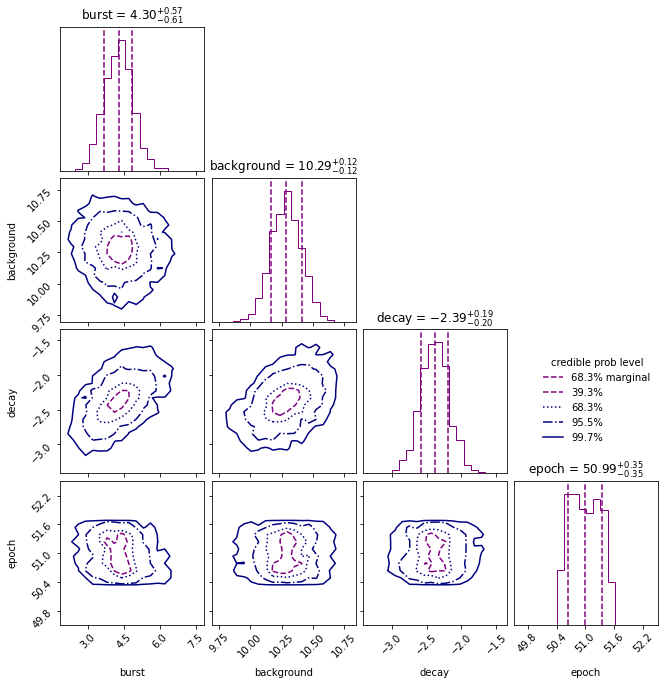

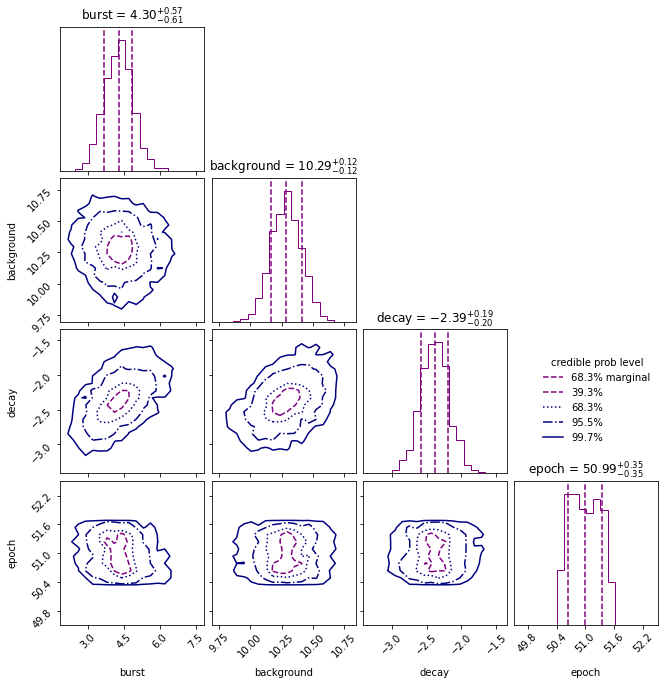

In [125]:
param_names = ['burst', 'background', 'decay', 'epoch']
sampler_ultranest_b = ultranest.ReactiveNestedSampler(param_names, my_likelihood, 
                                          my_prior_transform)
result = sampler_ultranest_b.run()
sampler_ultranest_b.print_results()
cornerplot(result)

MEK: Grab the resulting parameter values, and plot them on top of the raw data

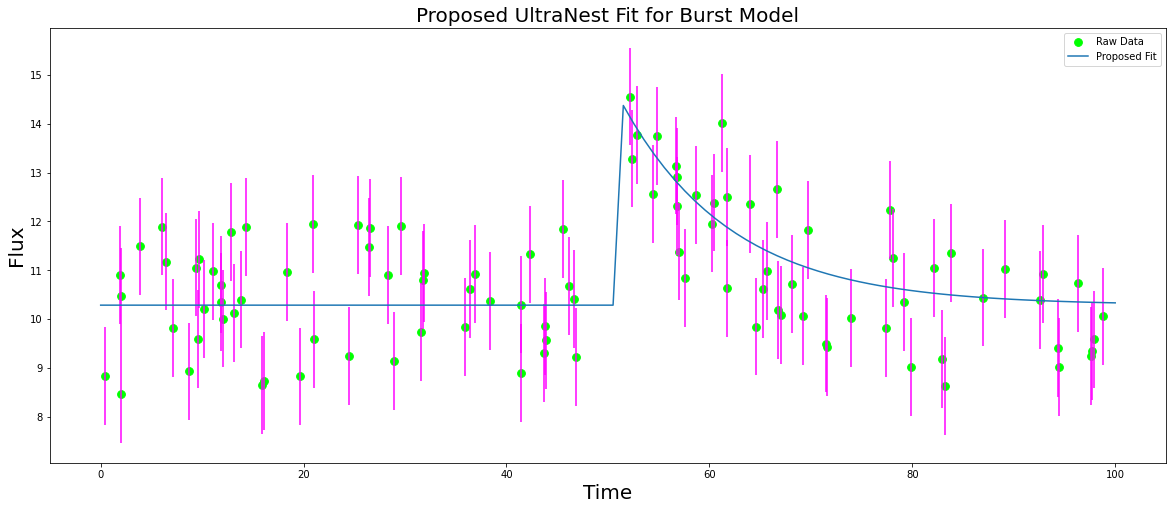

In [151]:
final_parameters = sampler_ultranest_b.results['posterior']['mean']

plt.figure(figsize=(20,8))
plt.errorbar(time, flux, yerr=uncert, color="magenta", fmt="none")
plt.scatter(time, flux, color="lime", s=60, label="Raw Data")

nest_result = burst(t, final_parameters[0], final_parameters[1], final_parameters[2], final_parameters[3])
plt.plot(t, nest_result, label="Proposed Fit")
plt.title("Proposed UltraNest Fit for Burst Model", fontsize=20)
plt.xlabel("Time", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.legend()
plt.show()

MEK: Pull the log(evidence) for Gaussian and burst models, convert it into evidence, use that to calculate Bayes factor

In [155]:
logz_g = sampler_ultranest_g.results['logz']
logz_b = sampler_ultranest_b.results['logz']

z_g = np.exp(logz_g)
z_b = np.exp(logz_b)
bayes = z_b/z_g
print("Bayes factor =", '%.4f'%bayes)

Bayes factor = 46.1599


MEK: The burst model is favored compared to the Gaussian model because it has a Bayes factor>1!